In [353]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering


from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


from itertools import cycle
import networkx as nx



from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from lineage import get_lineage_coll, get_lineage_snp
from resistance import get_resistance_snp
from coinfection_functions import import_VCF42_to_pandas, filter_repeats, add_snp_distance, scatter_vcf_pos, distplot_sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
sample_list = []
vcf_files = []
directory = "in_silico"

for file in os.listdir(directory):
    if file.endswith(".snp.hf.pass.vcf"):
        name = file.split(".")[0]
        sample_list.append(name)
        file_path = os.path.join(directory, file)
        vcf_files.append(file_path)
        
sample_list.sort()
vcf_files.sort()

print(sample_list)
print(vcf_files)

['16250874FFD', '56850173', 'AL-75607', 'AL14621', 'BURGOS89109', 'P1_50', 'P1_80', 'P1_90', 'P1_95', 'P2_50', 'P2_80', 'P2_90', 'P2_95', 'P3_50', 'P3_80', 'P3_90', 'P3_95', 'SOMOZACOL2']
['in_silico/16250874FFD.snp.hf.pass.vcf', 'in_silico/56850173.snp.hf.pass.vcf', 'in_silico/AL-75607.snp.hf.pass.vcf', 'in_silico/AL14621.snp.hf.pass.vcf', 'in_silico/BURGOS89109.snp.hf.pass.vcf', 'in_silico/P1_50.snp.hf.pass.vcf', 'in_silico/P1_80.snp.hf.pass.vcf', 'in_silico/P1_90.snp.hf.pass.vcf', 'in_silico/P1_95.snp.hf.pass.vcf', 'in_silico/P2_50.snp.hf.pass.vcf', 'in_silico/P2_80.snp.hf.pass.vcf', 'in_silico/P2_90.snp.hf.pass.vcf', 'in_silico/P2_95.snp.hf.pass.vcf', 'in_silico/P3_50.snp.hf.pass.vcf', 'in_silico/P3_80.snp.hf.pass.vcf', 'in_silico/P3_90.snp.hf.pass.vcf', 'in_silico/P3_95.snp.hf.pass.vcf', 'in_silico/SOMOZACOL2.snp.hf.pass.vcf']


# Import vcf as dataframe

In [4]:
x = datetime.datetime.now()
print(x)
dict_vcf = {}
for vcf, df_name in zip(vcf_files, sample_list):
    dict_vcf[df_name] = import_VCF42_to_pandas(vcf)
y = datetime.datetime.now()
print(y)
print("Done with import in: %s" % (y - x))

2019-05-27 11:22:46.565547
2019-05-27 11:25:09.581123
Done with import in: 0:02:23.015576


In [5]:
dict_vcf['P1_80'].head()

#CHROM   POS ID REF ALT      QUAL FILTER  \
0  MTB_anc  1977  .   G   A  19963.51   PASS   
1  MTB_anc  2532  .   C   T  16595.27   PASS   
2  MTB_anc  6140  .   G   T  22403.11   PASS   
3  MTB_anc  7585  .   C   G  31938.04   PASS   
4  MTB_anc  9143  .   C   T  56818.27   PASS   

                                                INFO          FORMAT  \
0  AC=1;AF=0.500;AN=2;BaseQRankSum=0.720;DP=42;Ex...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=13;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.500;AN=2;BaseQRankSum=1.43;DP=52;Exc...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.500;AN=2;BaseQRankSum=1.27;DP=72;Exc...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=73;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   

                       sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
0  0/1:10,32:42:99:1042,0,200  1.0  0.5  2.0          0.72  42.0     0.0442   
1     1/1:0,13:13:39:394,39,0  2.0  1.0  2.0           NaN  13.0     3.0103   
2   0/1:43,9:52:99:213,0,1214  1.0  0.5  2.0          1.43  52.0     0.0069   
3  0/1:22,50:72:99:1565,0,484  1.0  0.5  2.0          1.27  72.0     0.0111   
4   1/1:0,73:73:99:2536,218,0  2.0  1.0  2.0           NaN  73.0     3.0103   

      FS InbreedingCoeff    MQ  MQRankSum     QD  ReadPosRankSum    SOR   GT  \
0  1.003          0.5558  60.0        0.0  30.57           0.655  0.434  0/1   
1  0.000         -0.0000  60.0        NaN  31.55             NaN  0.883  1/1   
2  0.919          0.7203  60.0        0.0  29.67          -0.273  0.827  0/1   
3  0.994          0.6656  60.0        0.0  32.33          -0.405  0.573  0/1   
4  0.000          0.0000  60.0        NaN  34.27             NaN  1.010  1/1   

      AD    GQ          PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD    dp  \
0  10,32  99.0  1042,0,200  NaN  NaN  NaN       2    10.0    32.0  42.0   
1   0,13  39.0    394,39,0  NaN  NaN  NaN       2     0.0    13.0  13.0   
2   43,9  99.0  213,0,1214  NaN  NaN  NaN       2    43.0     9.0  52.0   
3  22,50  99.0  1565,0,484  NaN  NaN  NaN       2    22.0    50.0  72.0   
4   0,73  99.0  2536,218,0  NaN  NaN  NaN       2     0.0    73.0  73.0   

         aF        AF  
0  0.238095  0.761905  
1  0.000000  1.000000  
2  0.826923  0.173077  
3  0.305556  0.694444  
4  0.000000  1.000000

In [6]:
dict_vcf['P1_80'].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'GT', 'AD', 'GQ', 'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD',
       'ALT_AD', 'dp', 'aF', 'AF'],
      dtype='object')

# Add repeat and snp distance info

In [7]:
#dict_vcf = {}

for name, vcf_df in dict_vcf.items():
    #Add repeat info (Phage, Transposon or PE/PPE regions)
    vcf_df['Is_repeat'] = vcf_df.apply(filter_repeats, axis=1)

    #Add info of nearby positions
    add_snp_distance(vcf_df)

In [8]:
dict_vcf['P1_80'].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'GT', 'AD', 'GQ', 'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD',
       'ALT_AD', 'dp', 'aF', 'AF', 'Is_repeat', 'snp_left_distance',
       'snp_right_distance'],
      dtype='object')

# Create a set of filtered df in different dictionary

In [375]:
dict_dff = {}
distance = 15
QD = 15
for name, df_vcf in dict_vcf.items():
    list_positions_to_filter = df_vcf['POS'][((df_vcf.snp_left_distance <= distance)|
                                (df_vcf.snp_right_distance <= distance)|
                                (df_vcf.Is_repeat == True) |
                                (df_vcf.AF <= 0.0) |
                                (df_vcf.len_AD > 2) |
                                (df_vcf.QD <= QD))].tolist()
    dict_dff[name] = df_vcf[~df_vcf.POS.isin(list_positions_to_filter)]

In [376]:
dict_dff['P1_80'][dict_dff['P1_80'].Is_repeat == True].head()

Empty DataFrame
Columns: [#CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT, sample, AC, af, AN, BaseQRankSum, DP, ExcessHet, FS, InbreedingCoeff, MQ, MQRankSum, QD, ReadPosRankSum, SOR, GT, AD, GQ, PL, PGT, PID, PS, len_AD, REF_AD, ALT_AD, dp, aF, AF, Is_repeat, snp_left_distance, snp_right_distance]
Index: []

In [377]:
dict_dff['P1_80'][dict_dff['P1_80'].snp_left_distance <= 30].head()

#CHROM      POS ID REF ALT      QUAL FILTER  \
229  MTB_anc   498557  .   A   C  25753.24   PASS   
293  MTB_anc   709226  .   G   A  17662.60   PASS   
324  MTB_anc   815851  .   G   A  39915.27   PASS   
422  MTB_anc  1107940  .   C   A  48351.27   PASS   
473  MTB_anc  1250357  .   G   T  46137.27   PASS   

                                                  INFO  \
229  AC=1;AF=0.500;AN=2;BaseQRankSum=1.60;DP=62;Exc...   
293  AC=1;AF=0.500;AN=2;BaseQRankSum=3.07;DP=53;Exc...   
324  AC=2;AF=1.00;AN=2;DP=81;ExcessHet=3.0103;FS=0....   
422  AC=2;AF=1.00;AN=2;BaseQRankSum=1.56;DP=70;Exce...   
473  AC=2;AF=1.00;AN=2;BaseQRankSum=1.79;DP=83;Exce...   

                        FORMAT  \
229             GT:AD:DP:GQ:PL   
293  GT:AD:DP:GQ:PGT:PID:PL:PS   
324             GT:AD:DP:GQ:PL   
422             GT:AD:DP:GQ:PL   
473             GT:AD:DP:GQ:PL   

                                               sample   AC   af   AN  \
229                        0/1:10,52:62:99:1763,0,157  1.0  0.5  2.0   
293  0|1:41,12:53:99:0|1:709206_C_T:381,0,2439:709206  1.0  0.5  2.0   
324                         1/1:0,81:81:99:2410,240,0  2.0  1.0  2.0   
422                         1/1:0,70:70:99:2220,209,0  2.0  1.0  2.0   
473                         1/1:0,83:83:99:2844,249,0  2.0  1.0  2.0   

     BaseQRankSum    DP  ExcessHet     FS InbreedingCoeff    MQ  MQRankSum  \
229          1.60  62.0     0.0021  2.536          0.7750  60.0        0.0   
293          3.07  53.0     0.0111  2.159          0.6656  60.0        0.0   
324           NaN  81.0     3.0103  0.000         -0.0000  60.0        NaN   
422          1.56  70.0     3.0103  0.000         -0.0000  60.0        0.0   
473          1.79  83.0     3.0103  0.000         -0.0000  60.0        0.0   

        QD  ReadPosRankSum    SOR   GT     AD    GQ          PL  PGT  \
229  33.84          -1.763  0.373  0/1  10,52  99.0  1763,0,157  NaN   
293  33.26           2.220  0.740  0|1  41,12  99.0  381,0,2439  0|1   
324  30.99             NaN  1.046  1/1   0,81  99.0  2410,240,0  NaN   
422  32.28           1.400  0.124  1/1   0,70  99.0  2220,209,0  NaN   
473  34.10           1.640  0.469  1/1   0,83  99.0  2844,249,0  NaN   

            PID      PS  len_AD  REF_AD  ALT_AD    dp        aF        AF  \
229         NaN     NaN       2    10.0    52.0  62.0  0.161290  0.838710   
293  709206_C_T  709206       2    41.0    12.0  53.0  0.773585  0.226415   
324         NaN     NaN       2     0.0    81.0  81.0  0.000000  1.000000   
422         NaN     NaN       2     0.0    70.0  70.0  0.000000  1.000000   
473         NaN     NaN       2     0.0    83.0  83.0  0.000000  1.000000   

     Is_repeat  snp_left_distance  snp_right_distance  
229      False               26.0               396.0  
293      False               19.0              3467.0  
324      False               16.0              1779.0  
422      False               23.0              1223.0  
473      False               17.0               754.0

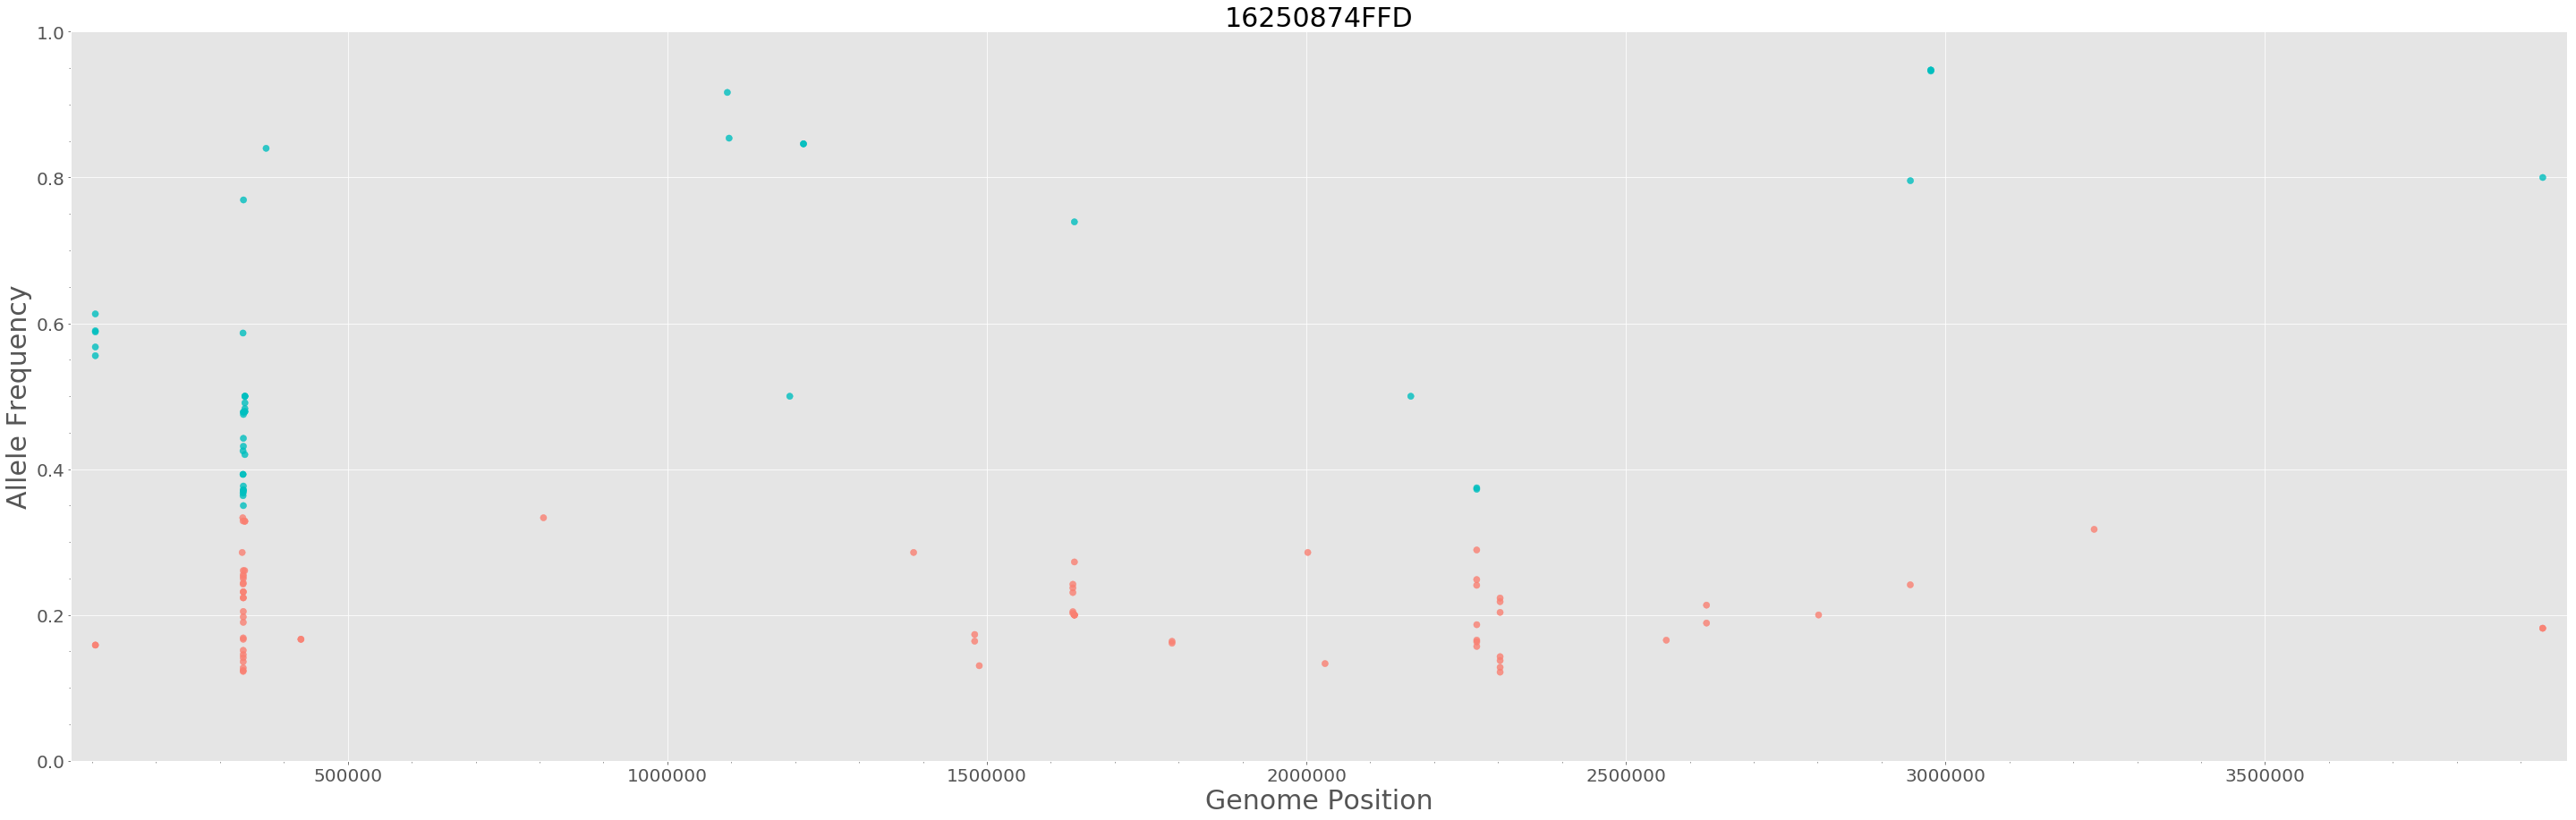

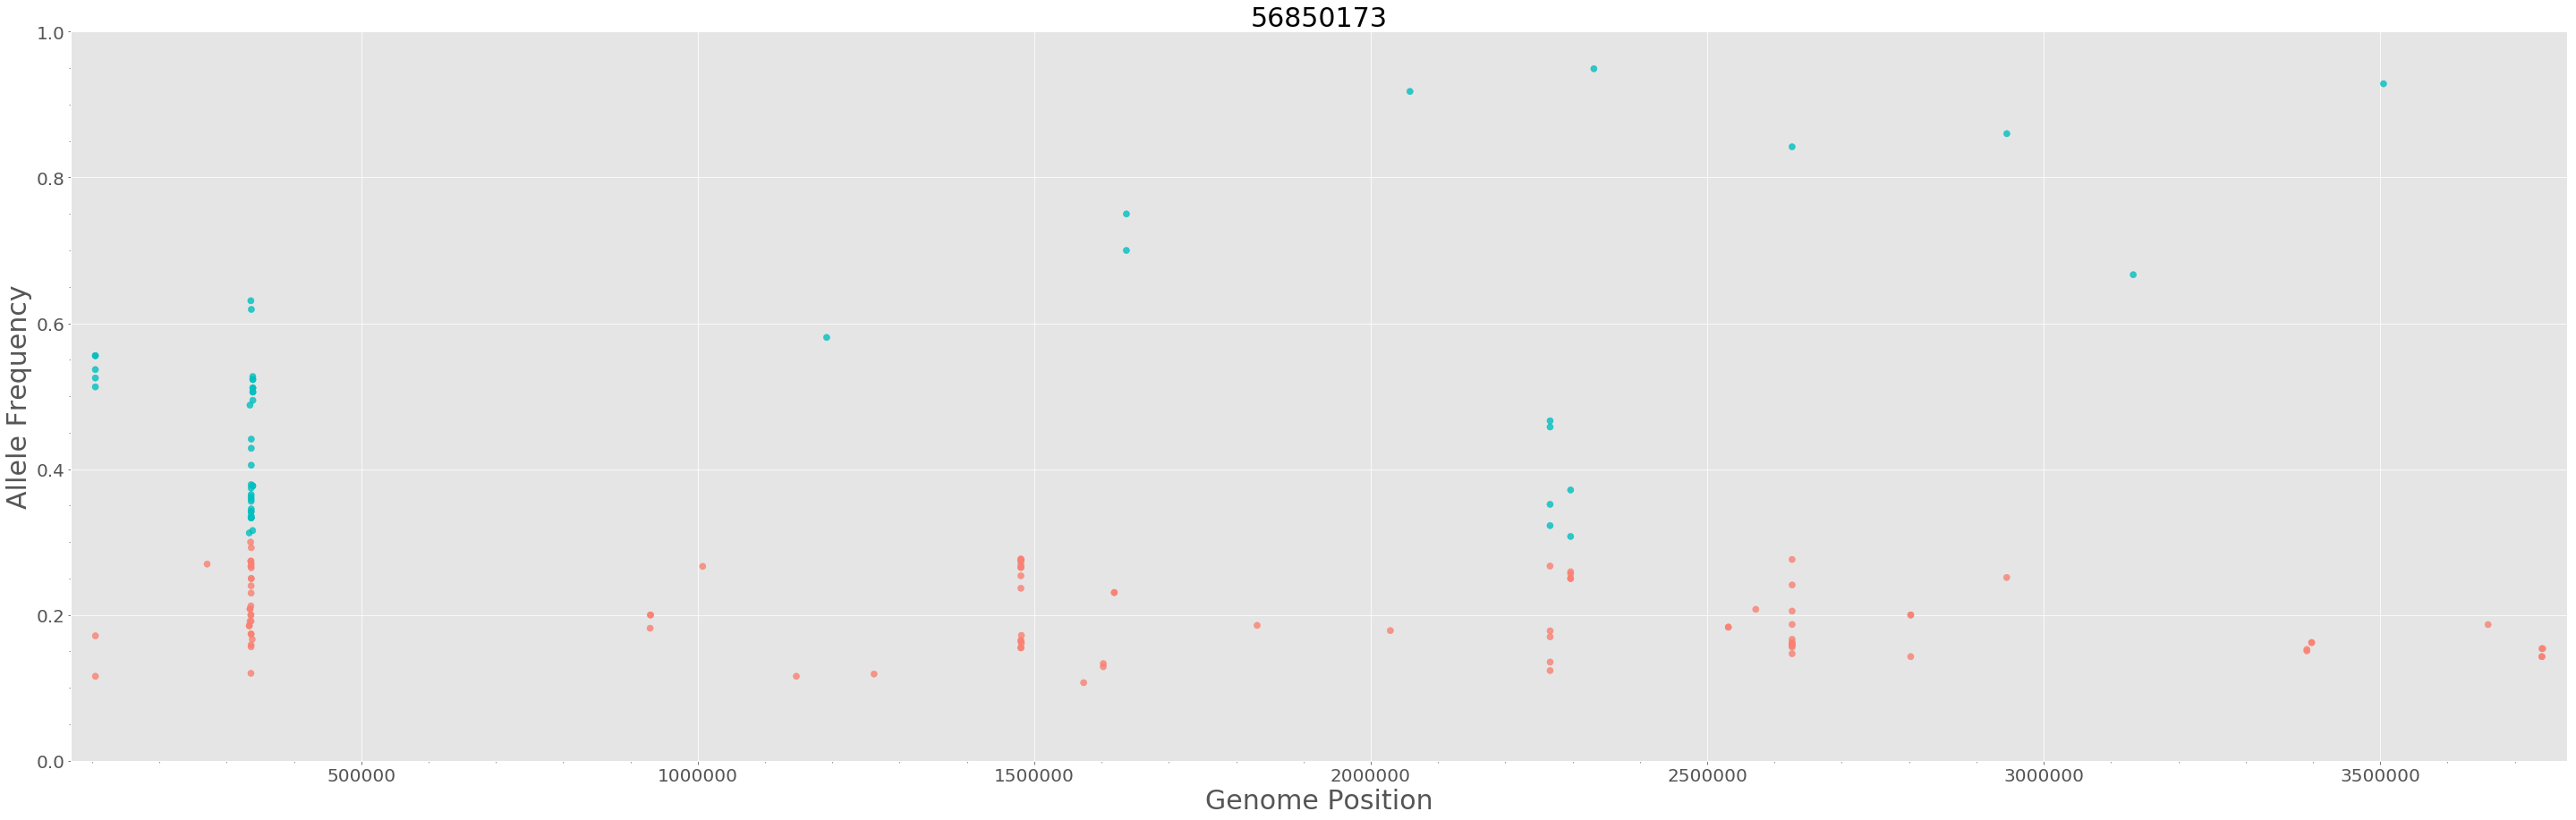

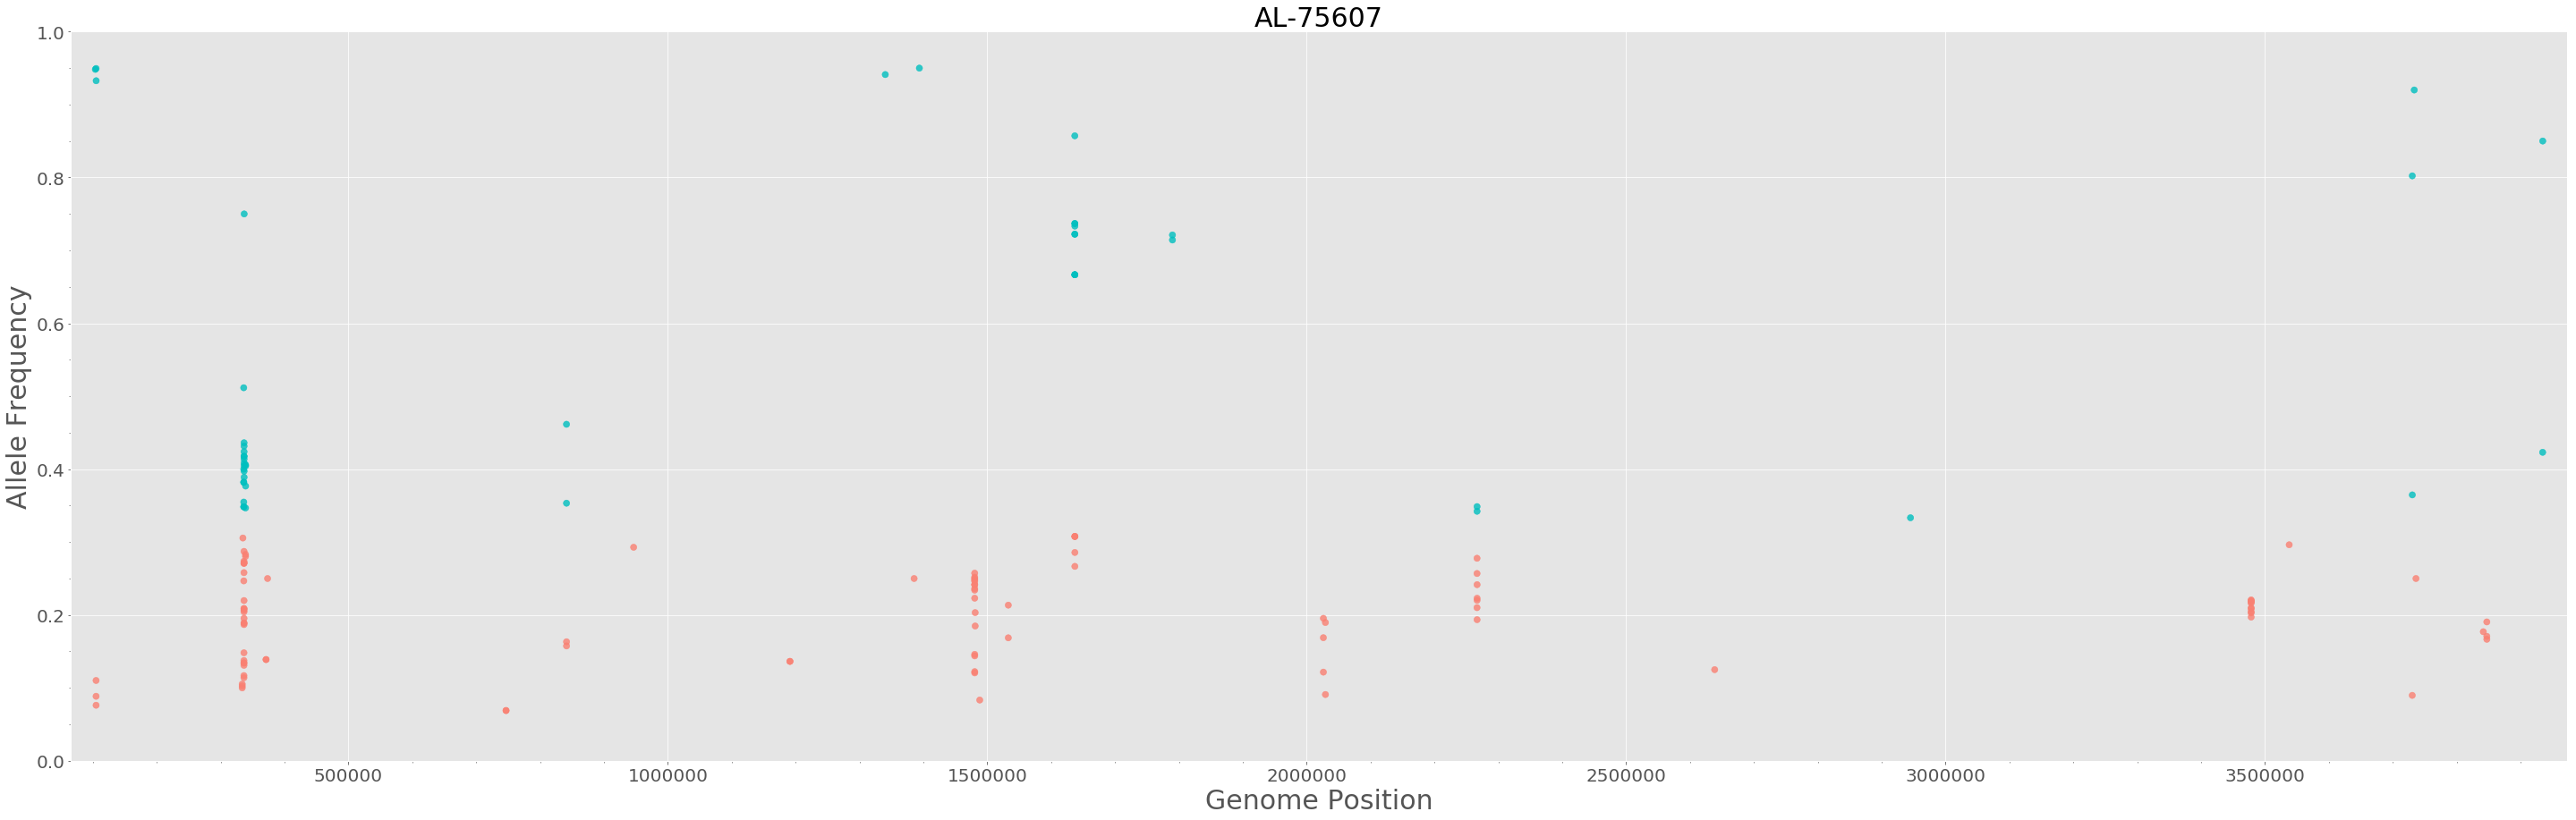

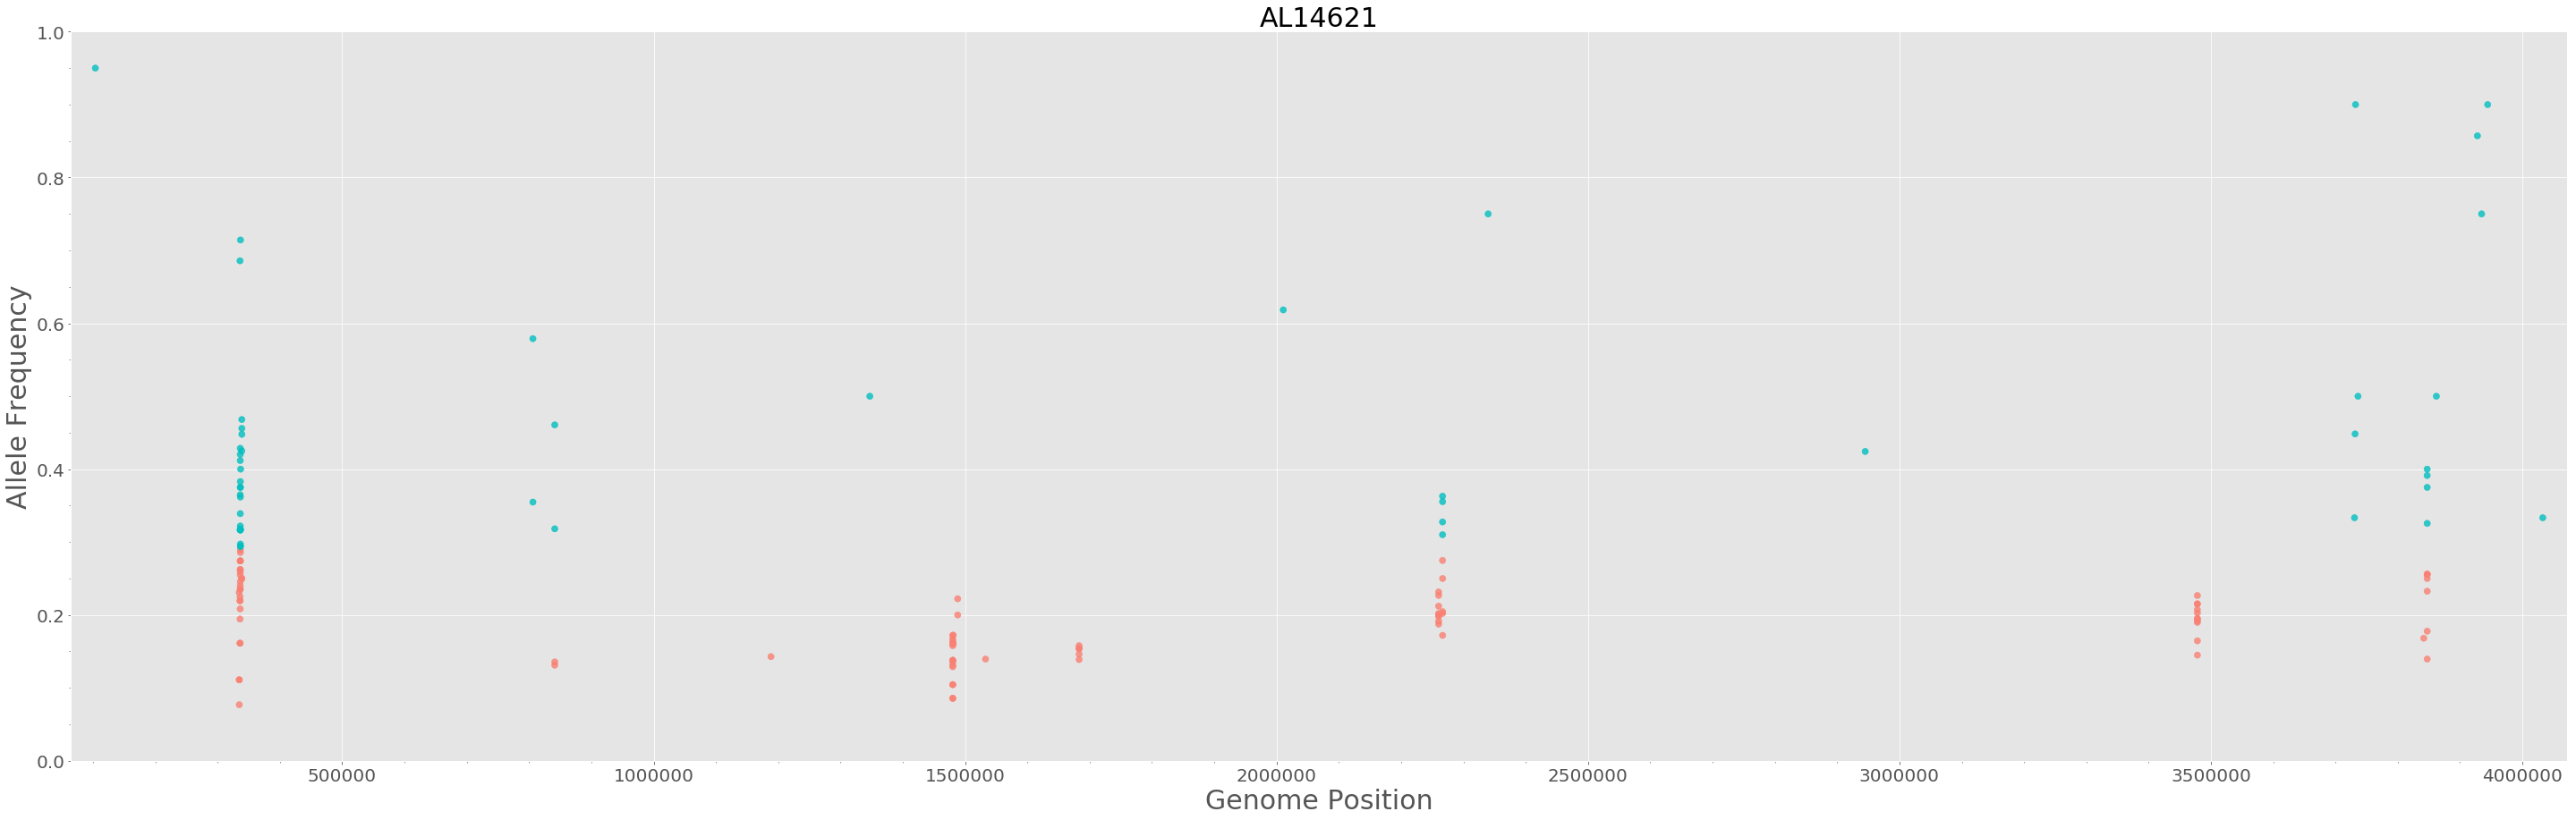

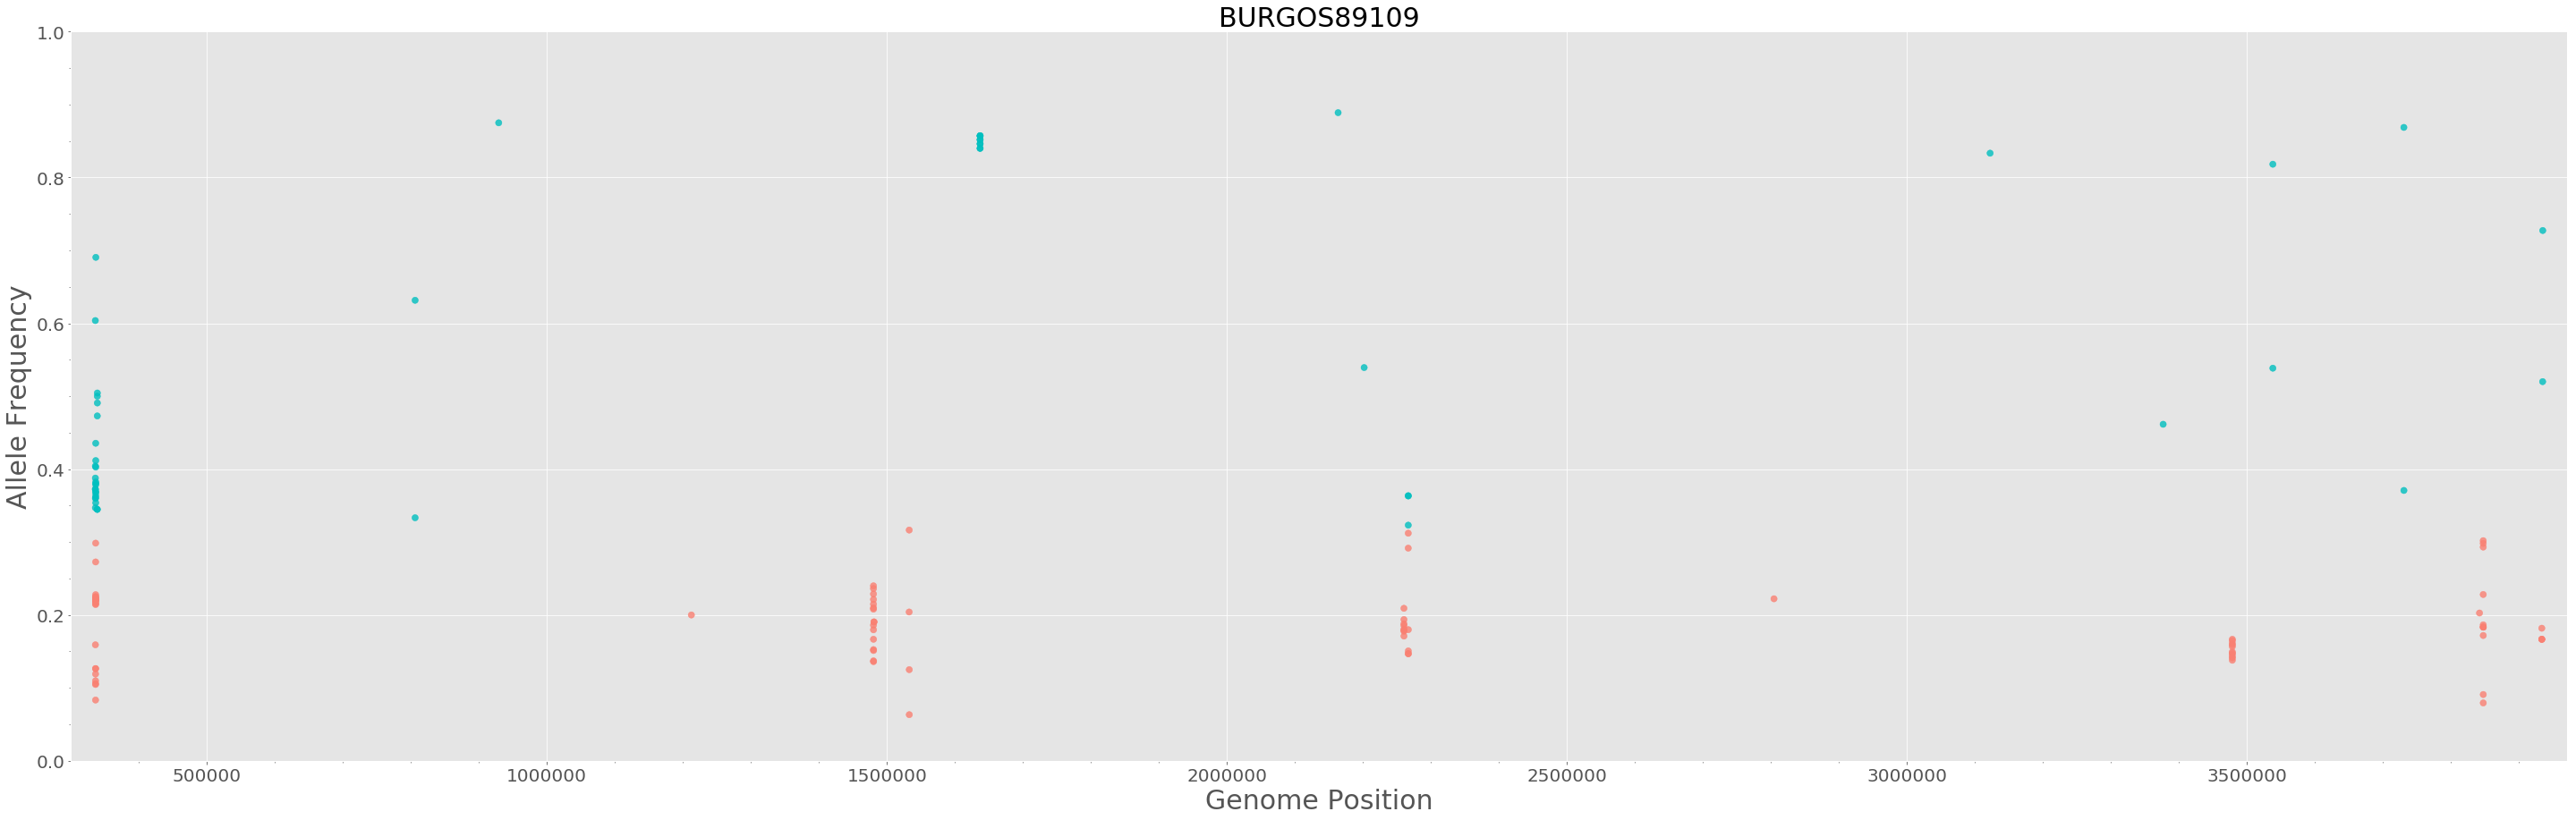

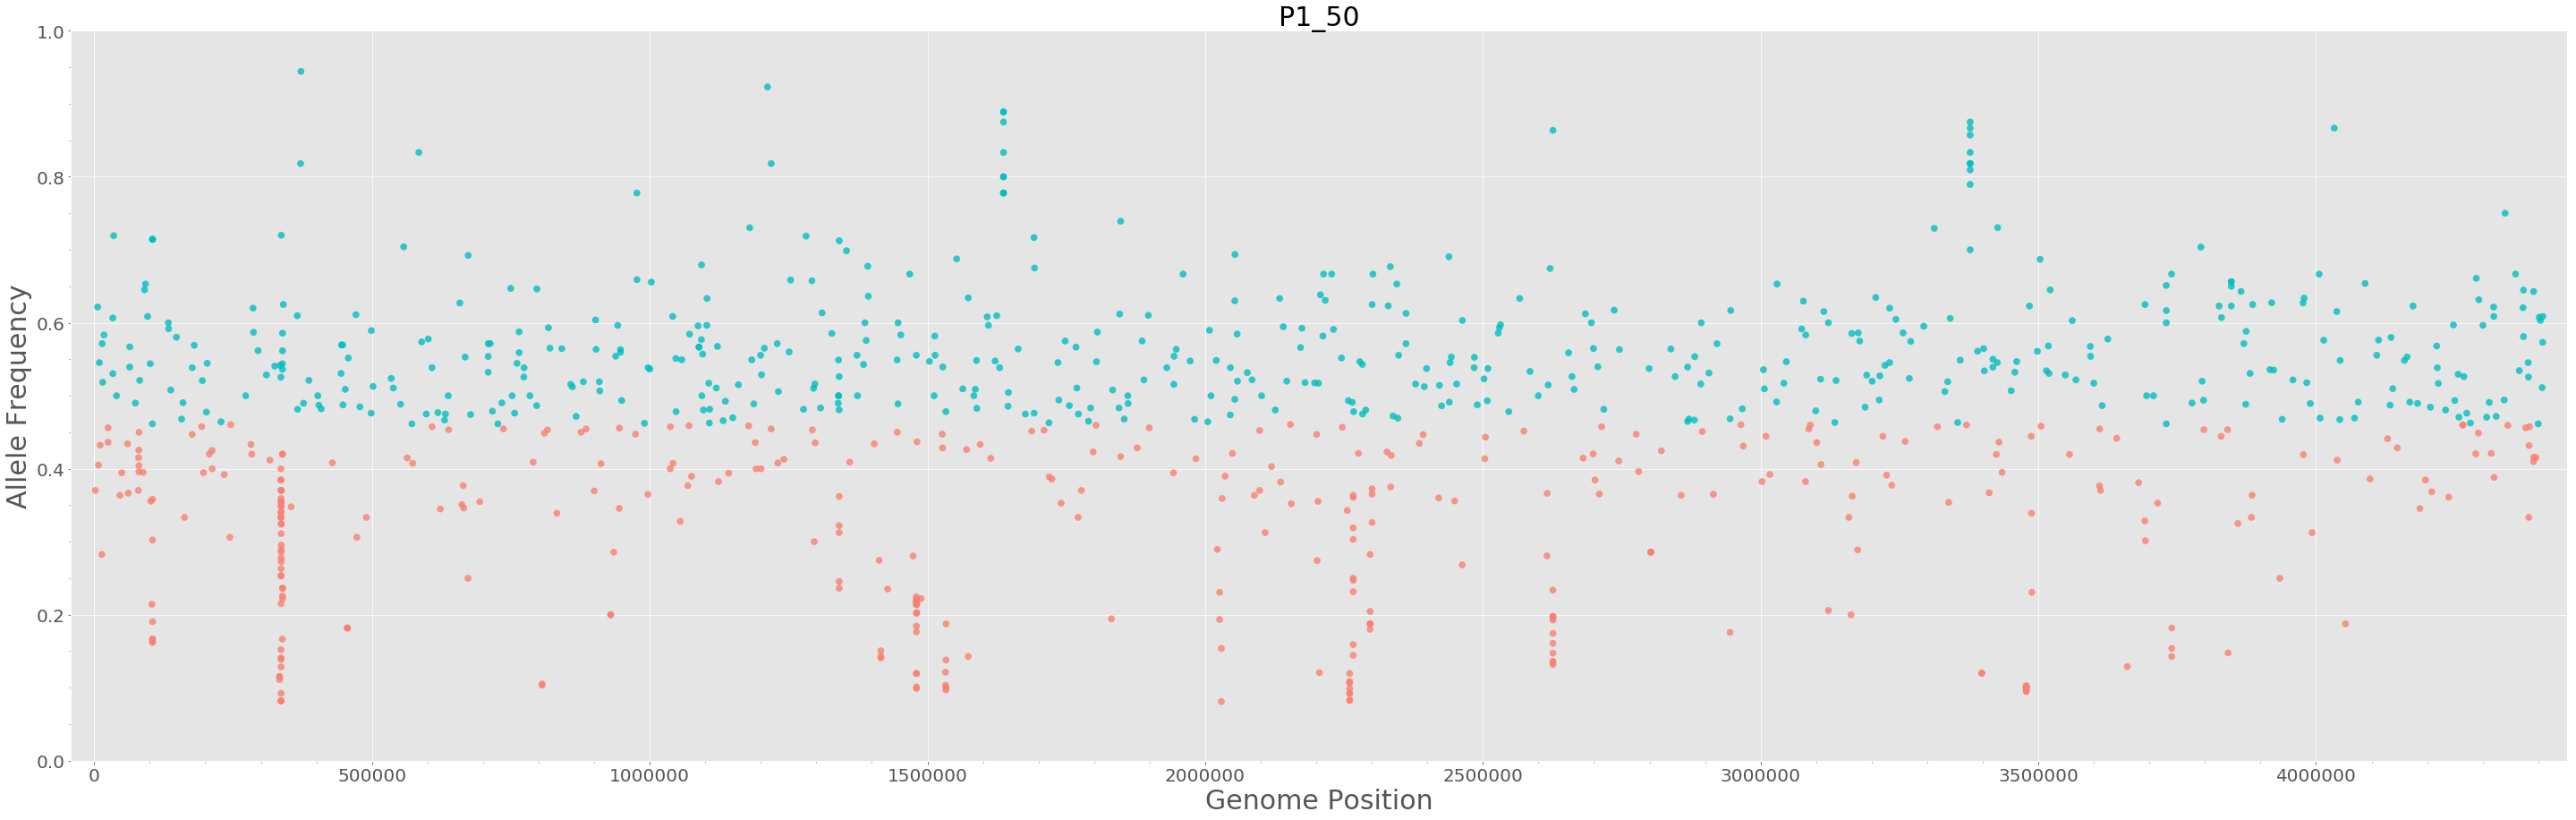

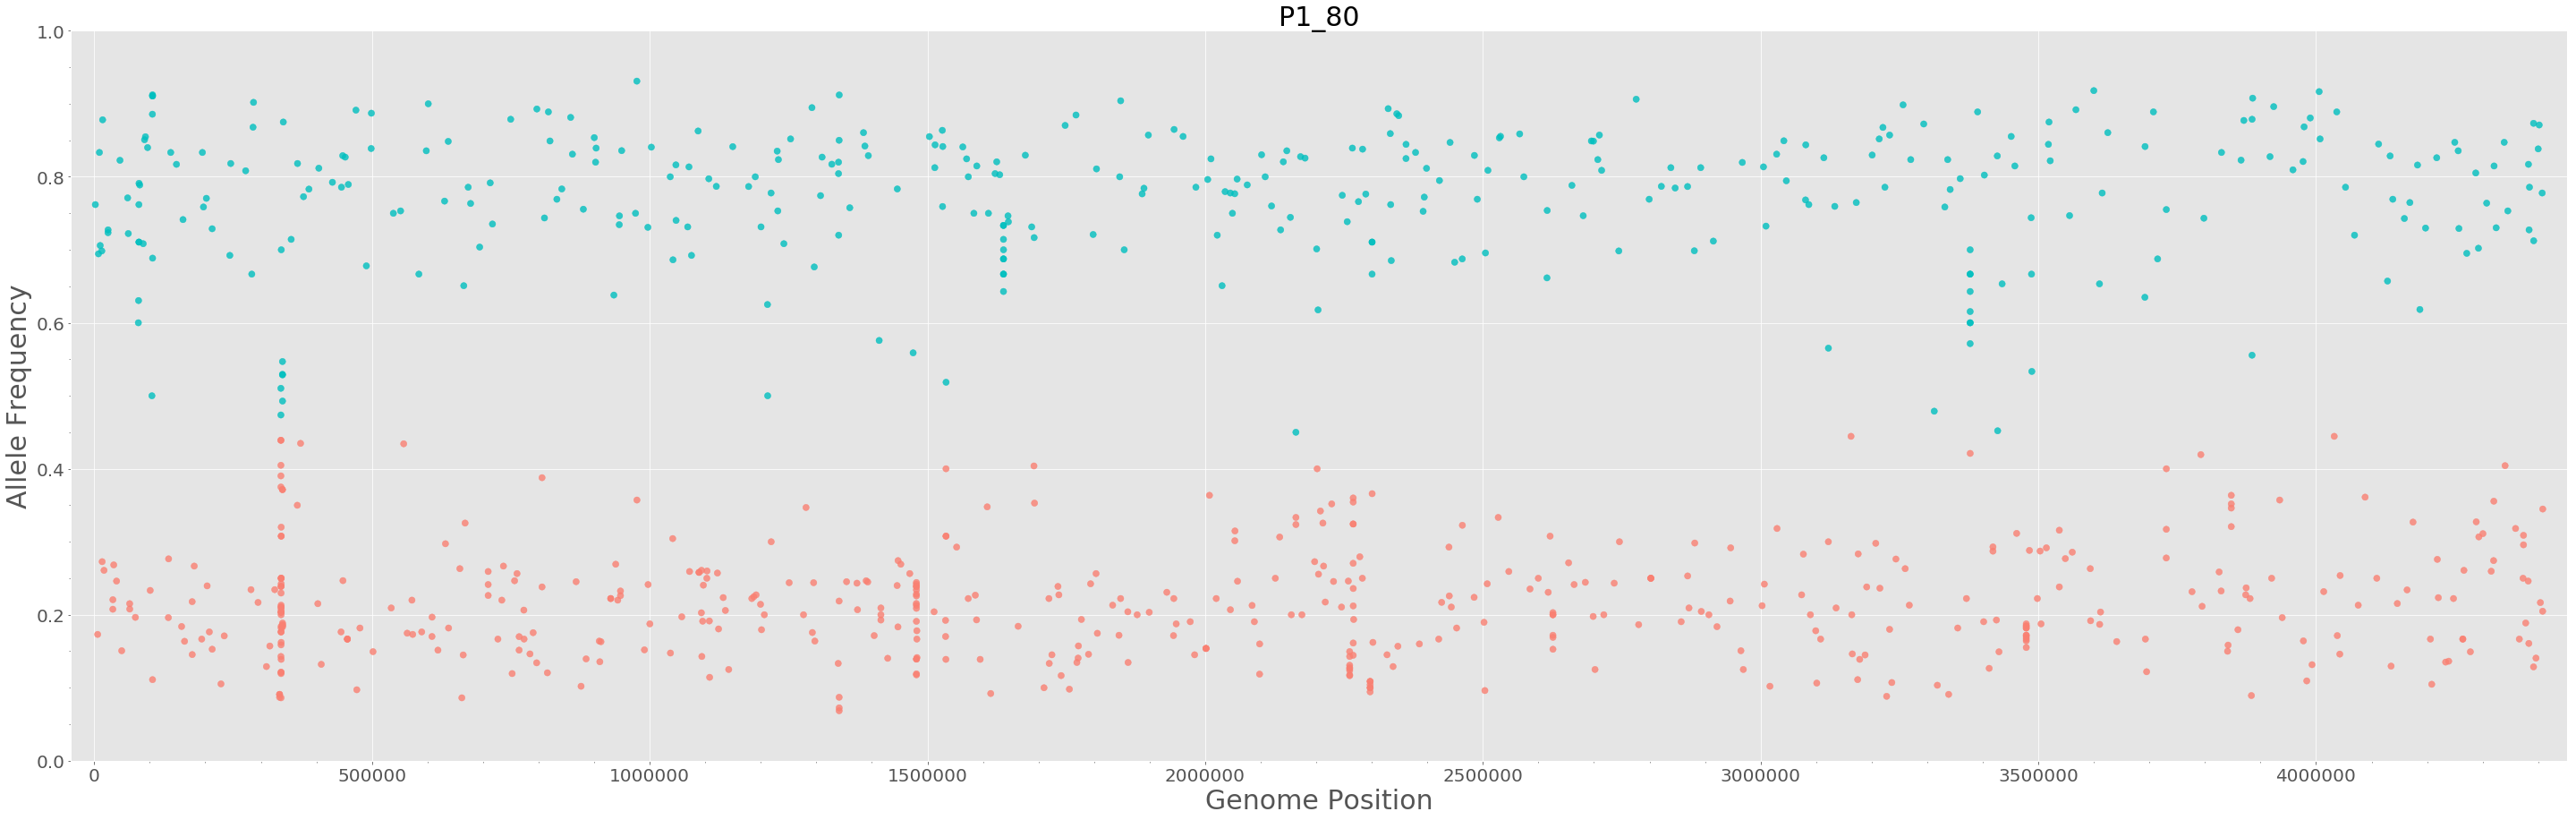

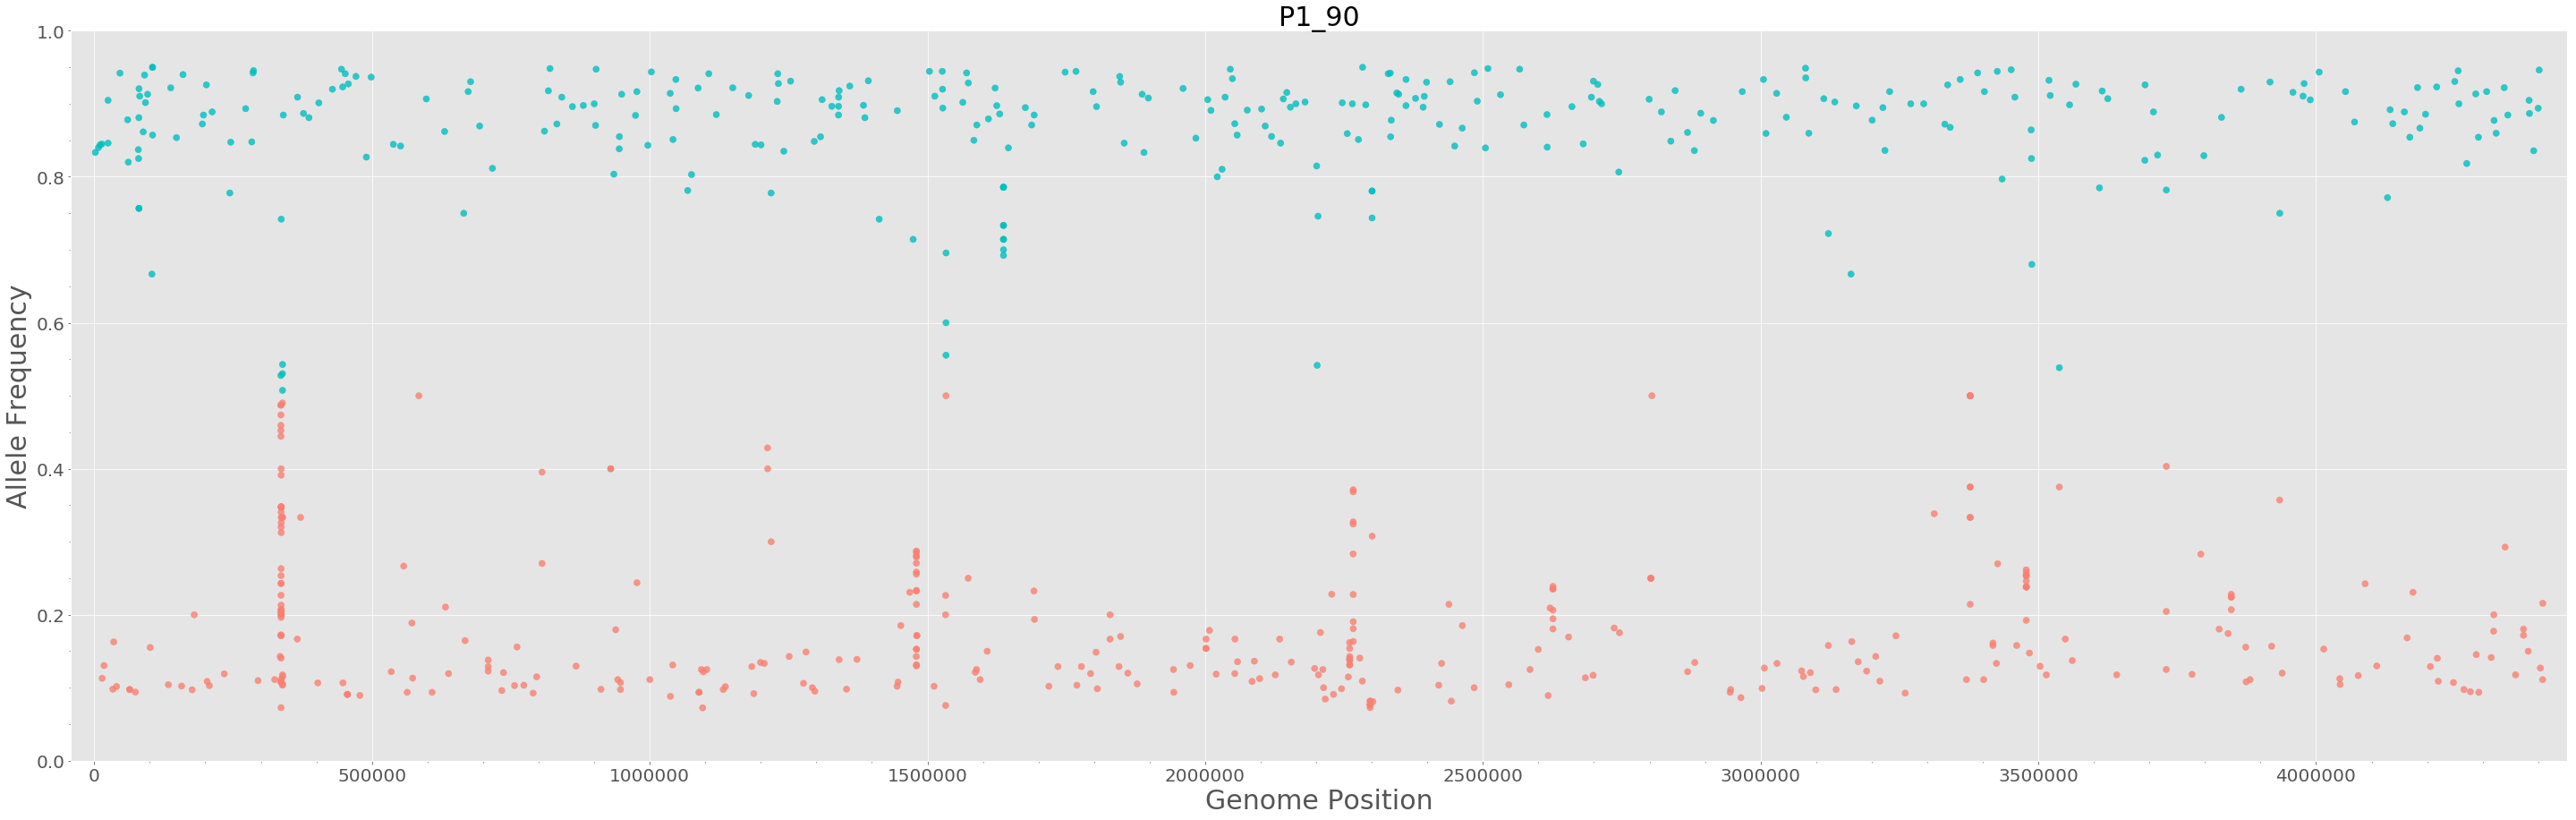

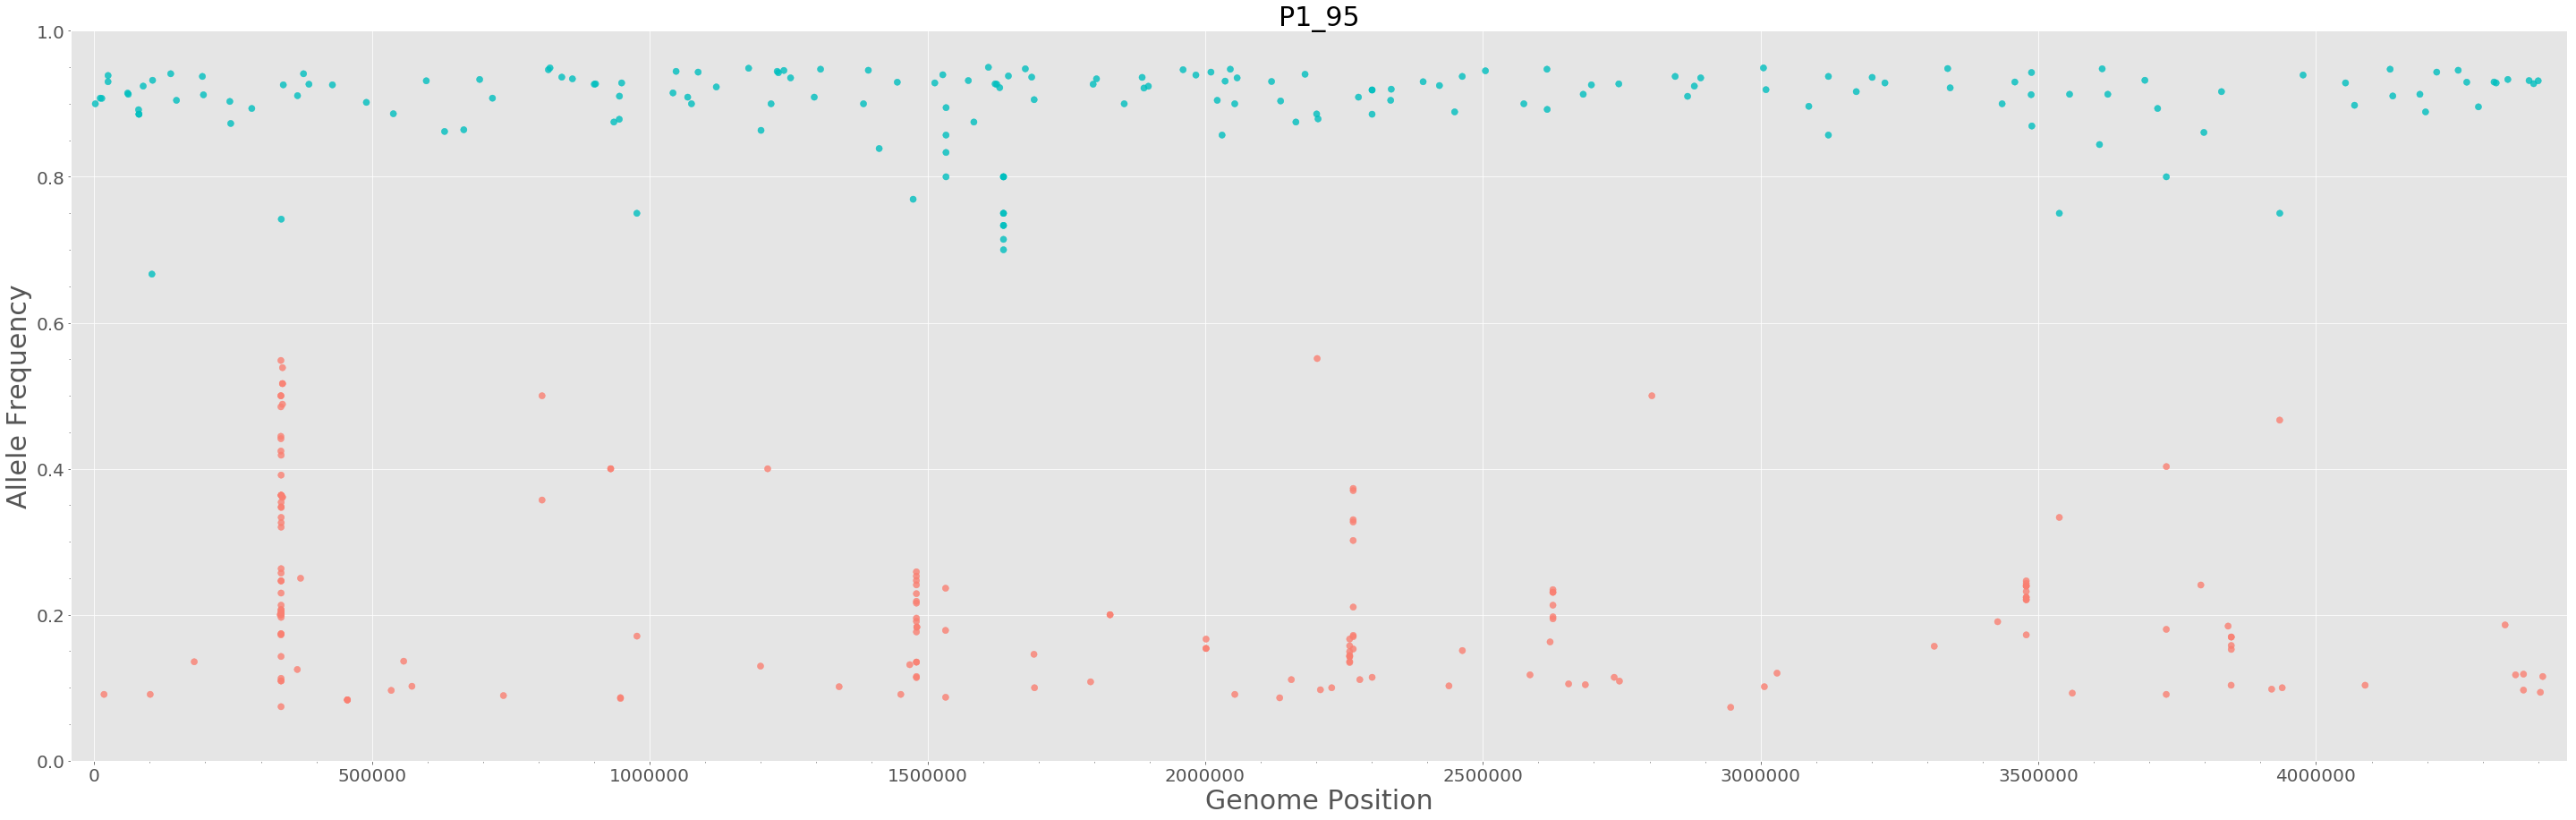

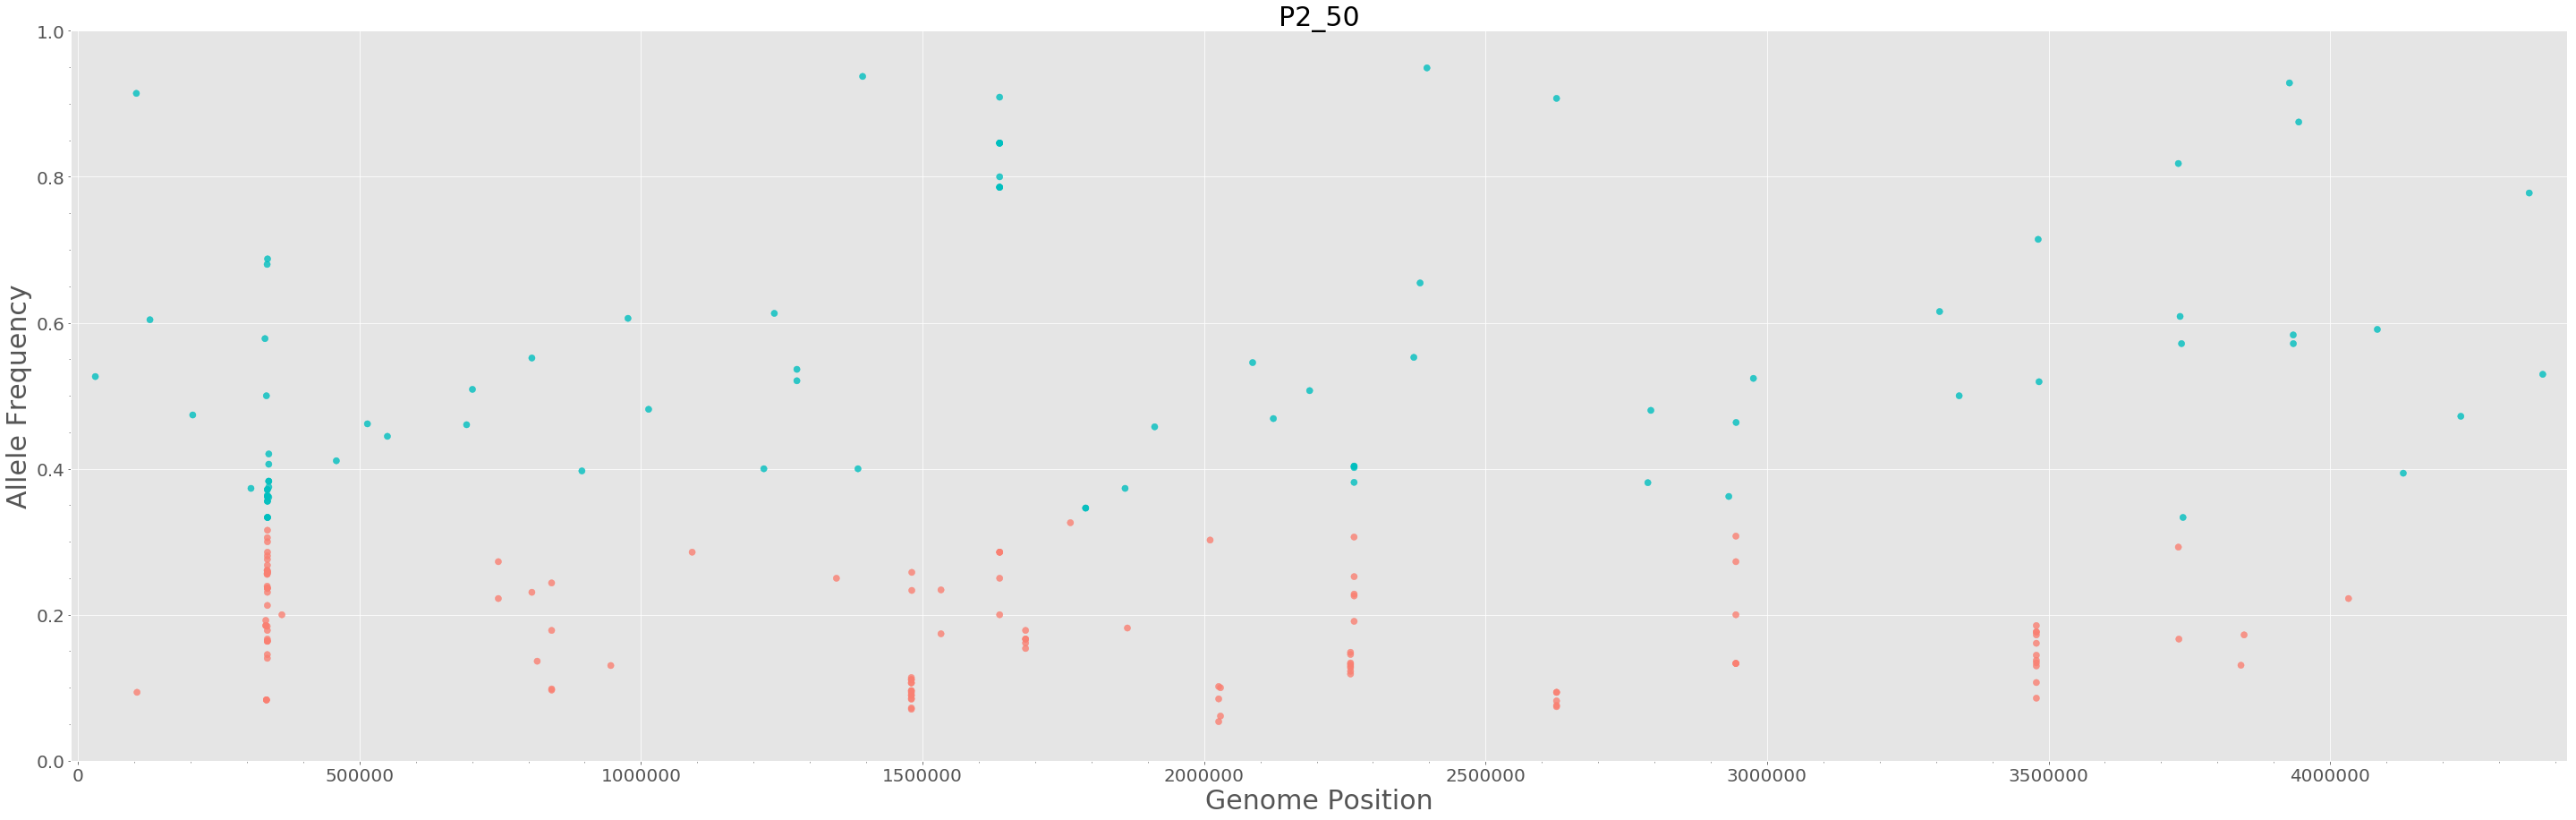

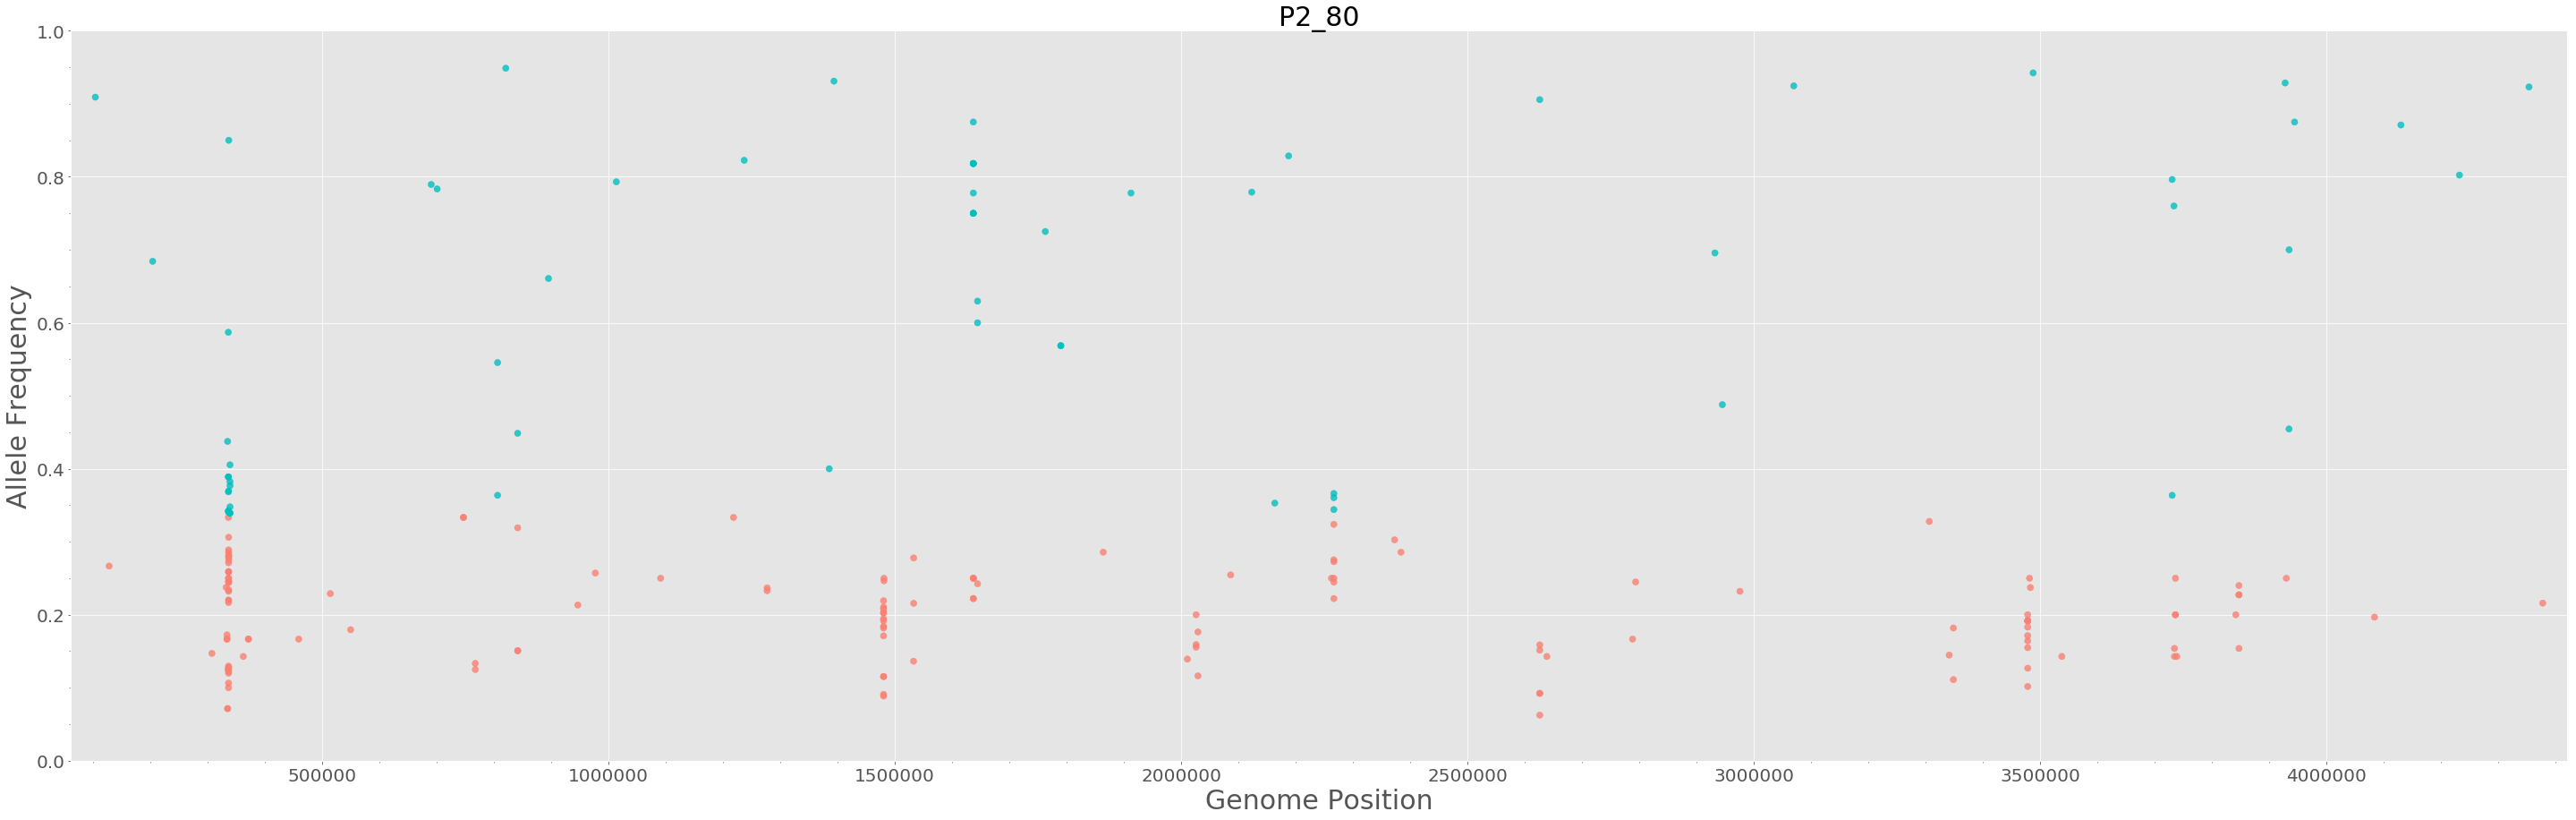

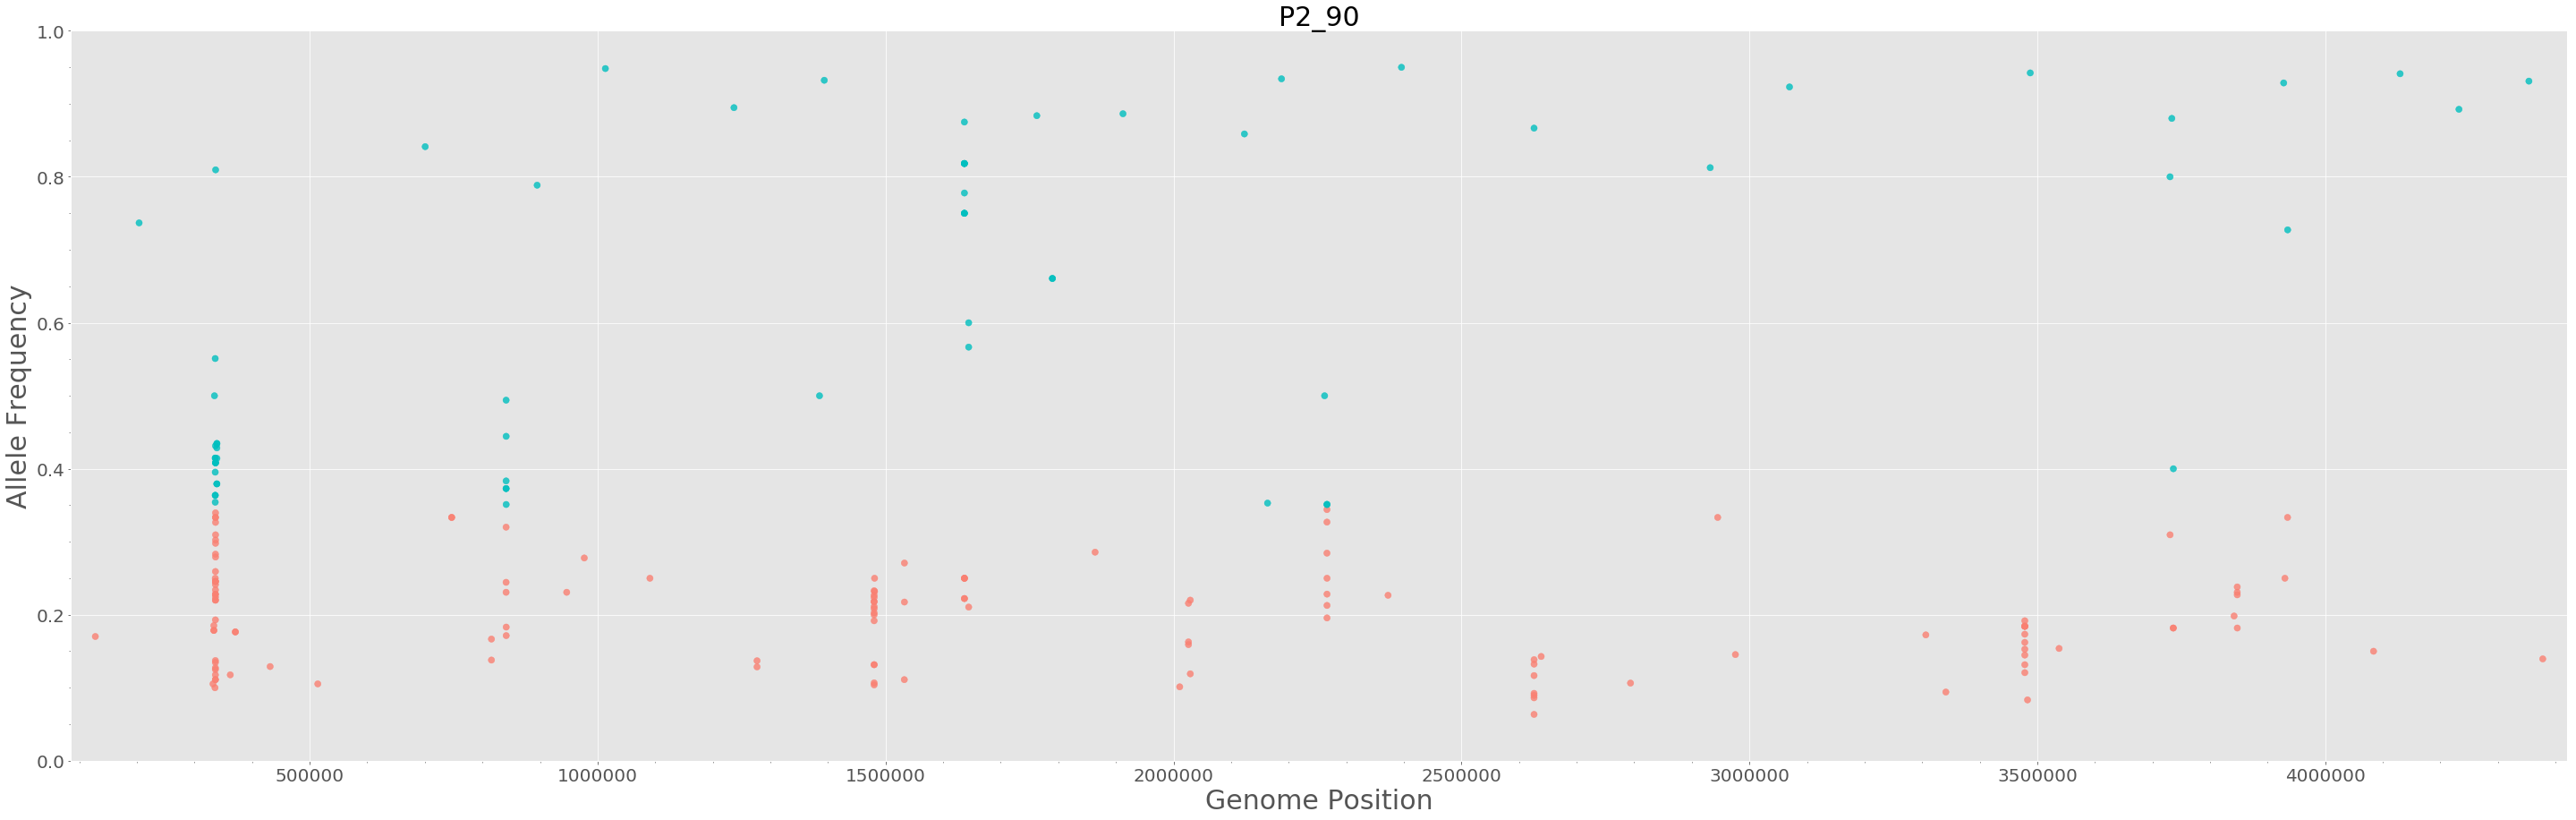

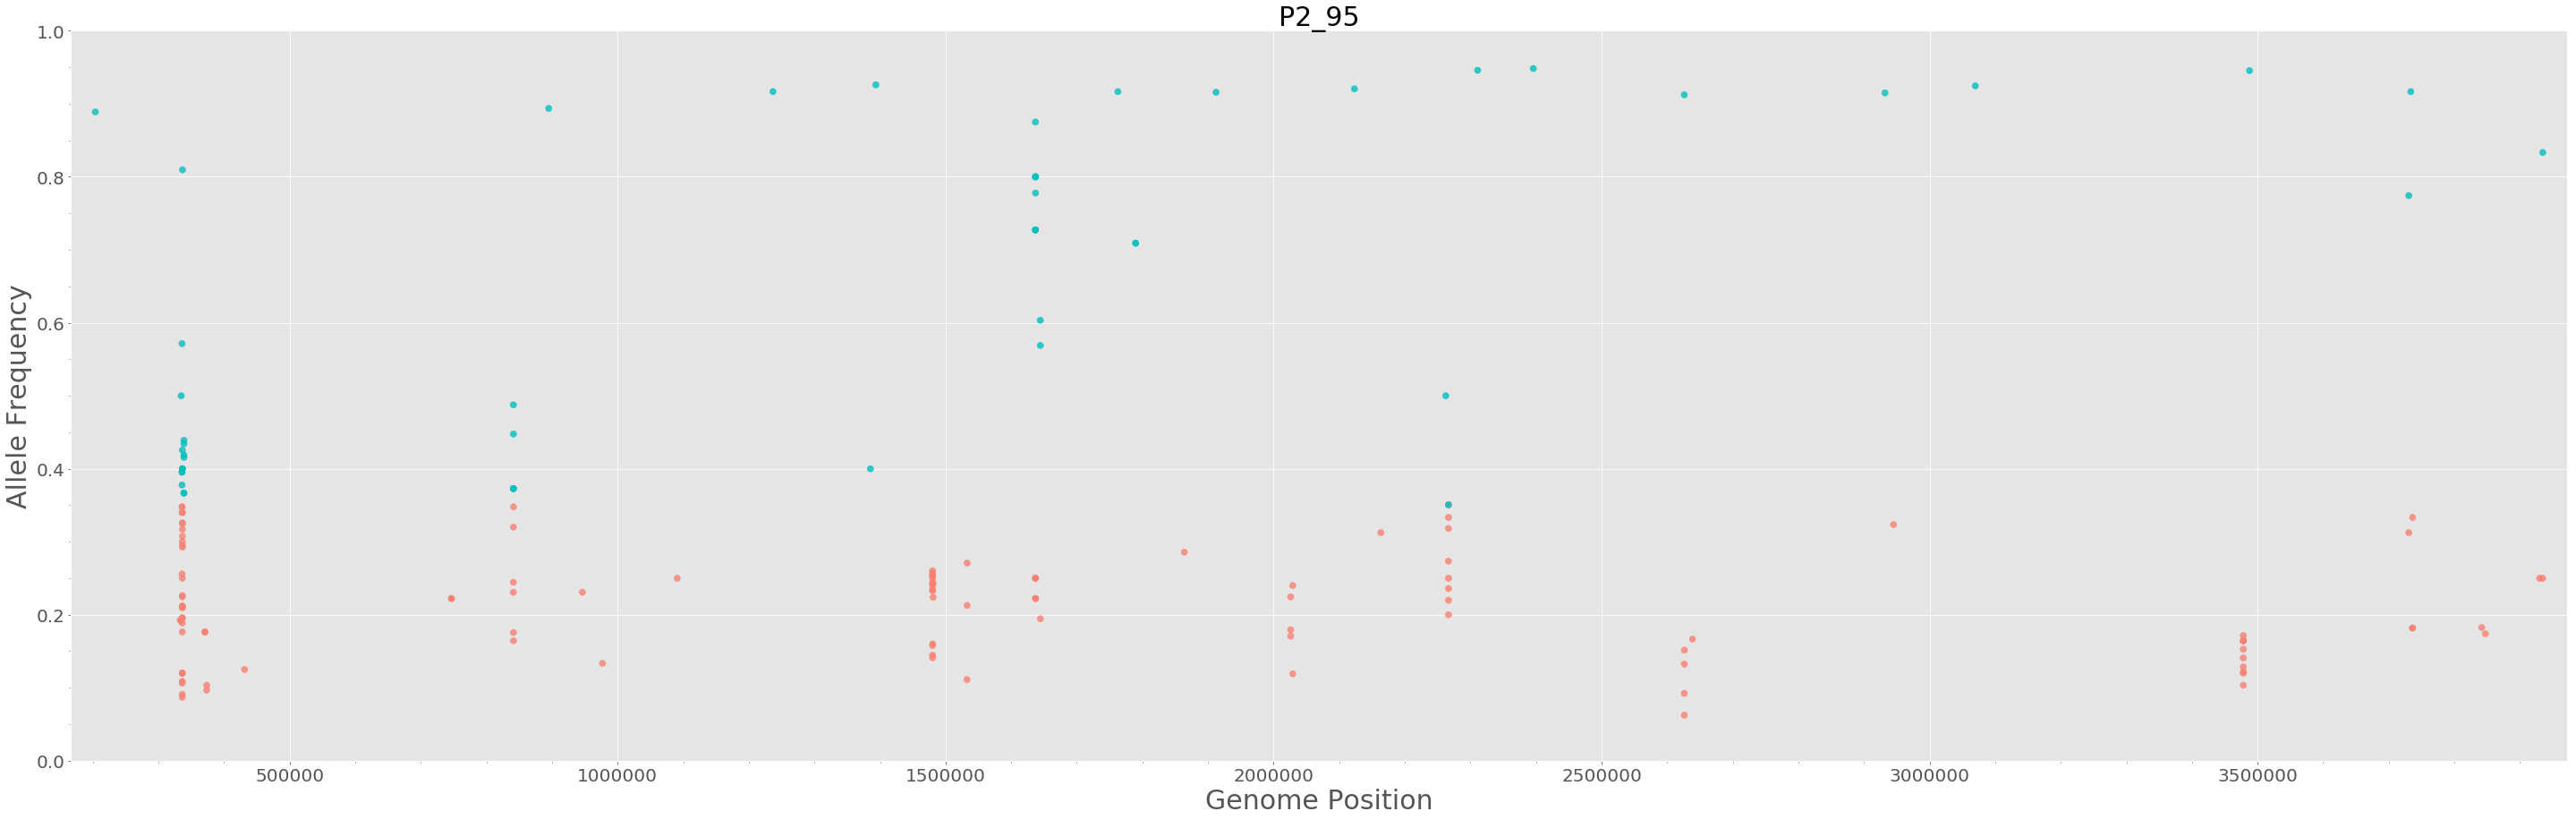

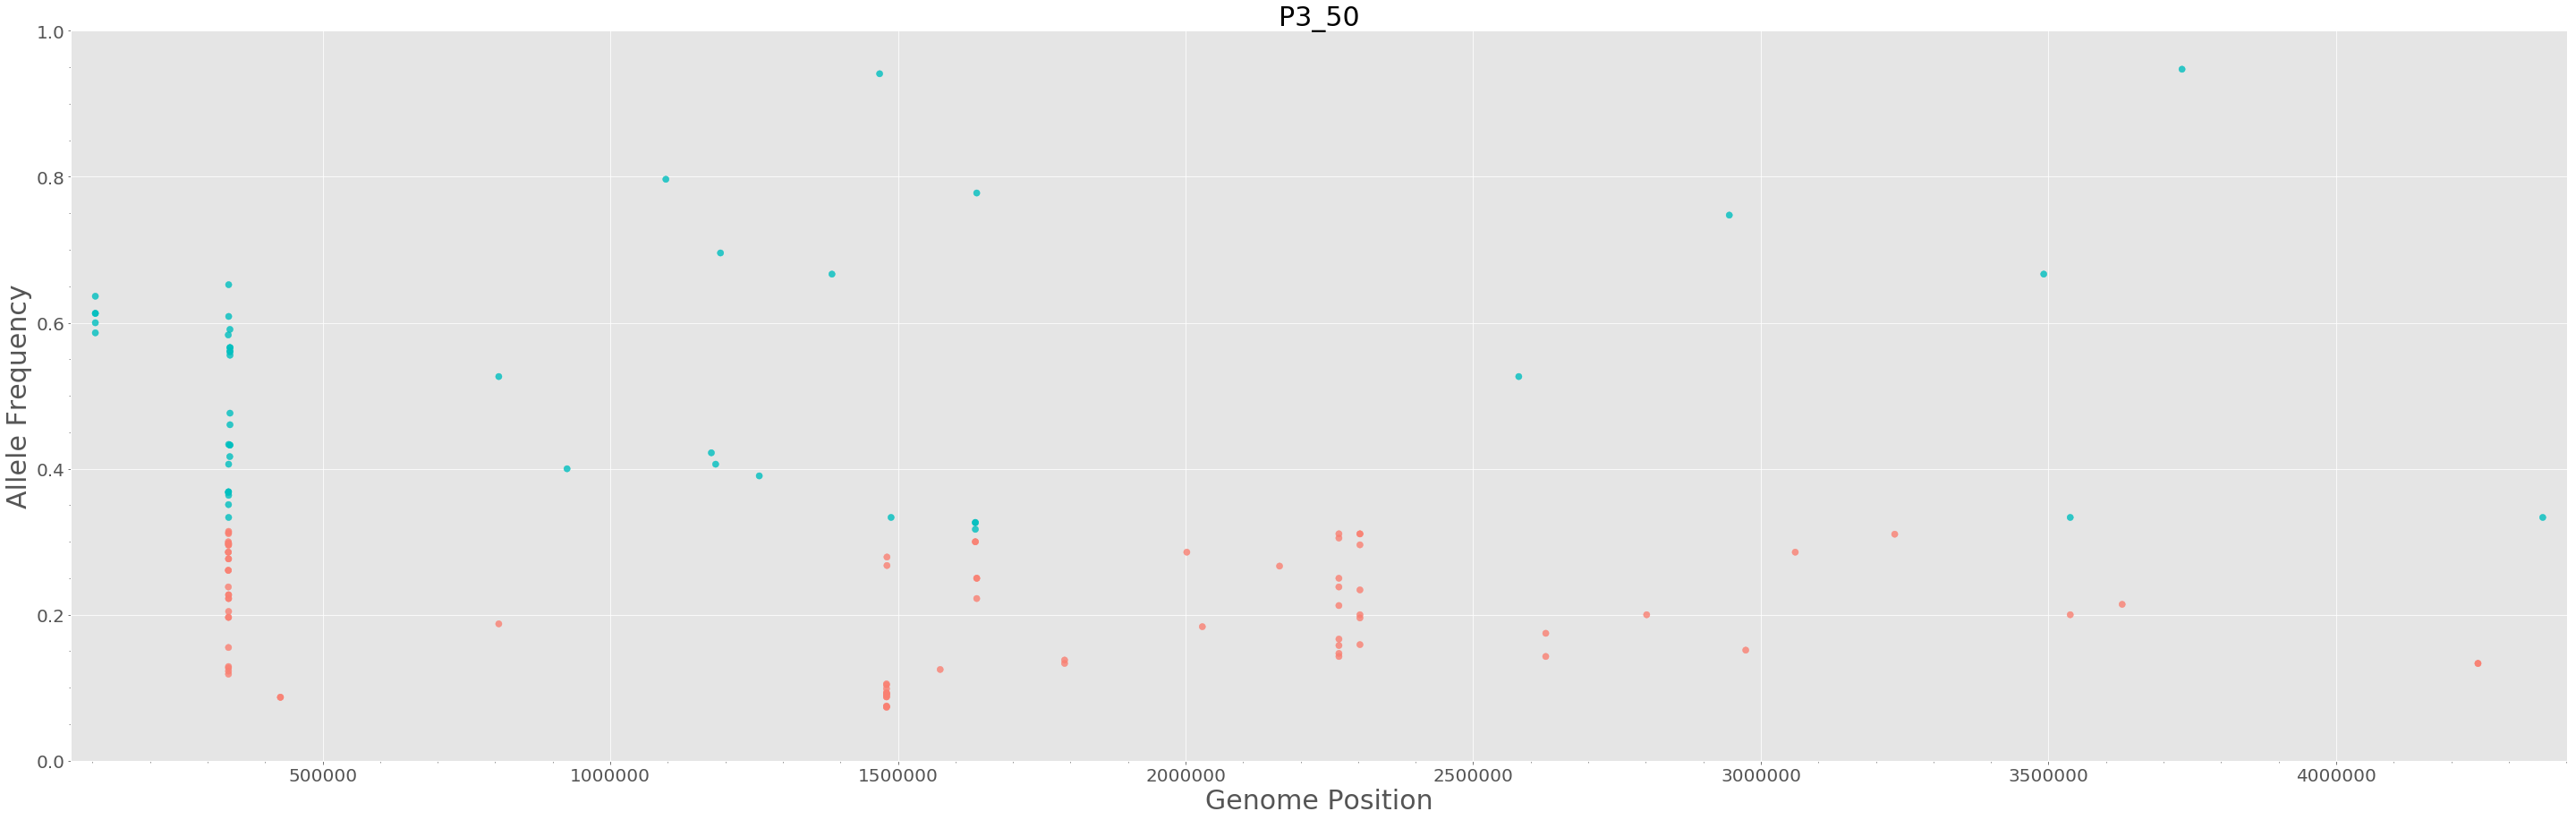

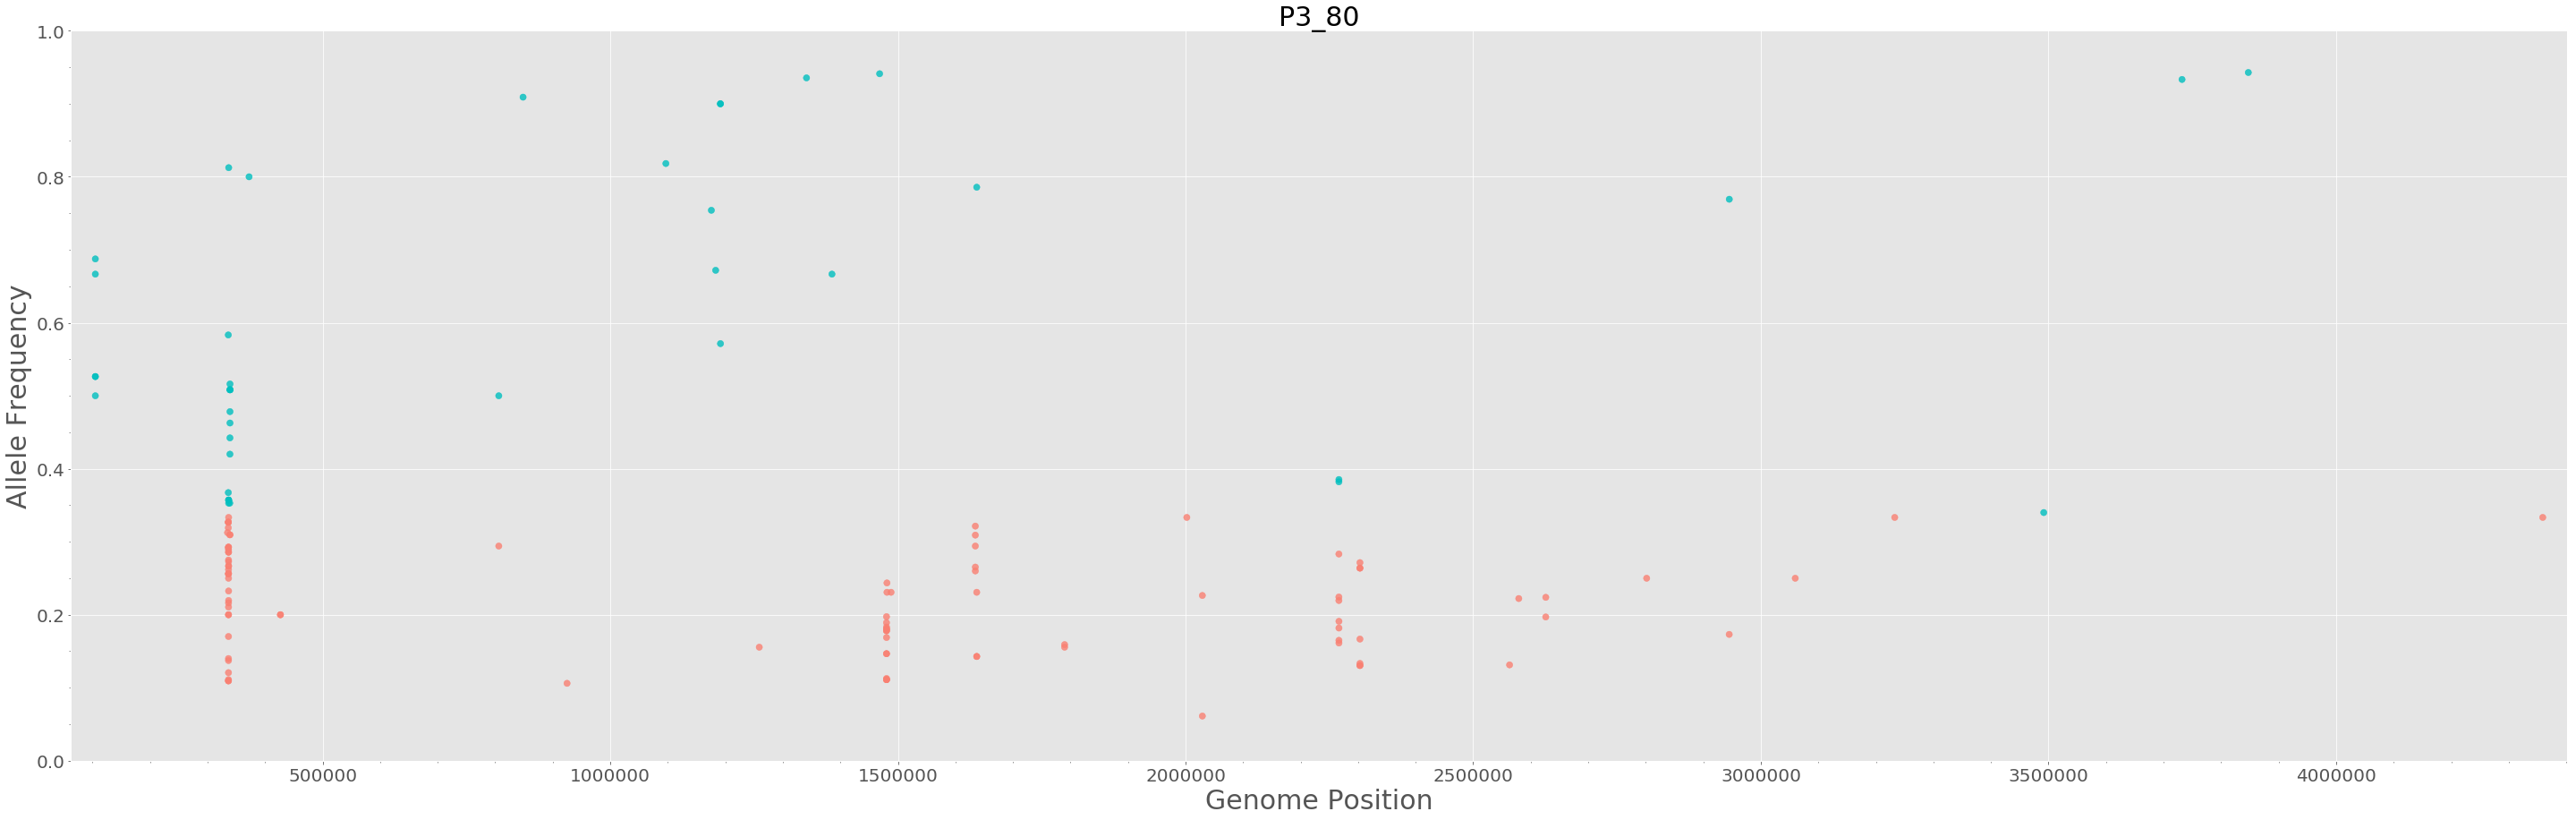

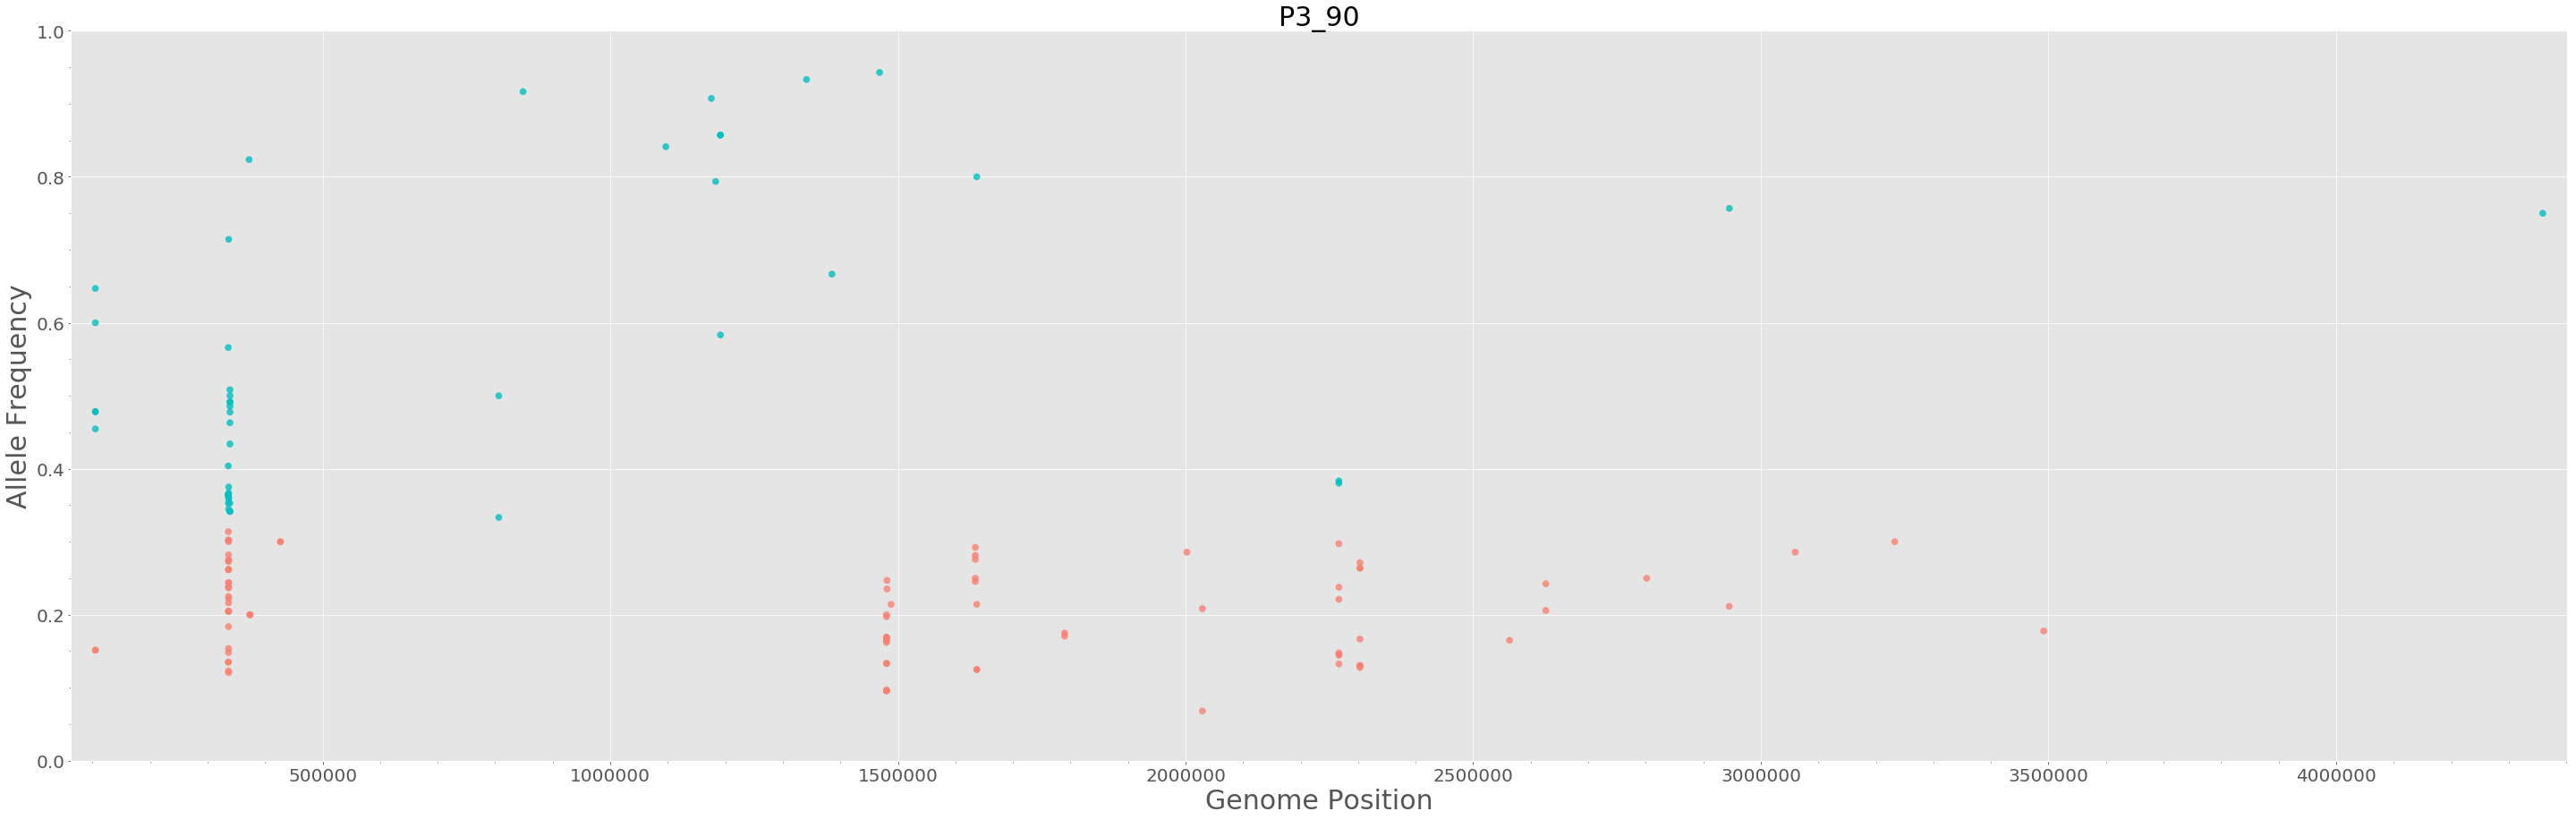

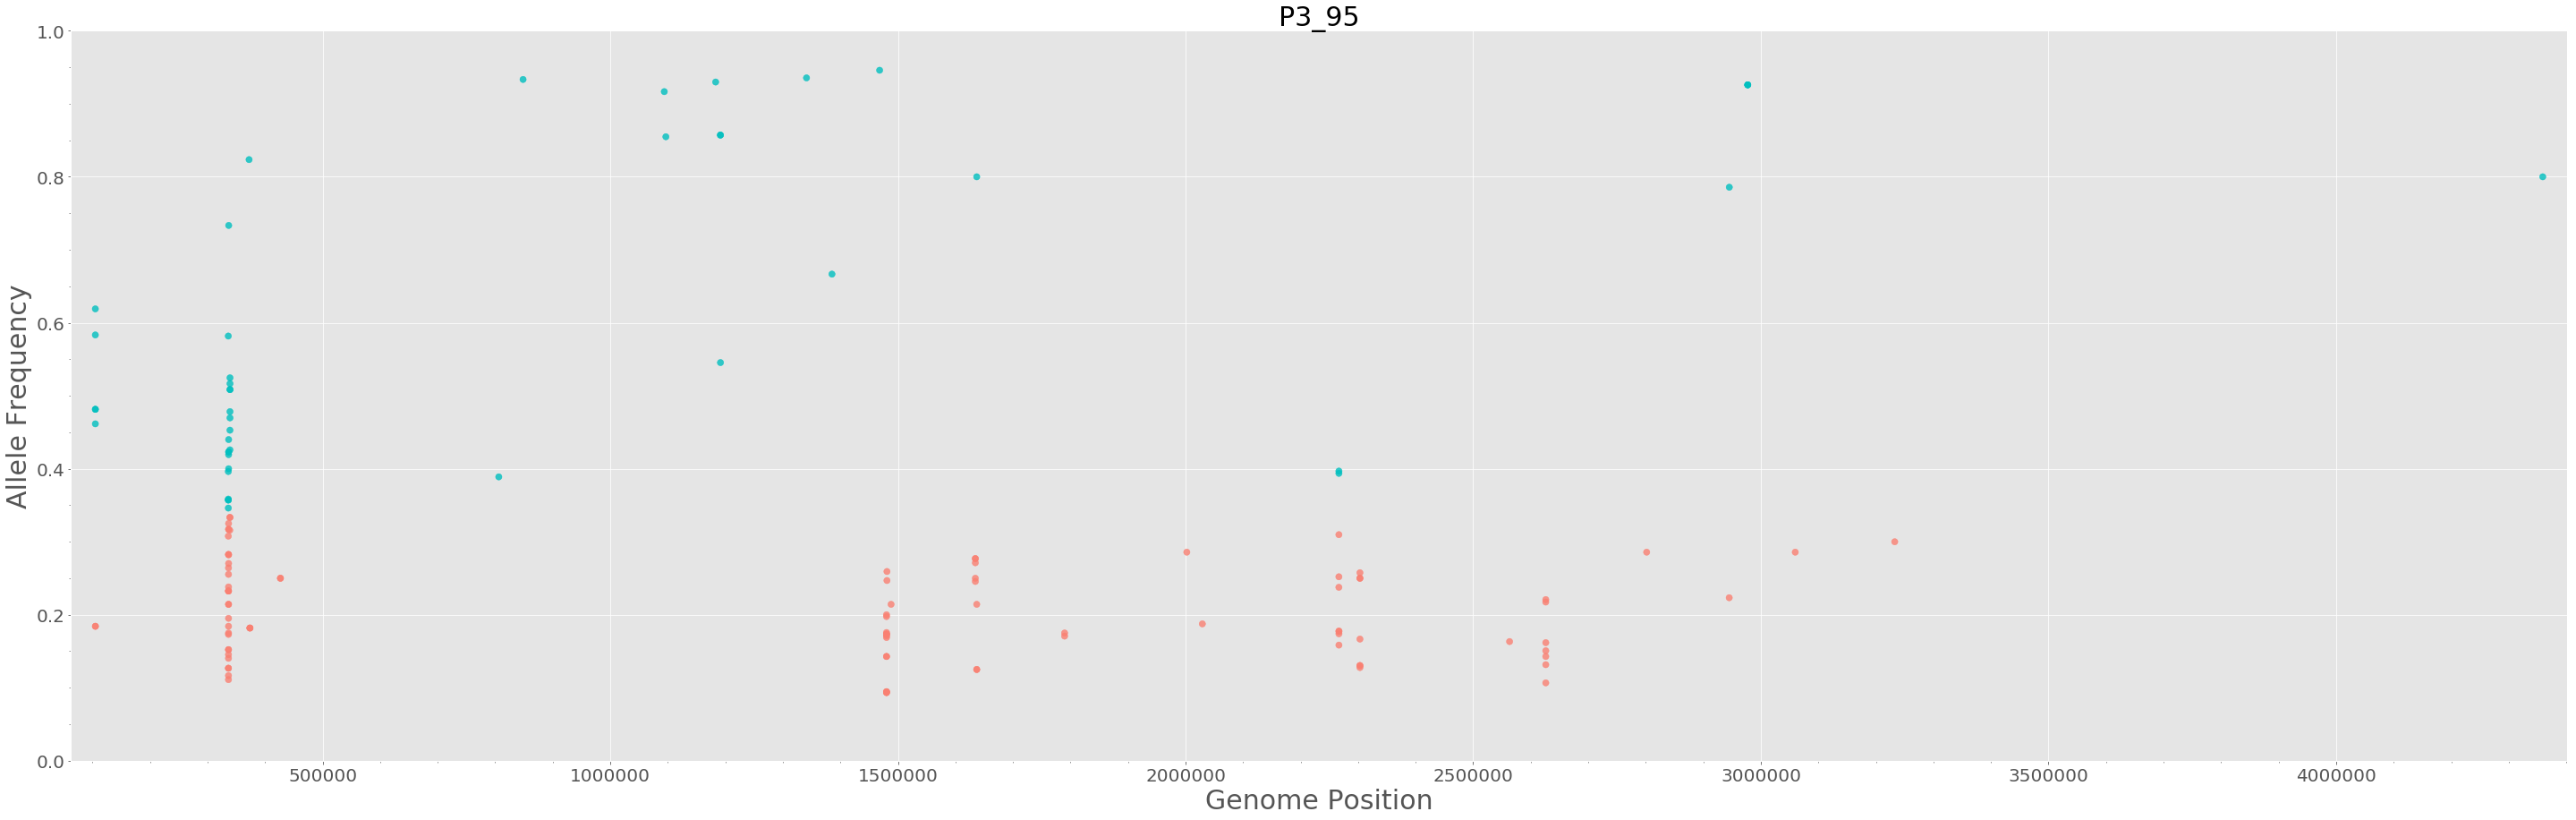

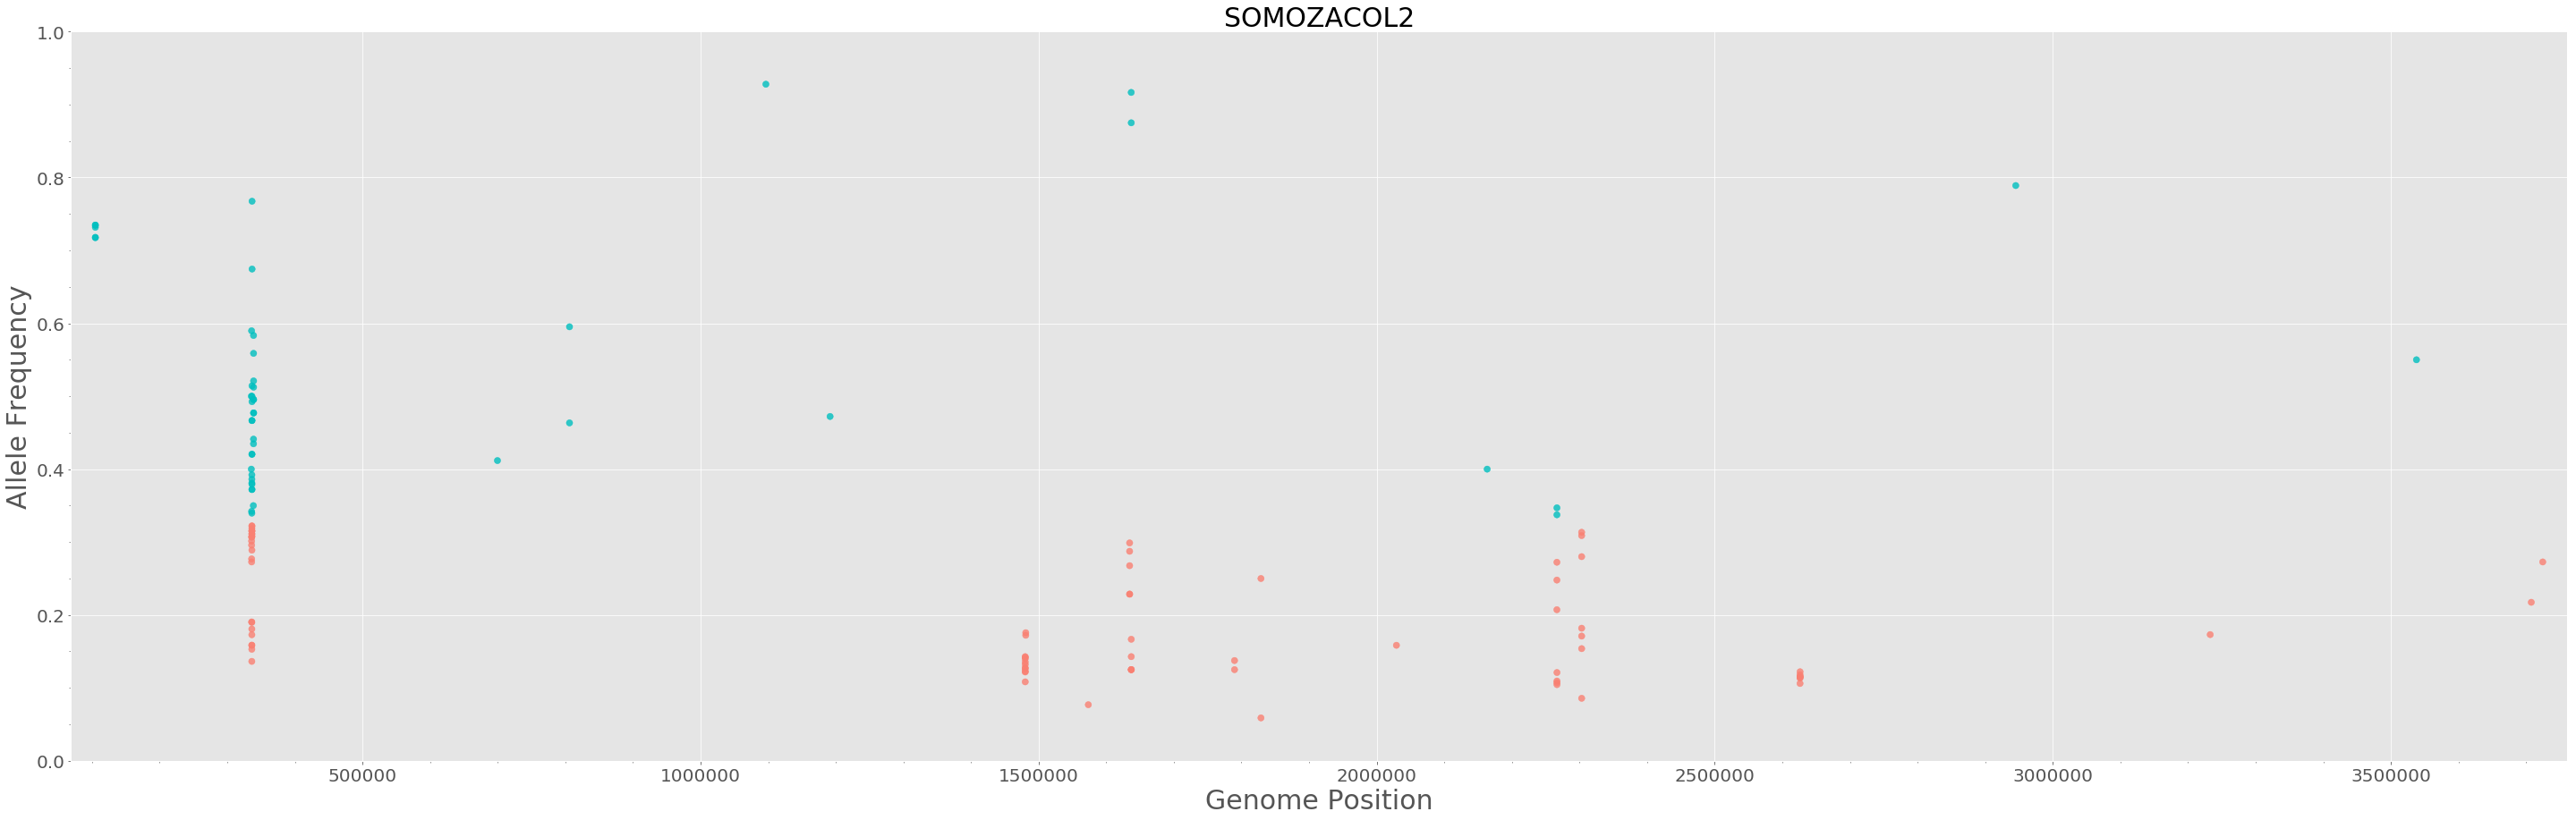

In [378]:
for name_dsf, df in dict_vcf.items():
    scatter_vcf_pos(df,name_dsf)

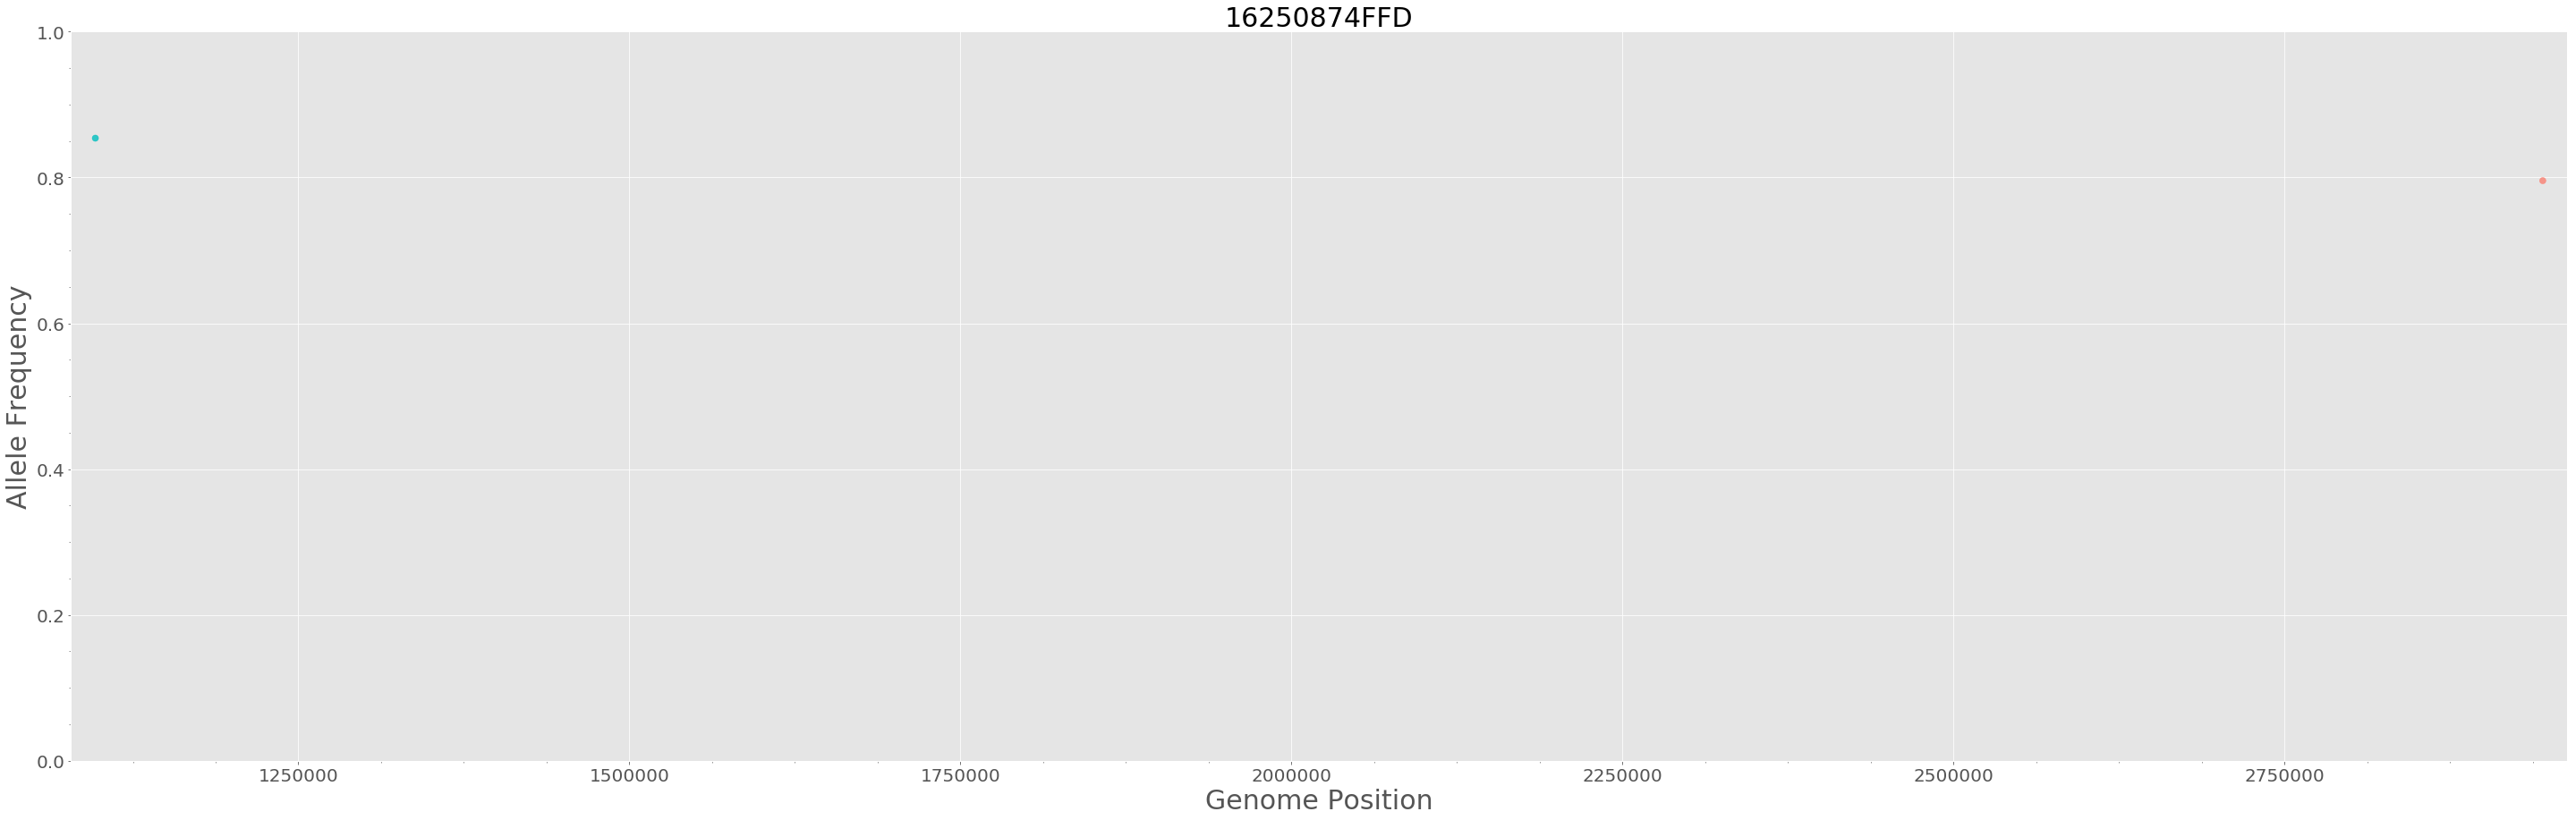

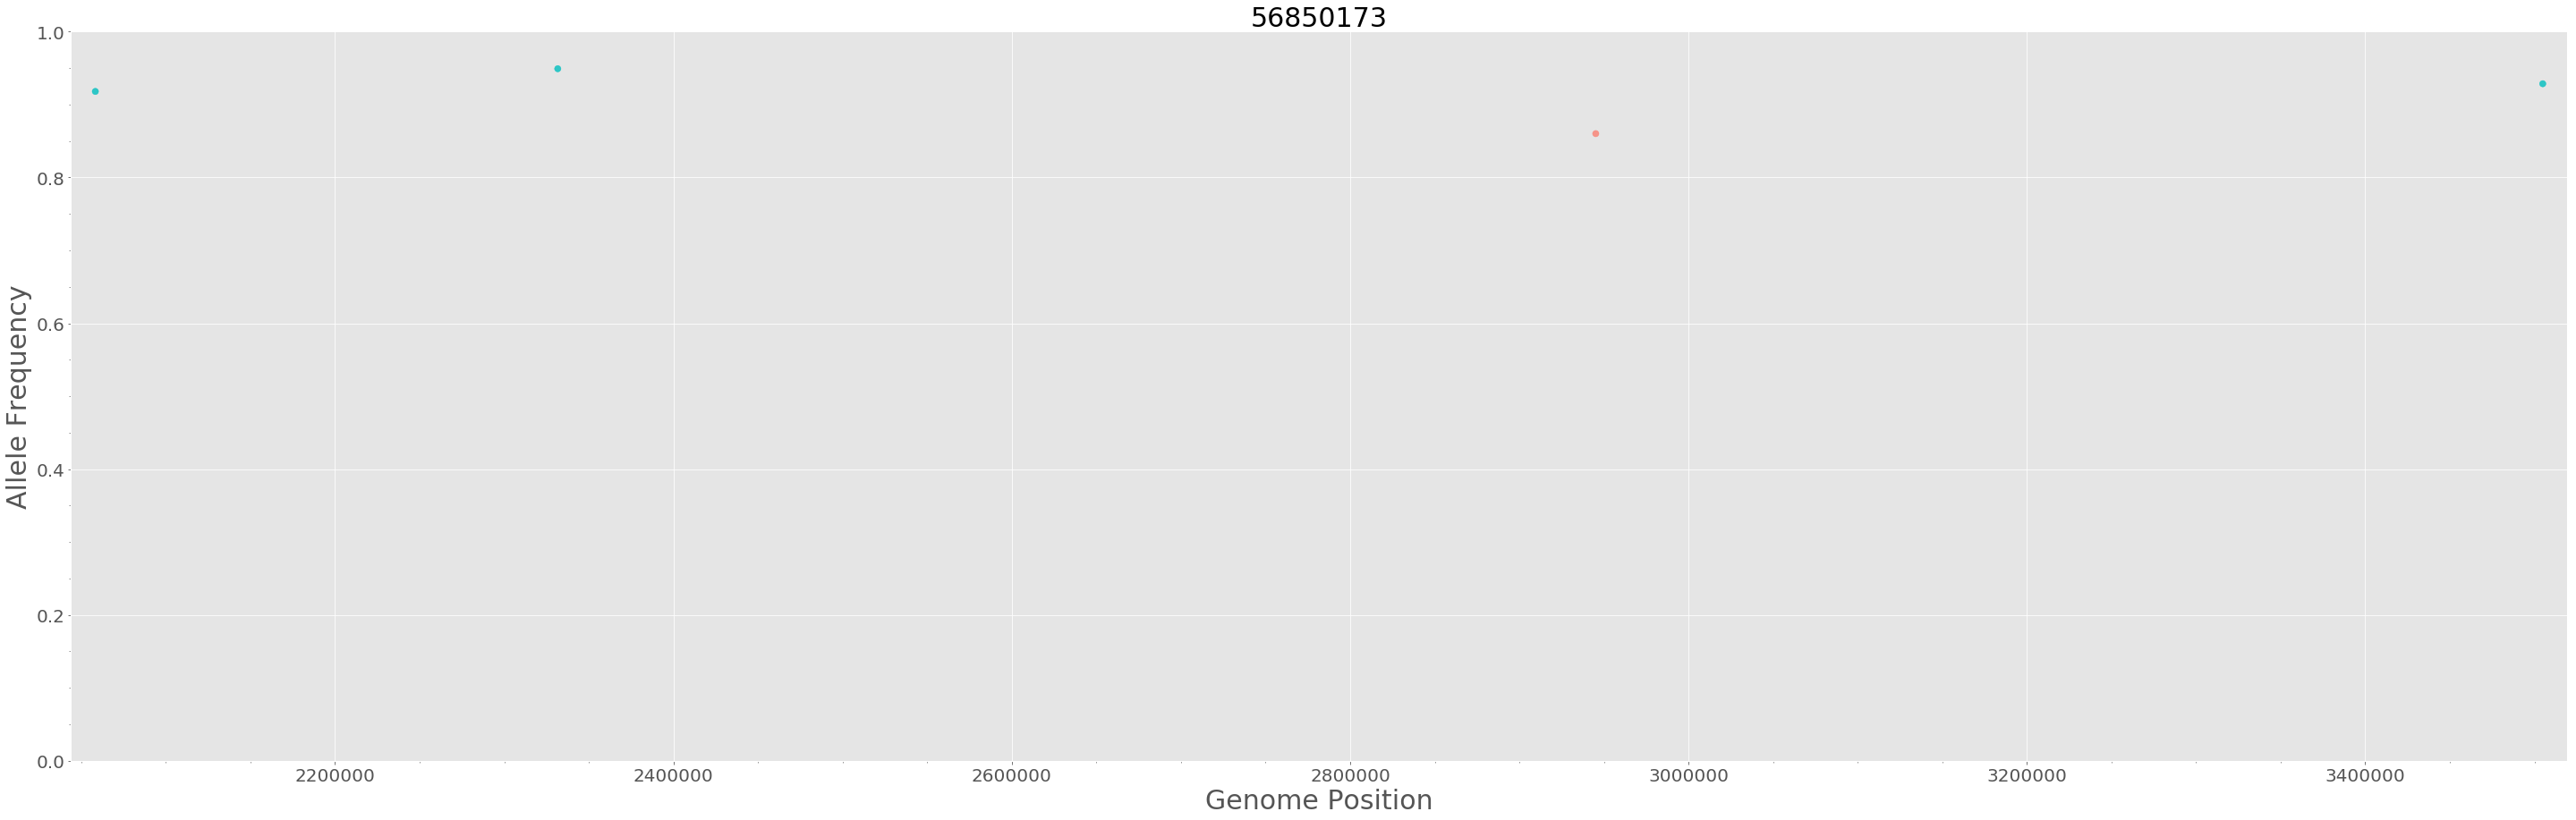

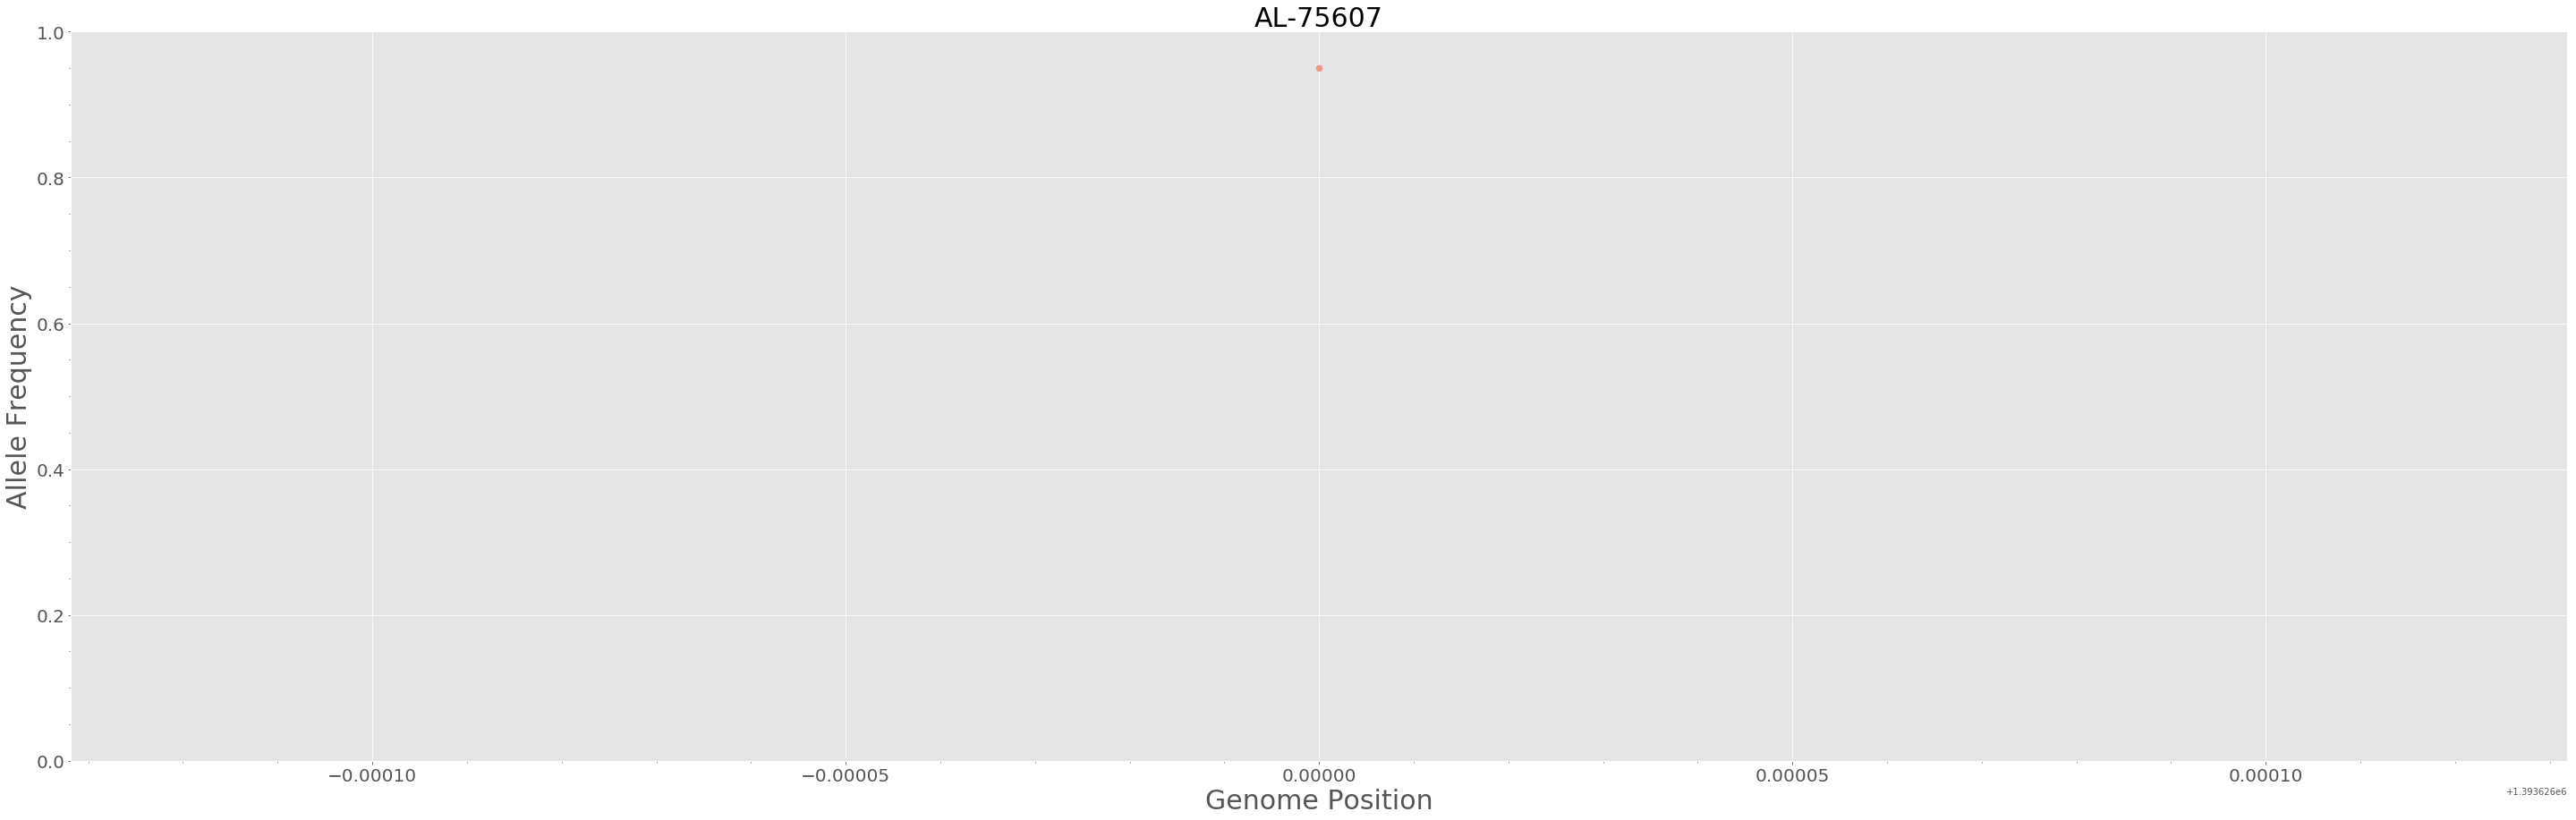

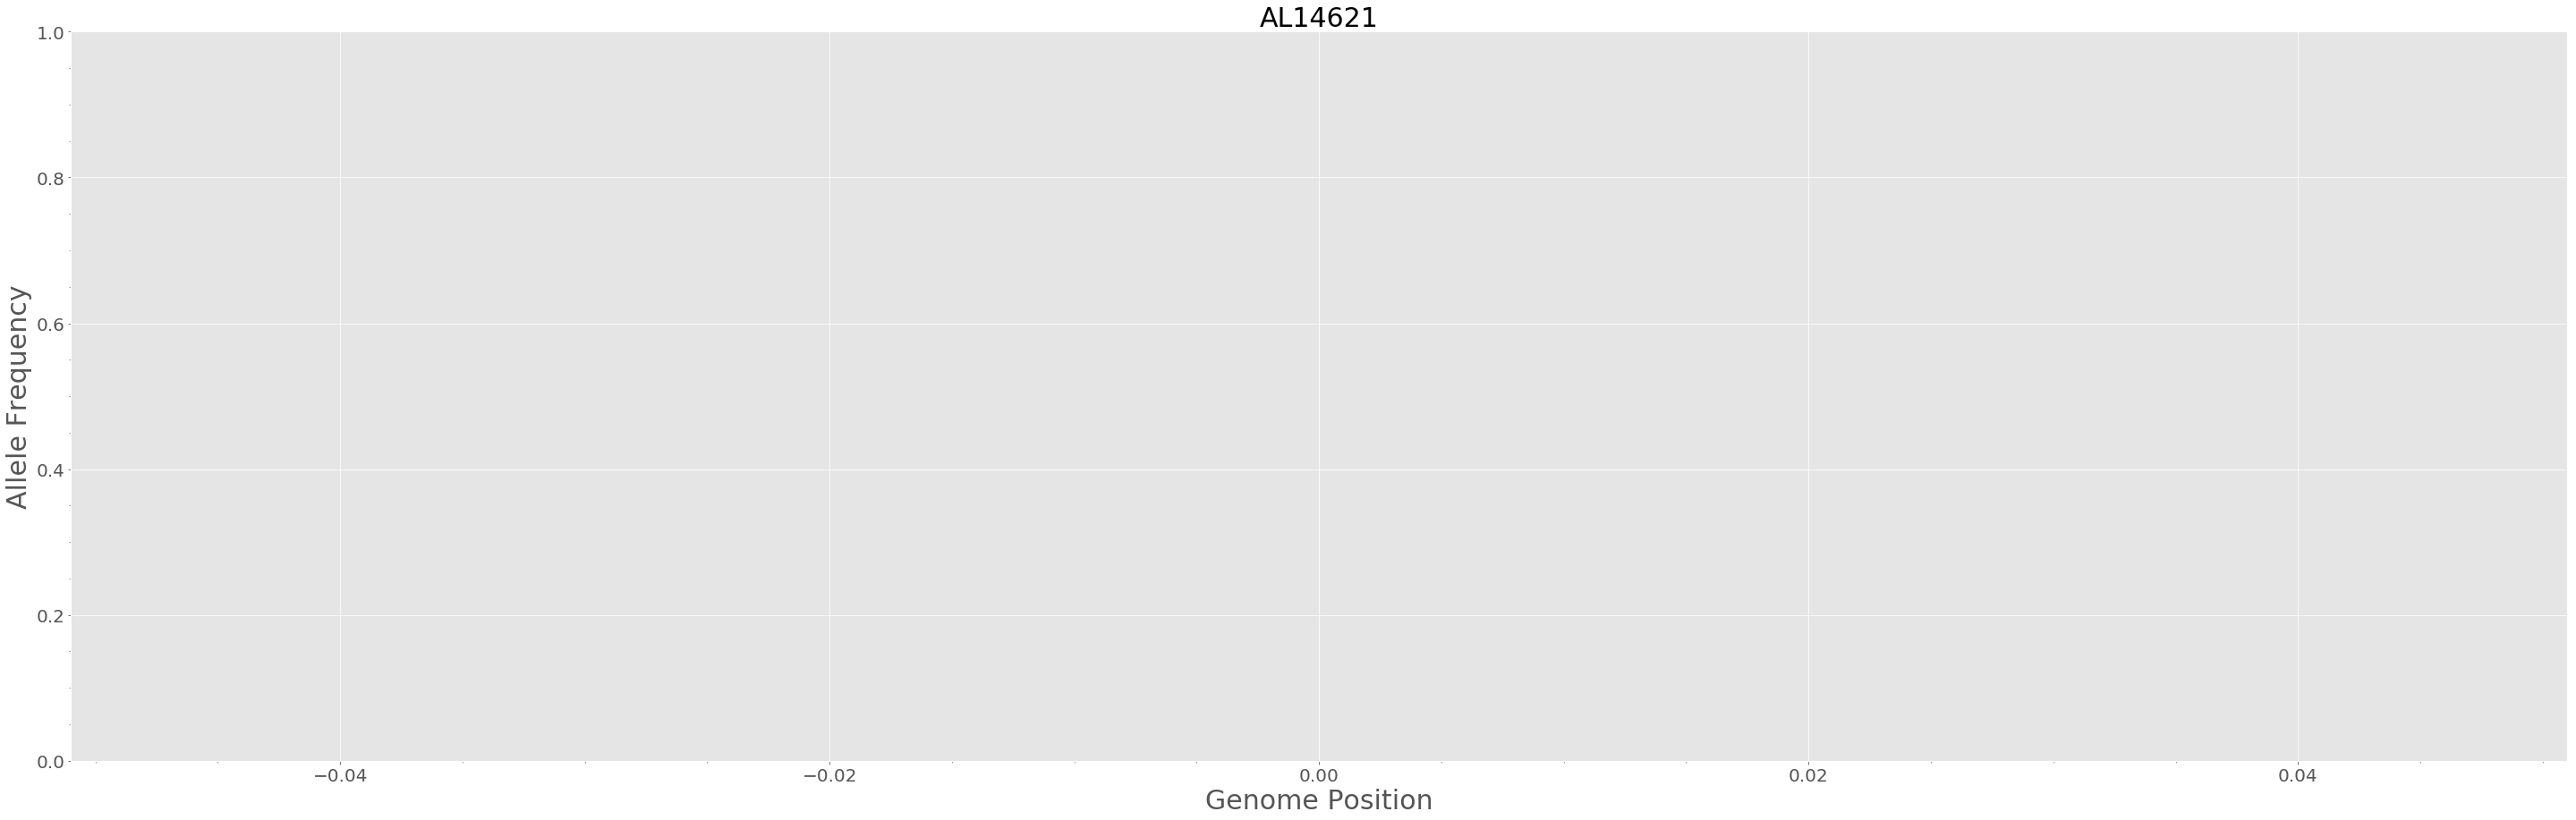

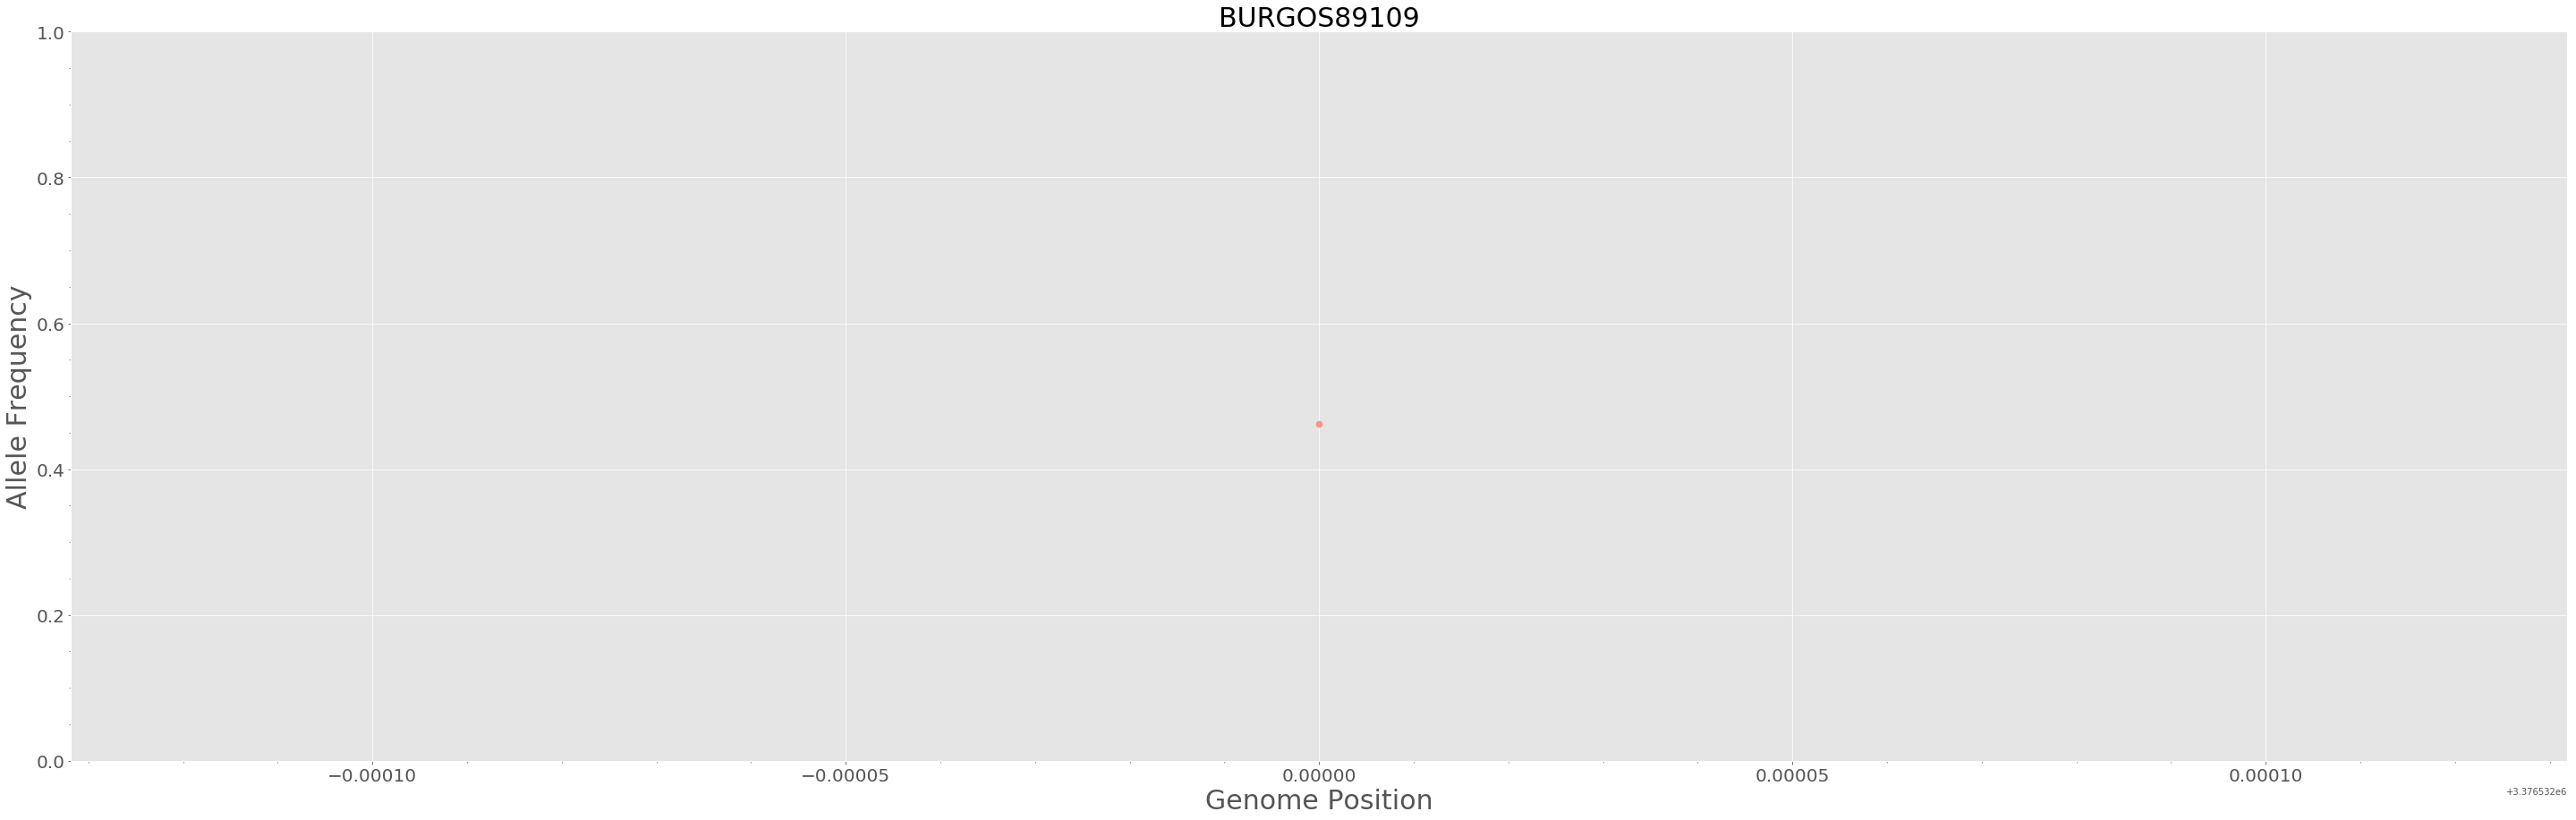

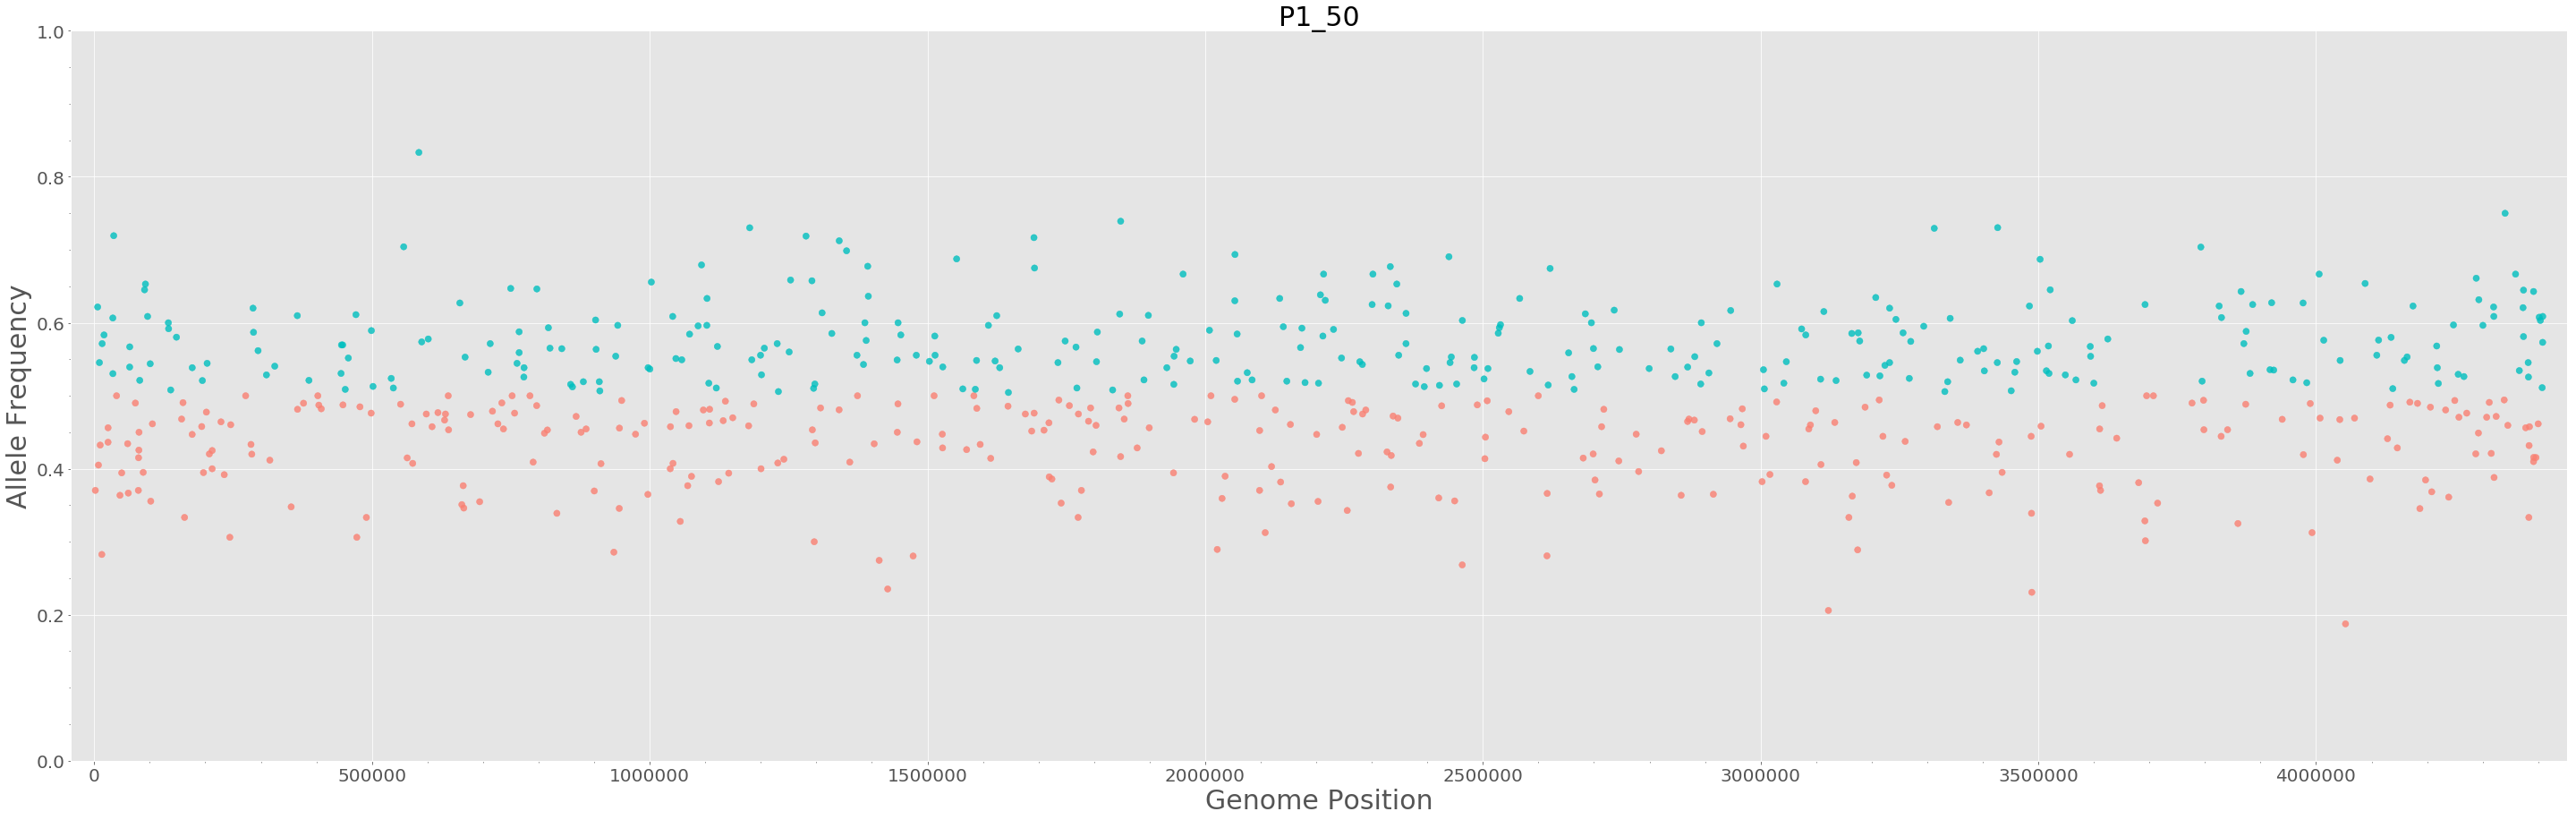

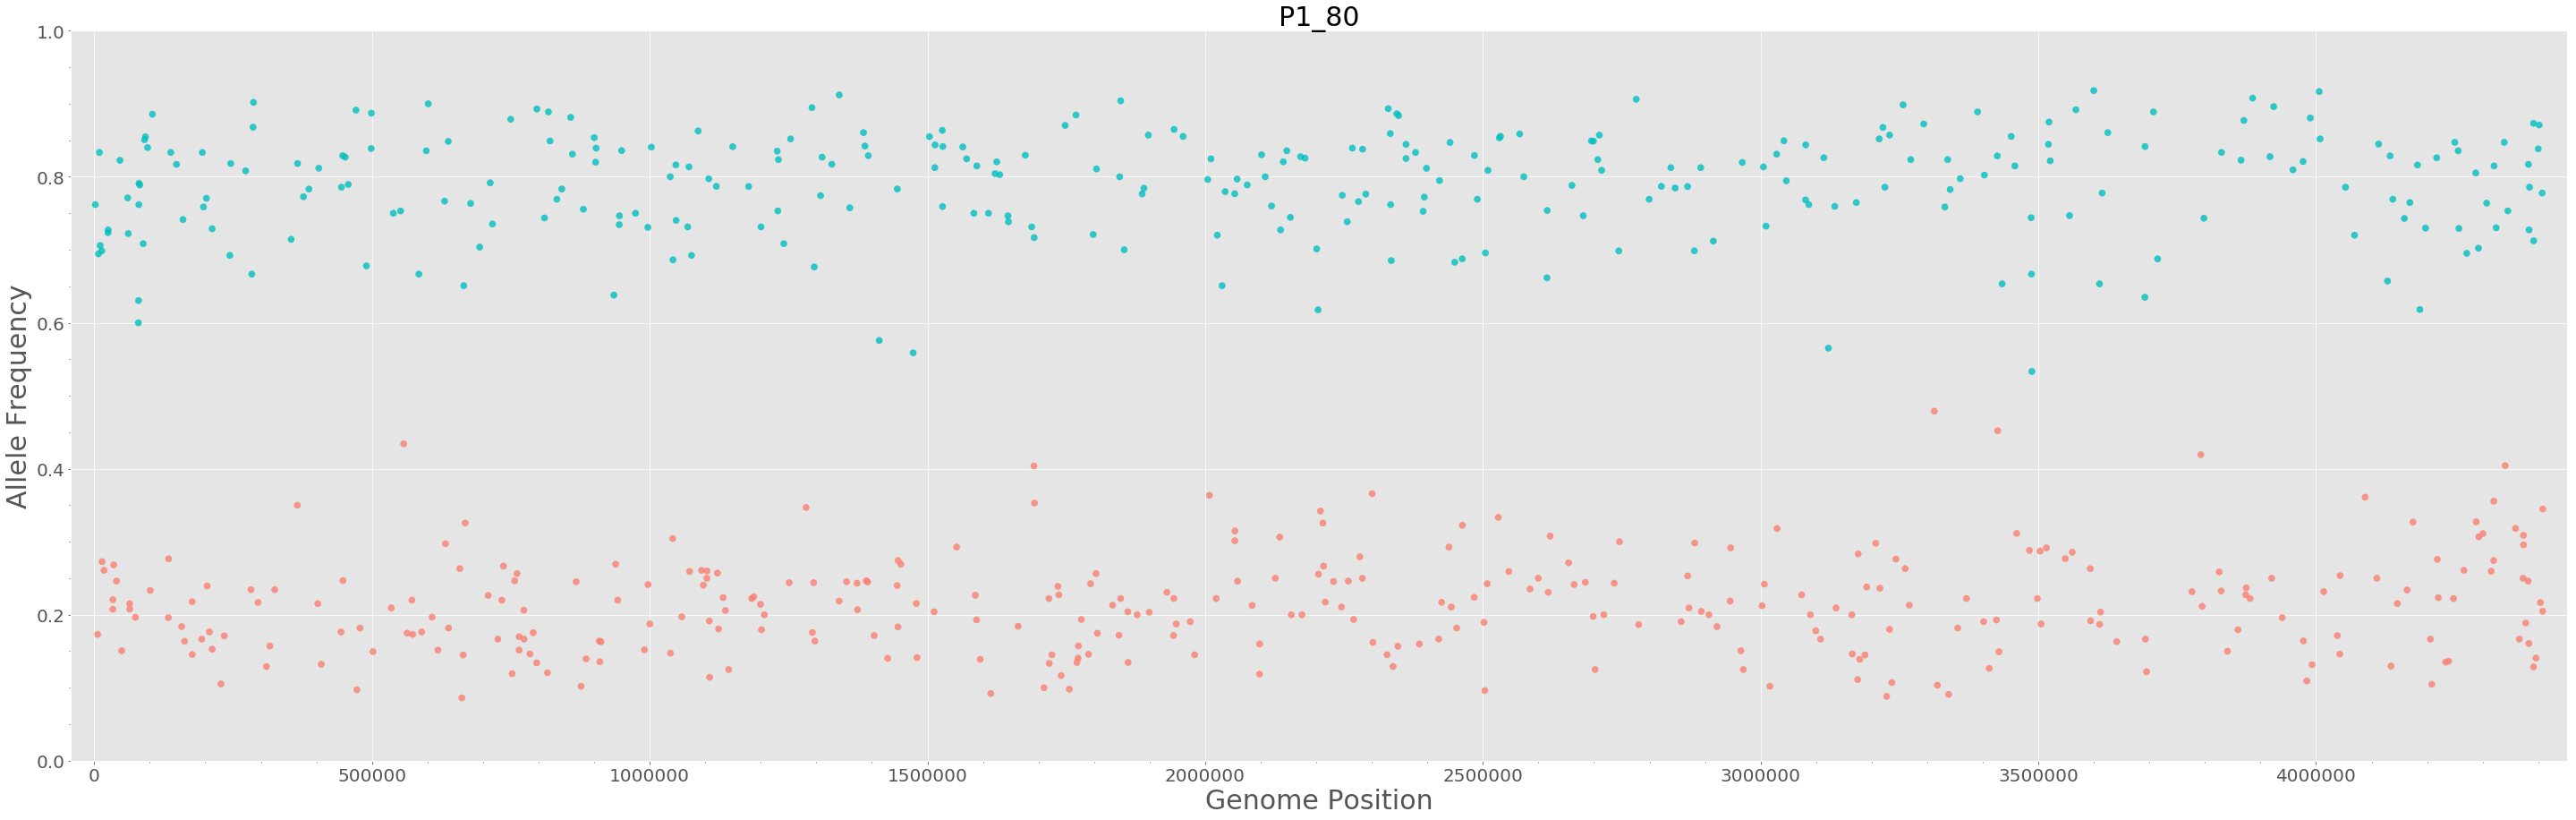

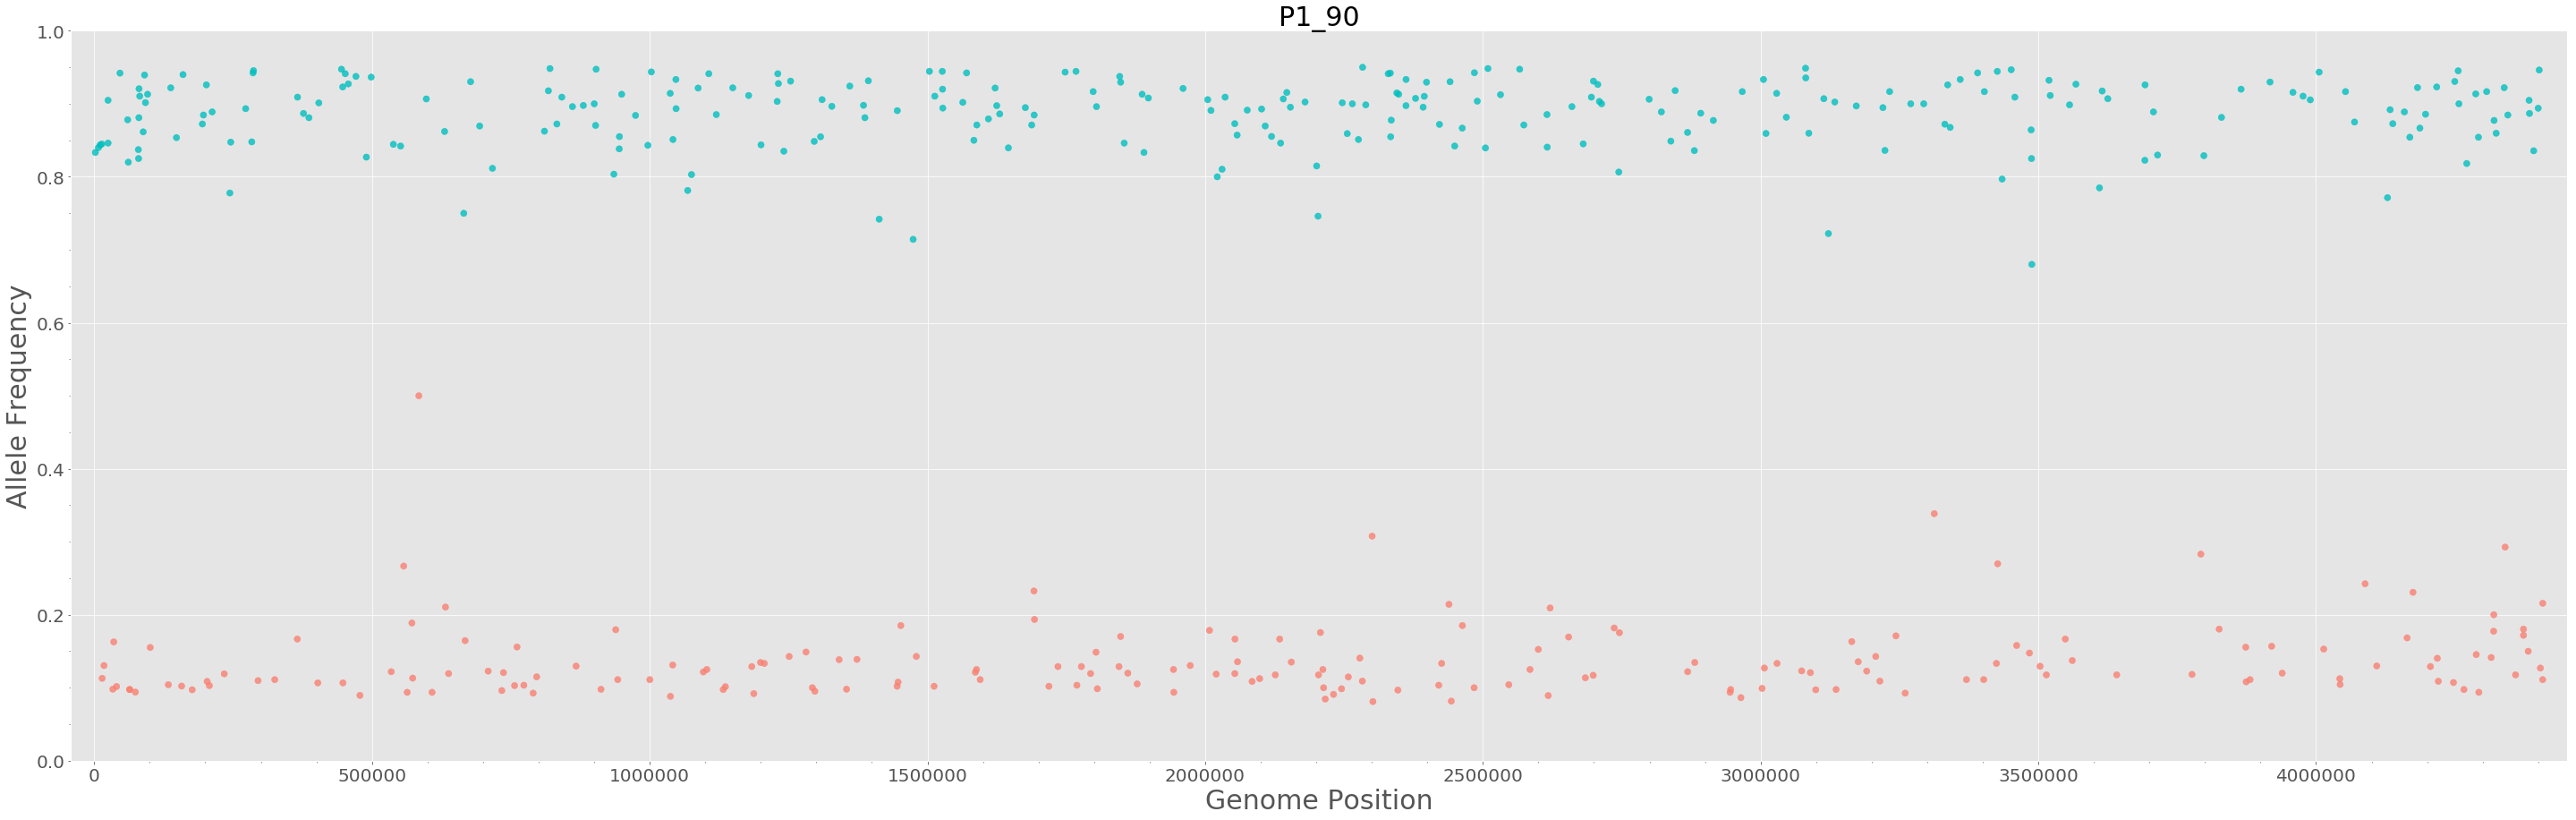

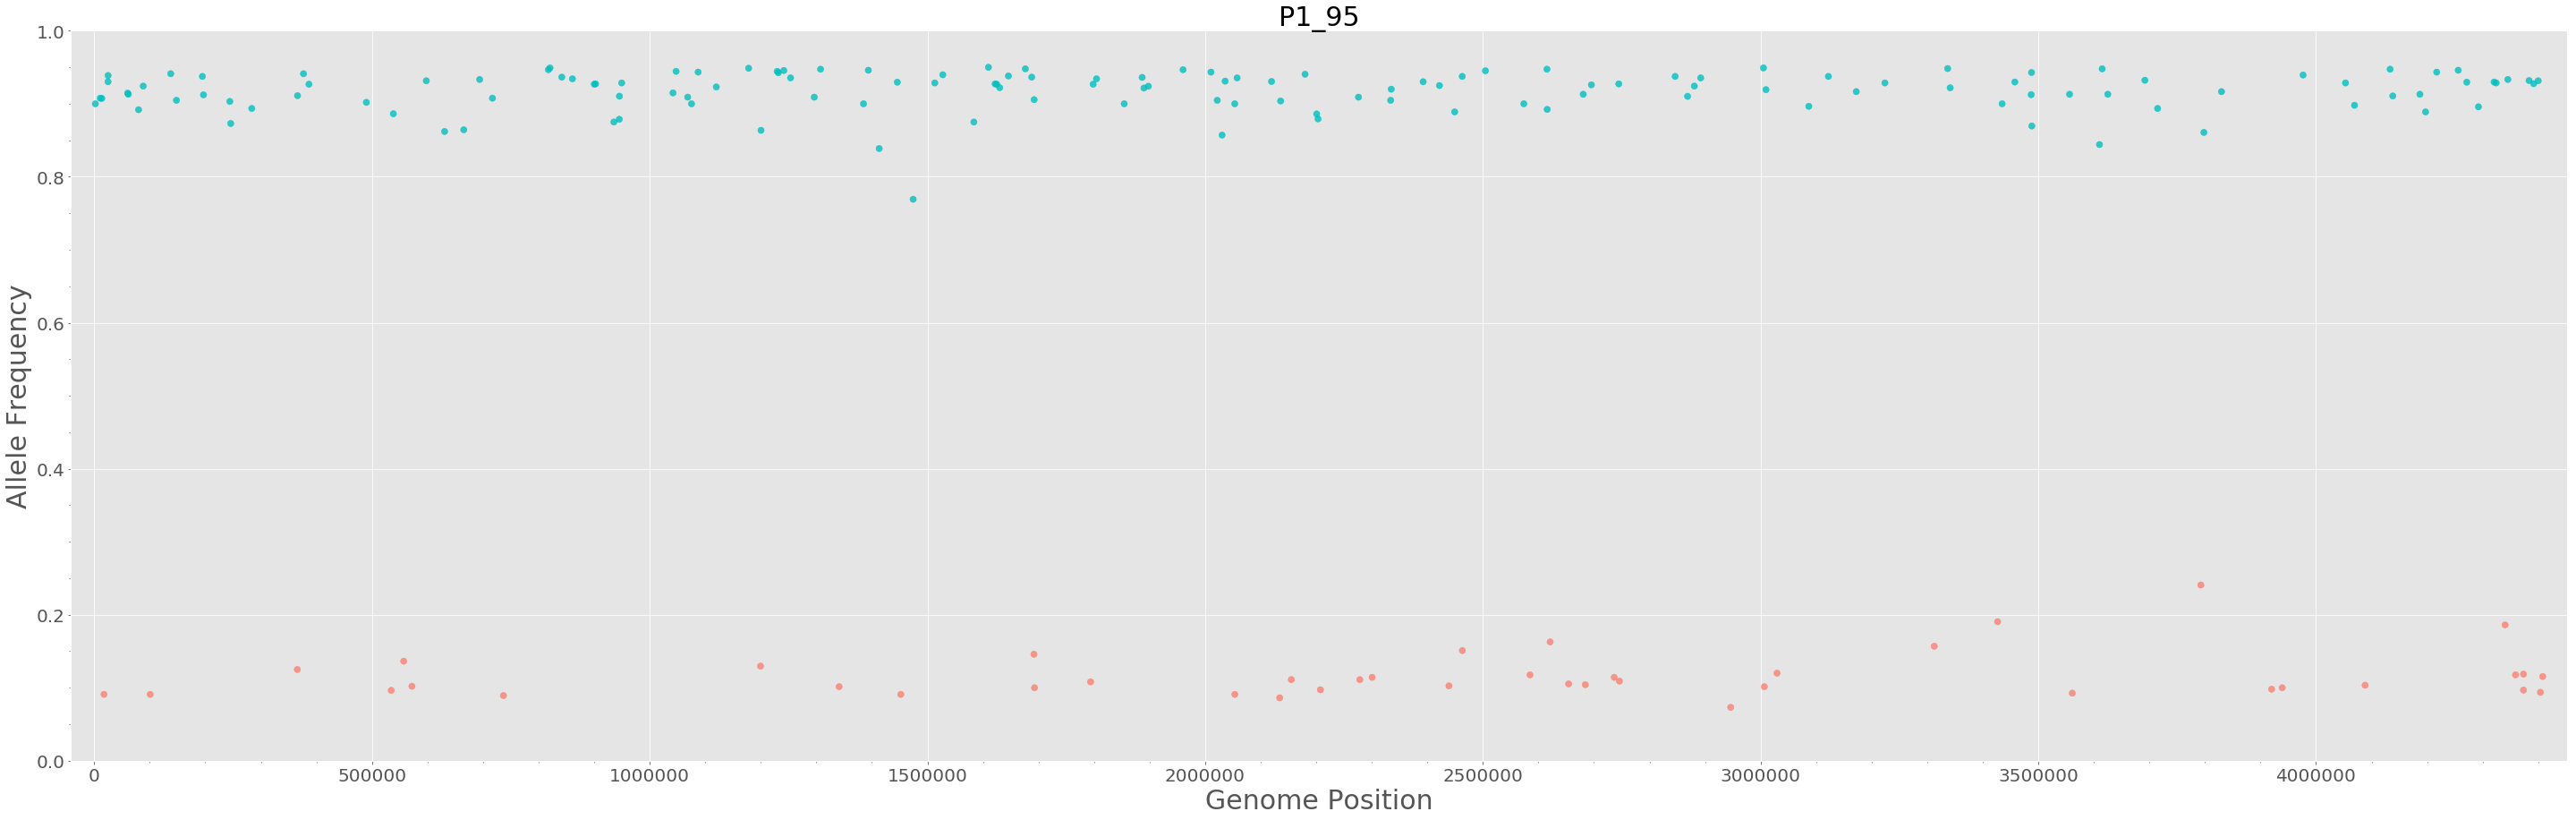

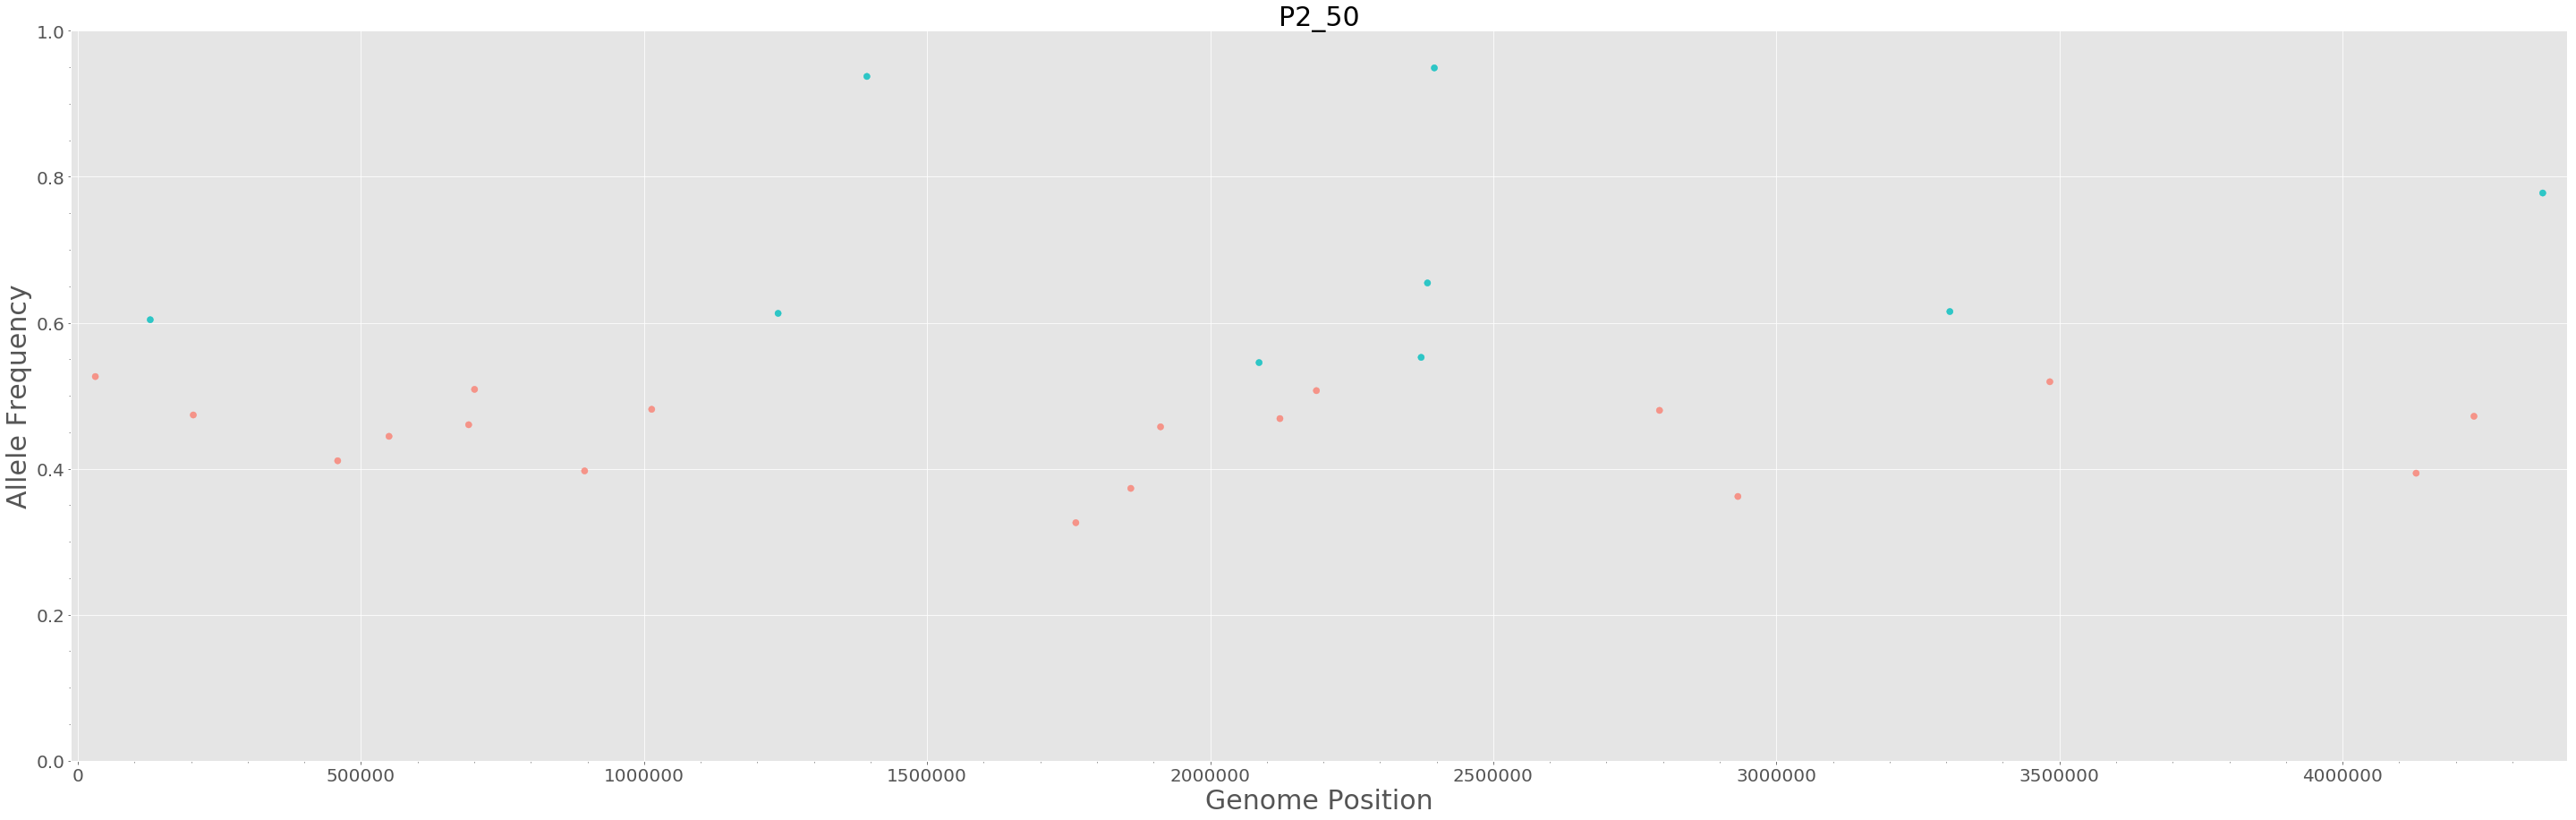

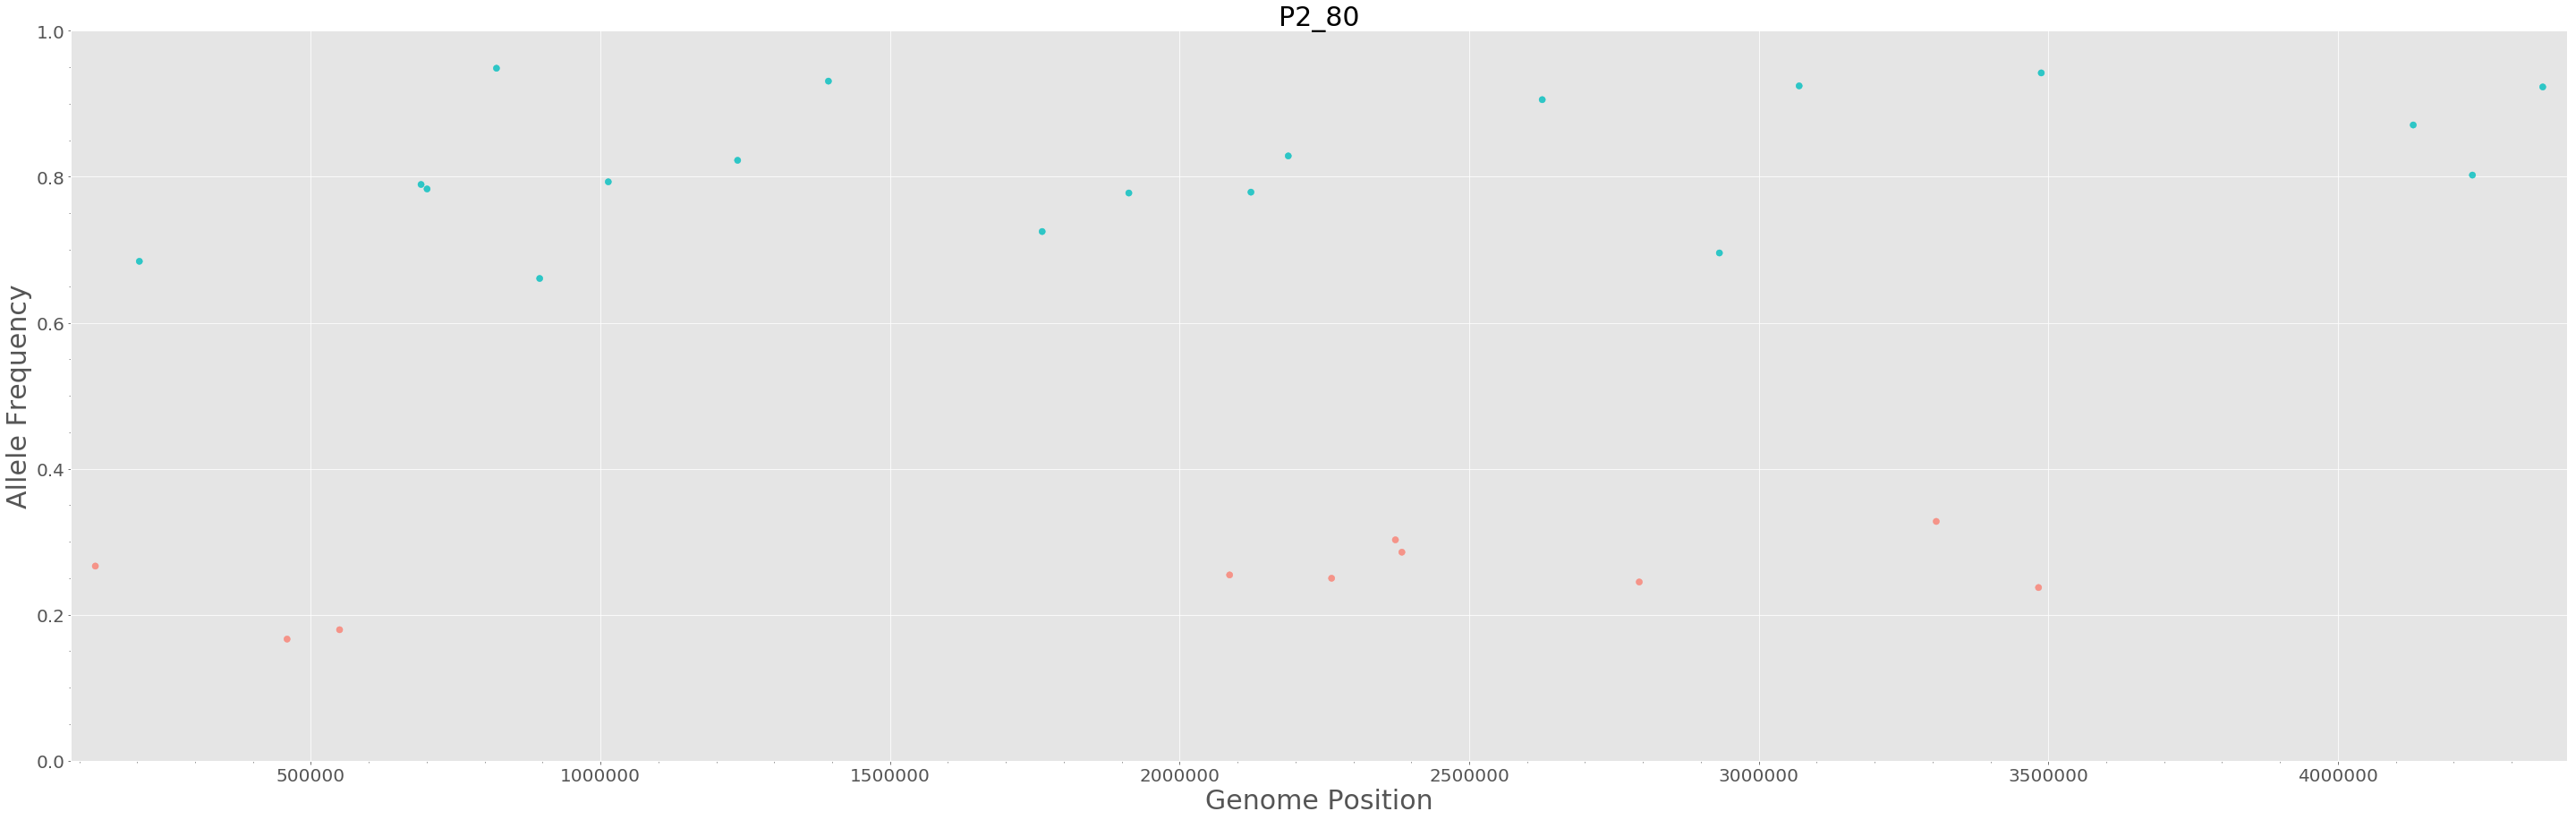

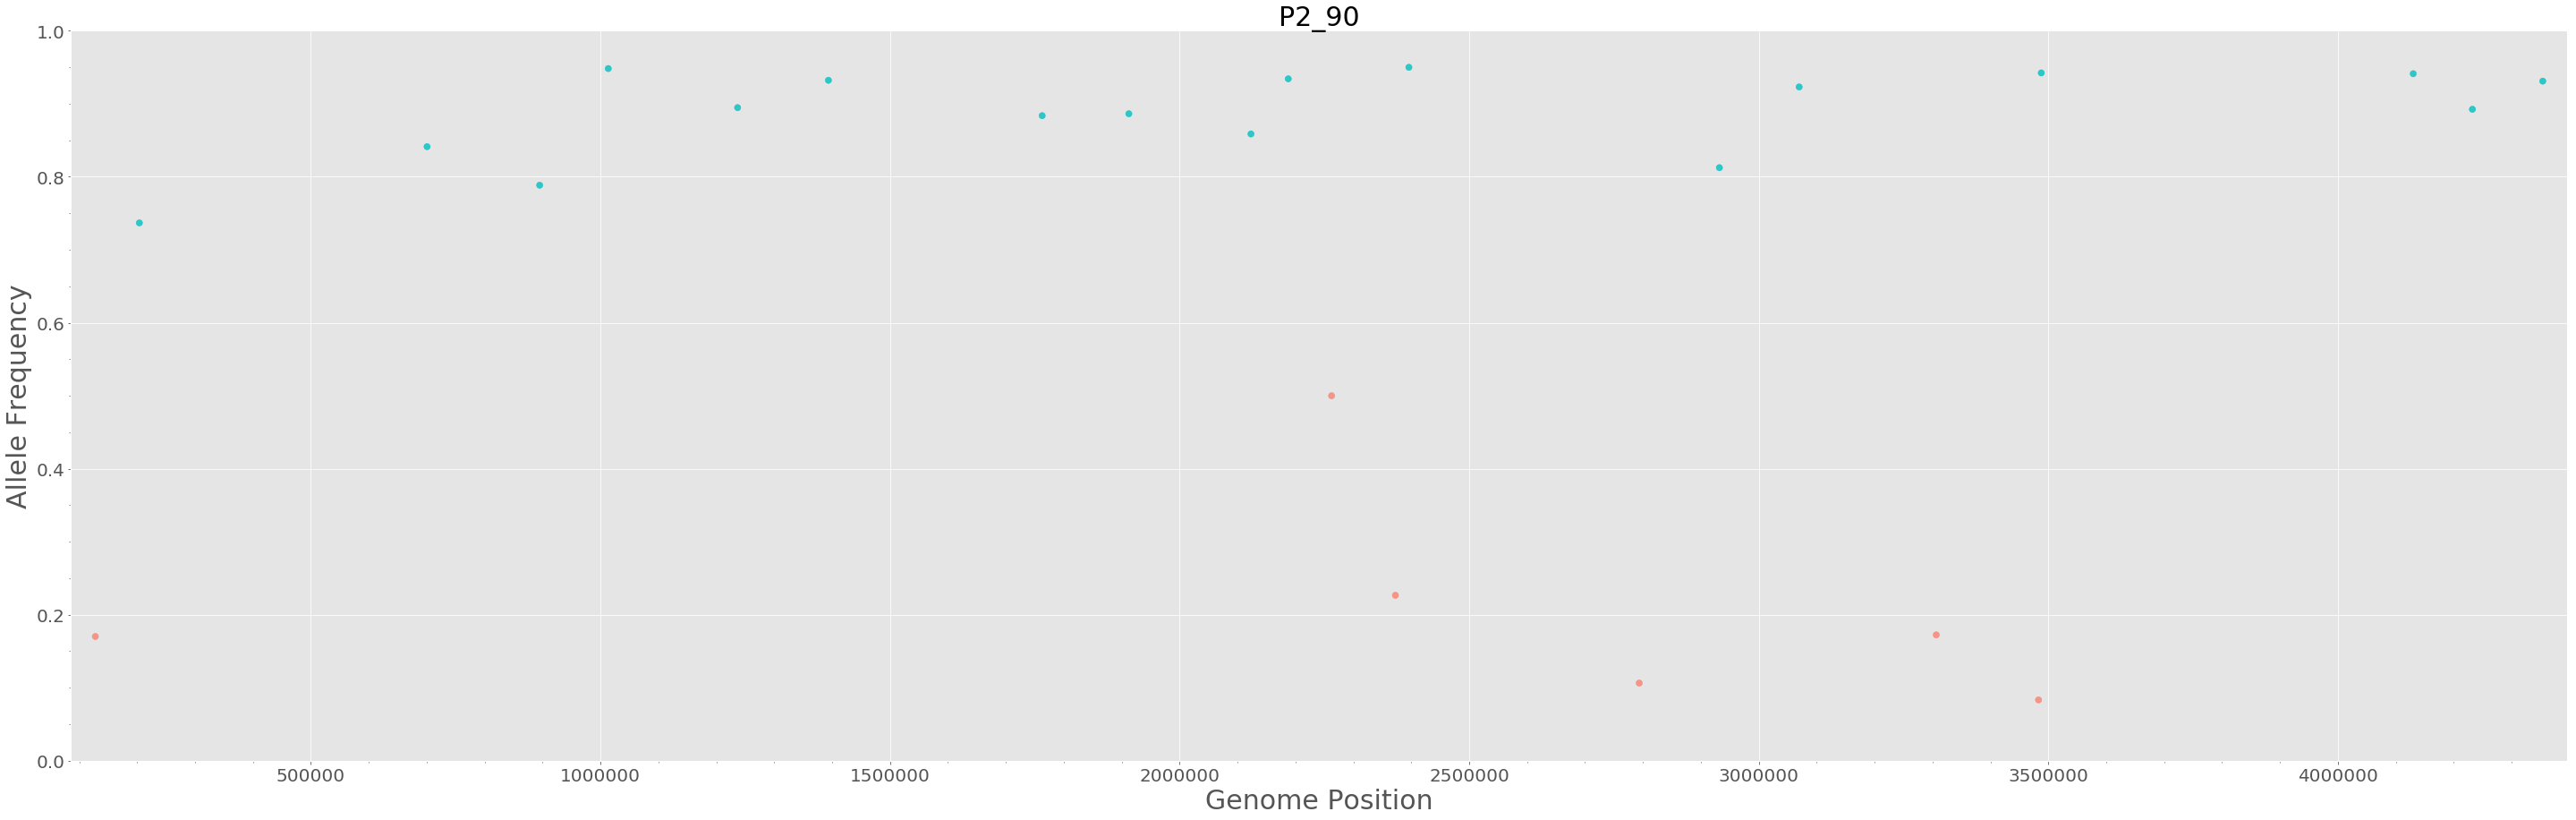

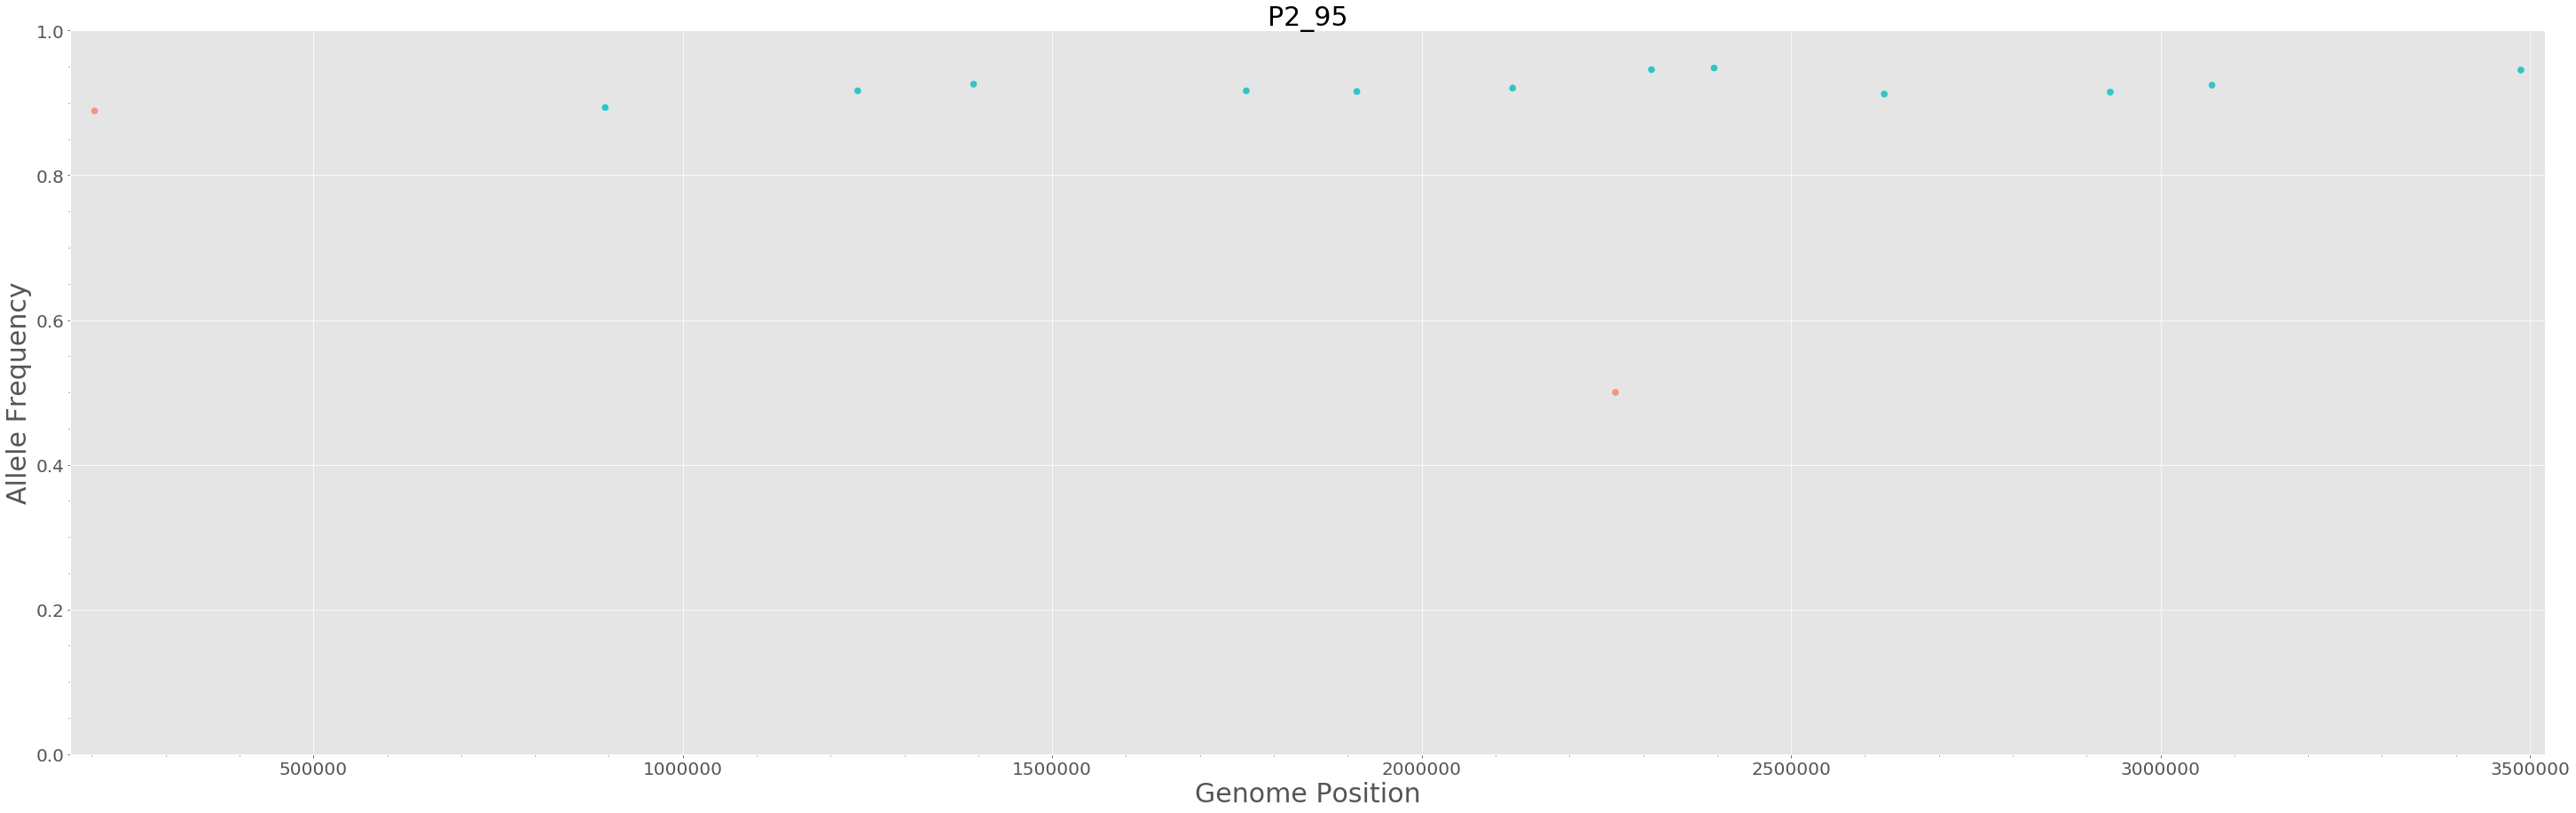

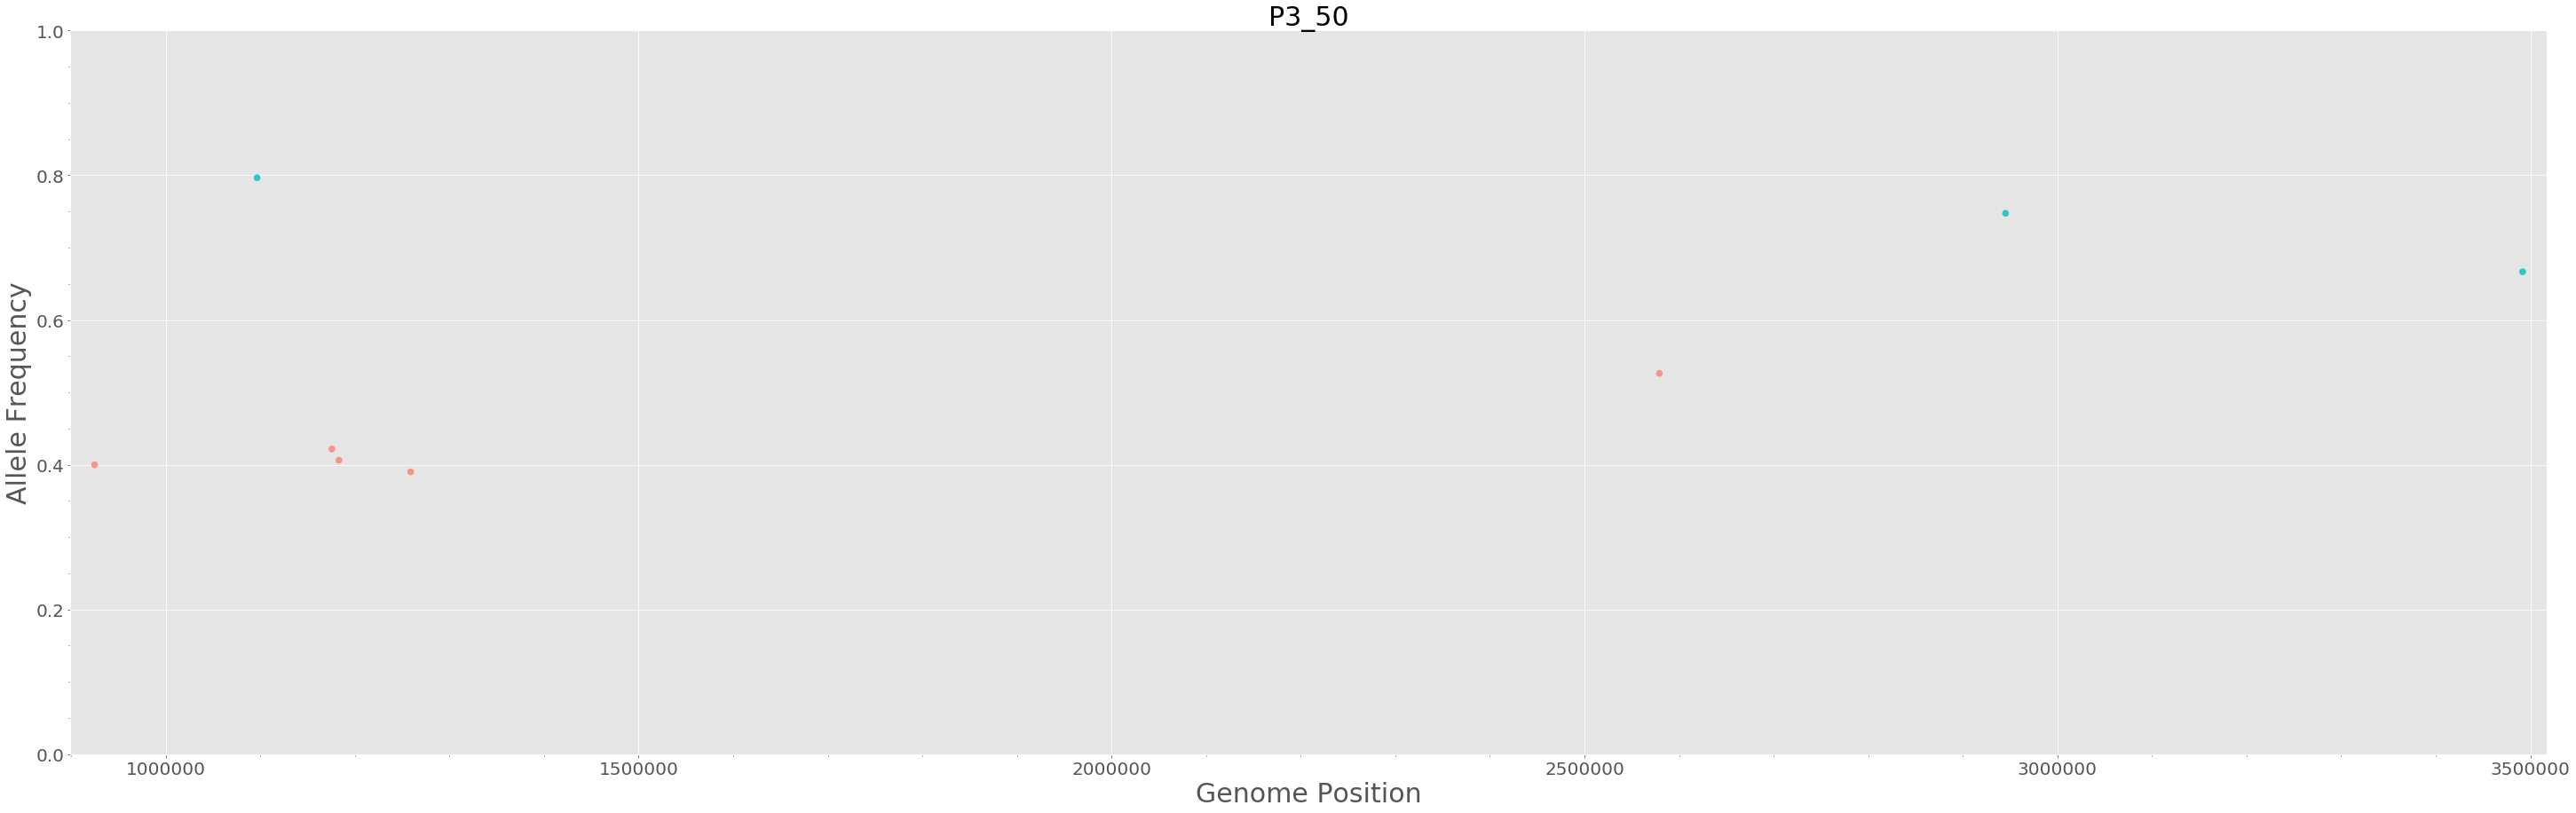

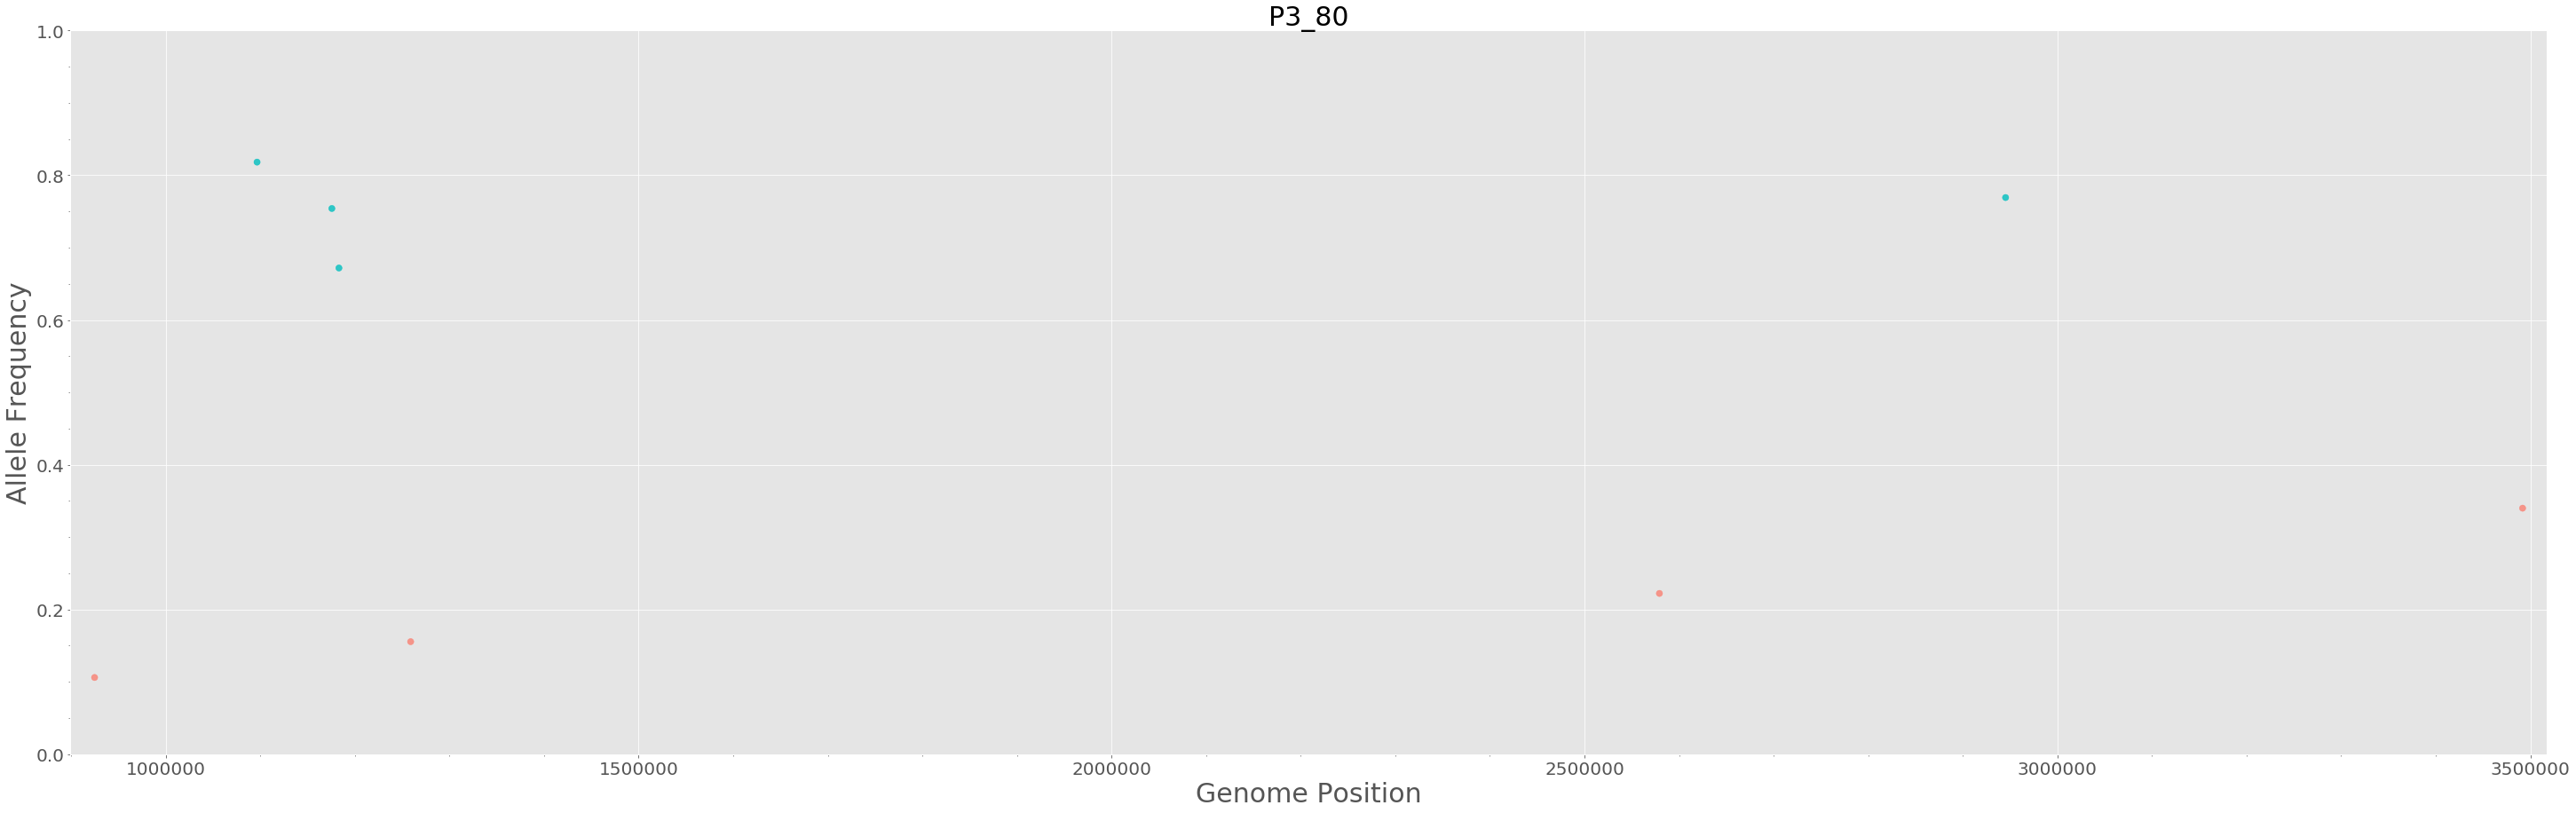

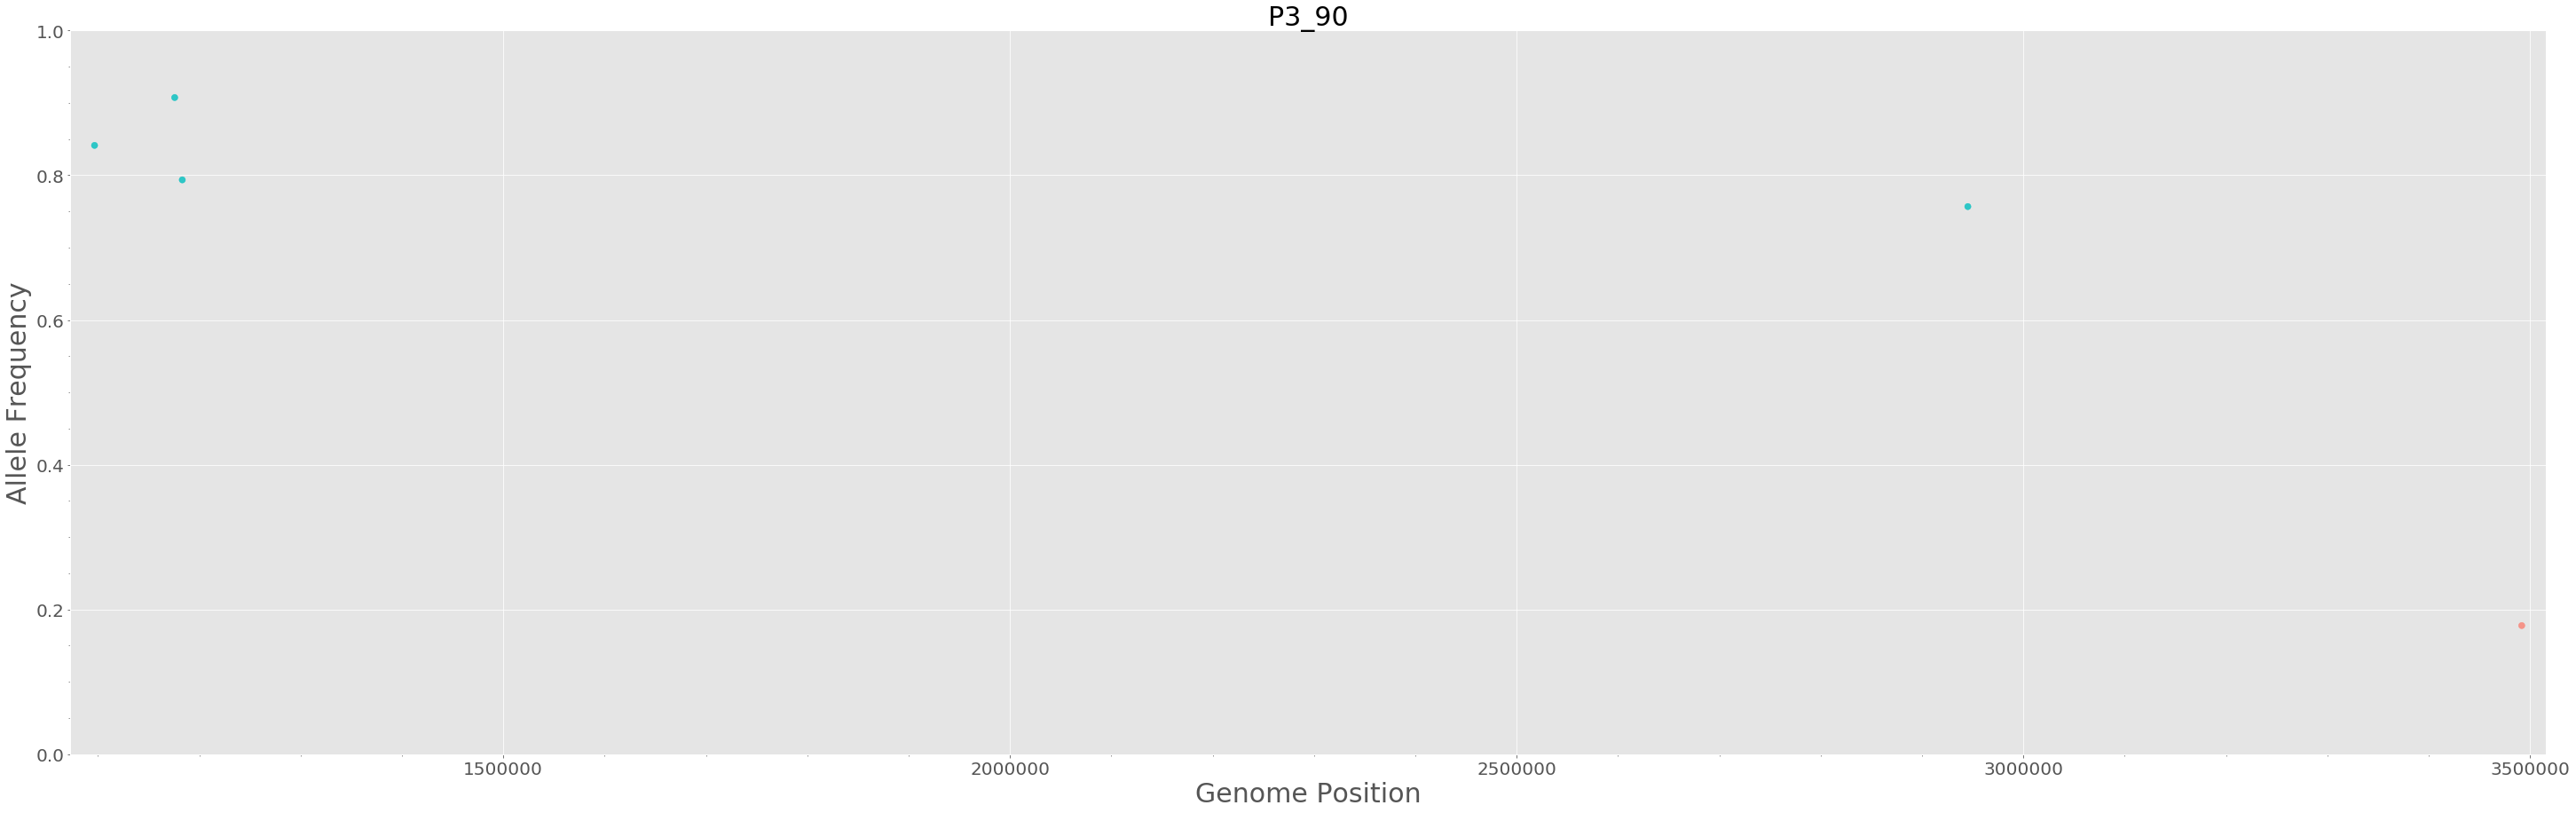

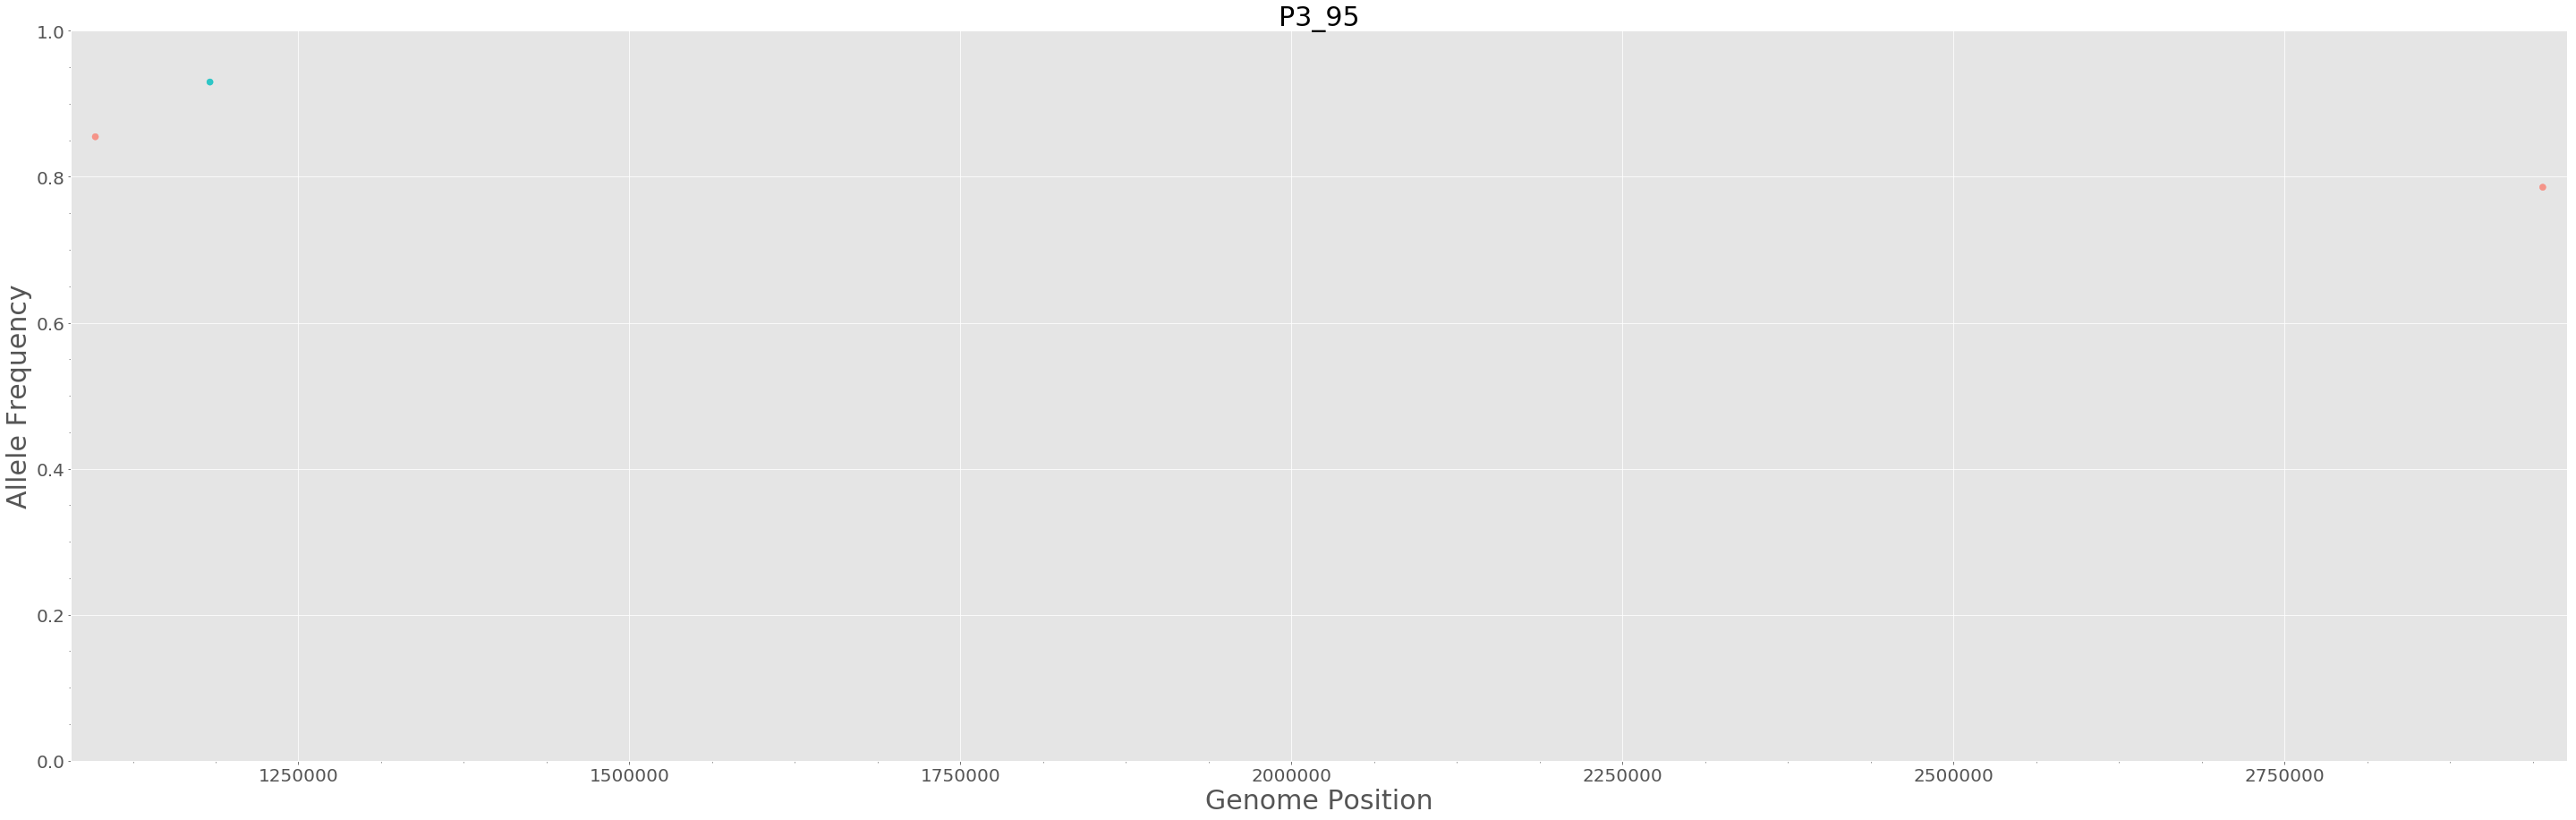

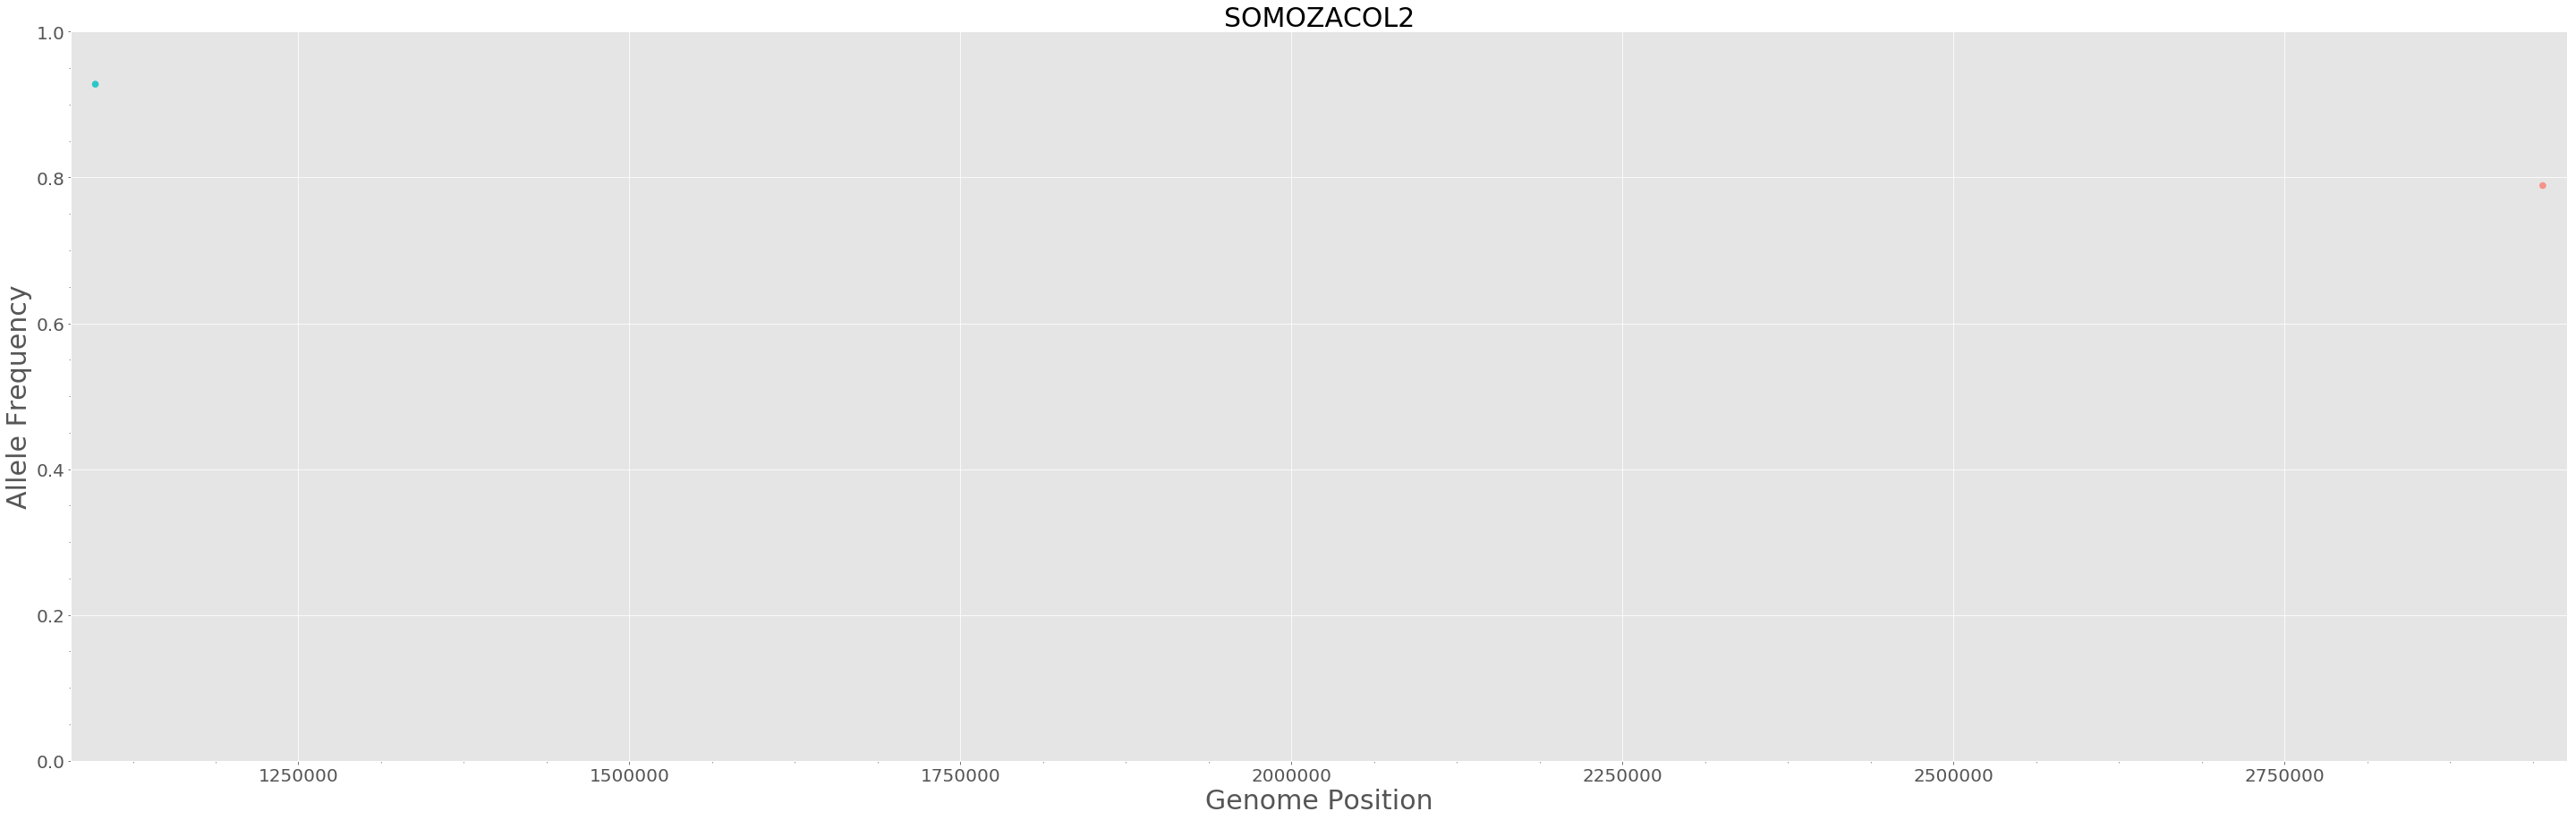

In [379]:
for name_dsf, df in dict_dff.items():
    scatter_vcf_pos(df,name_dsf, 0.98)

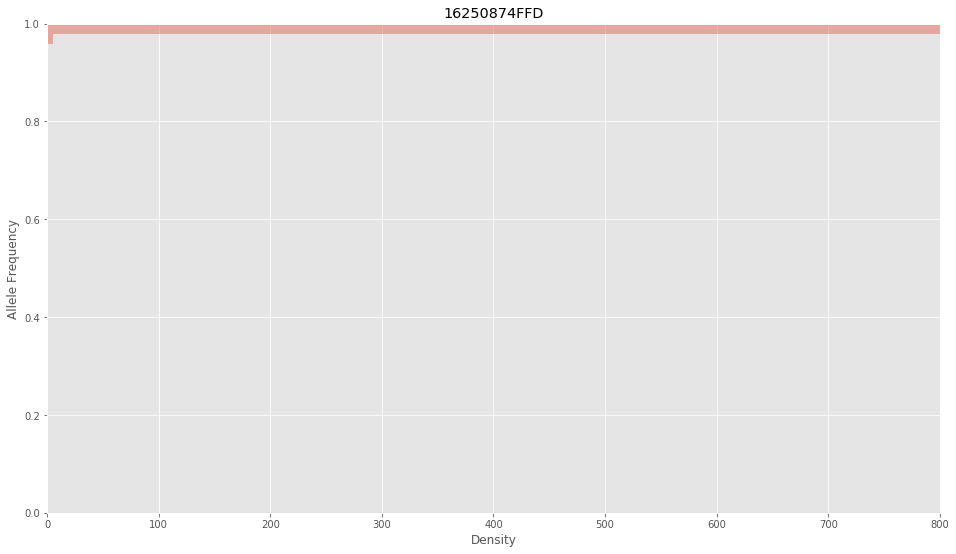

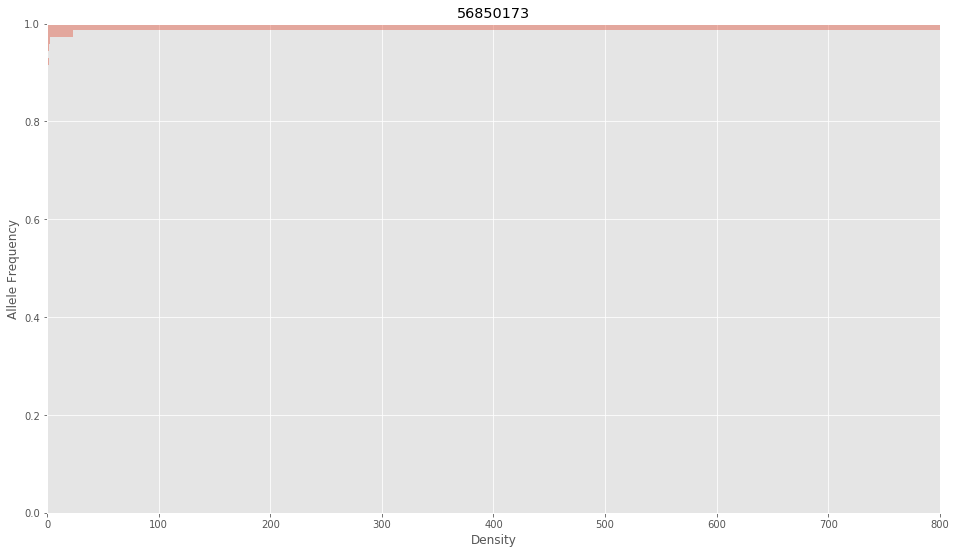

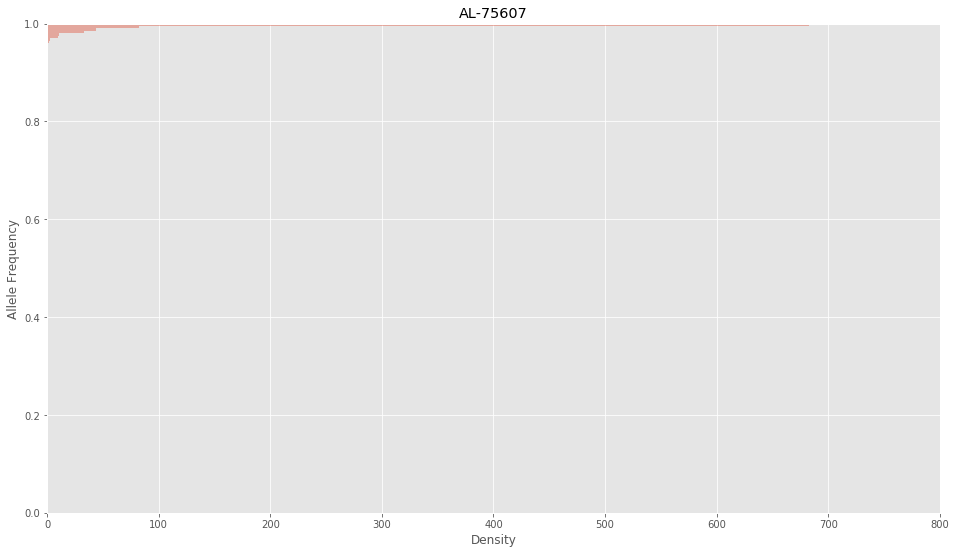

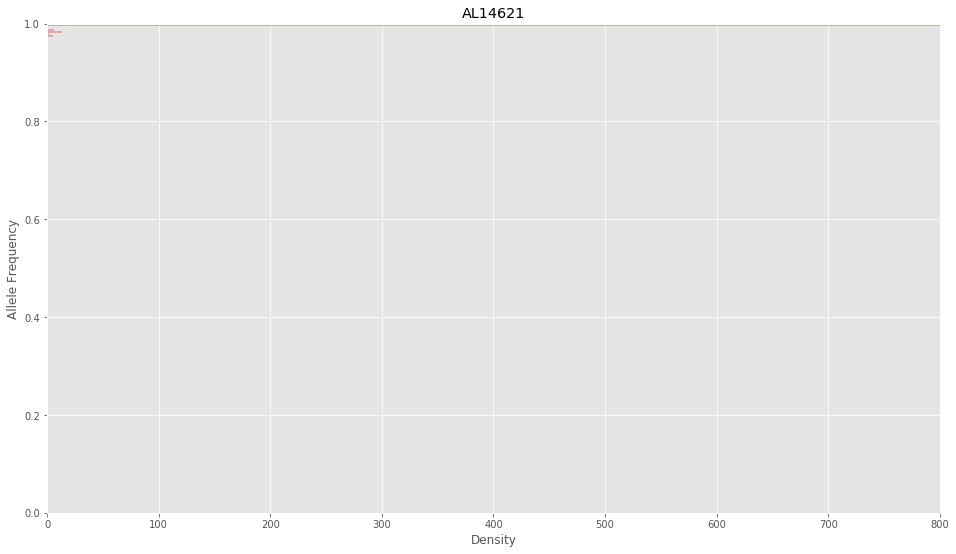

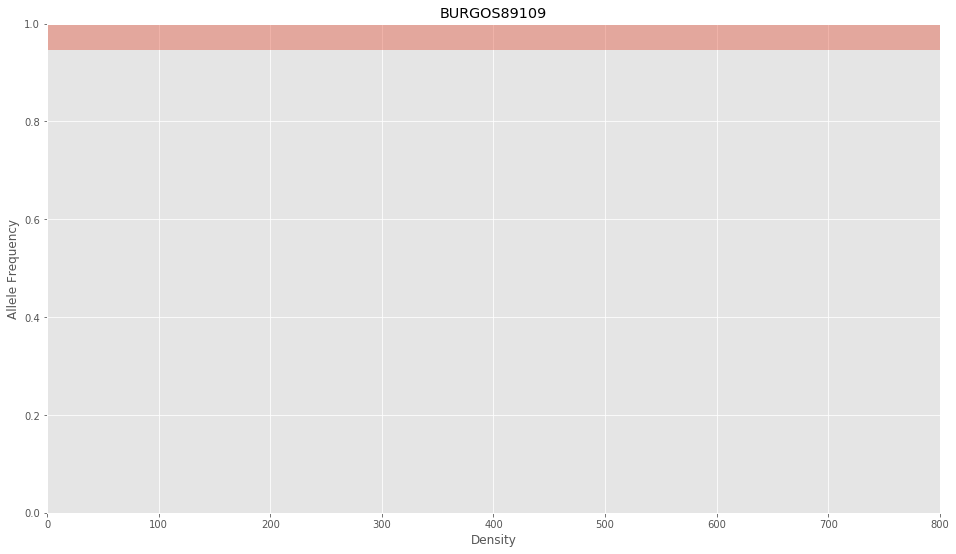

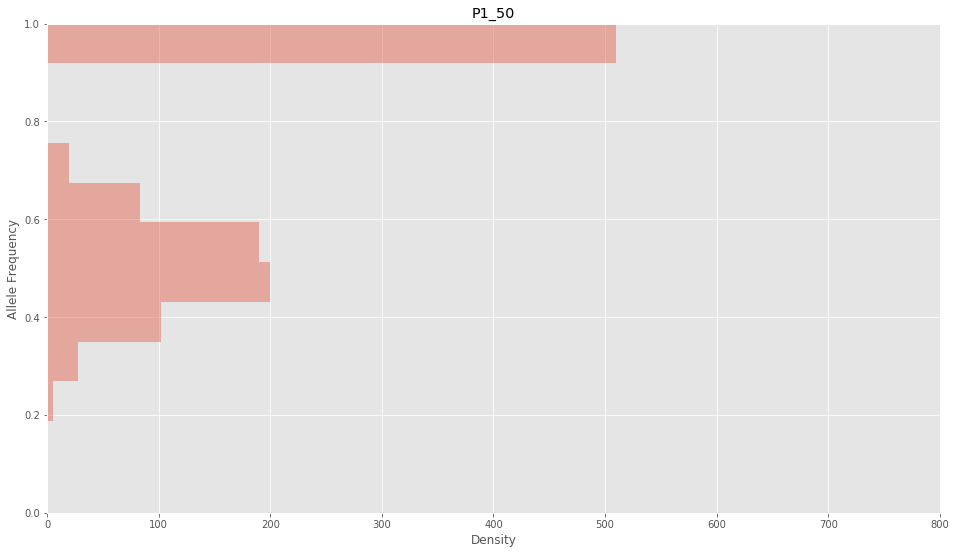

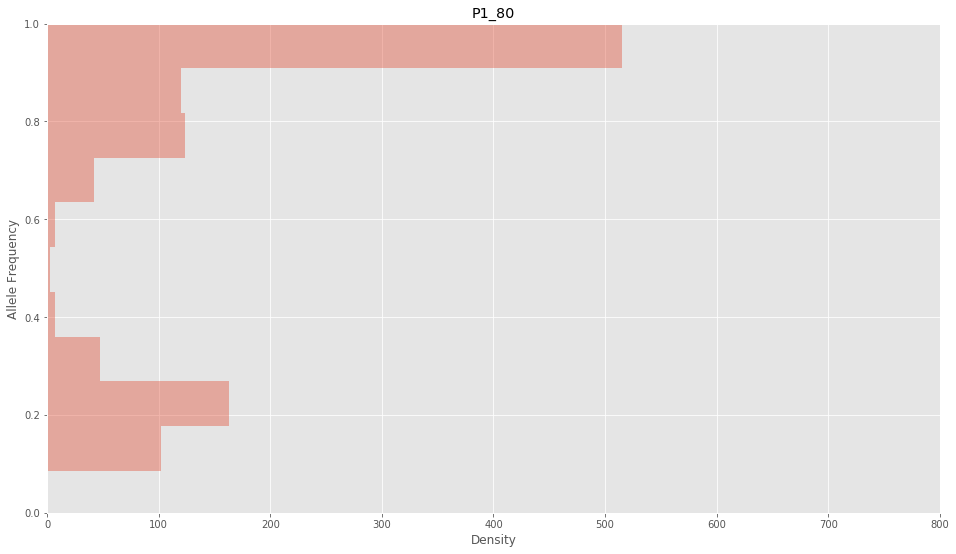

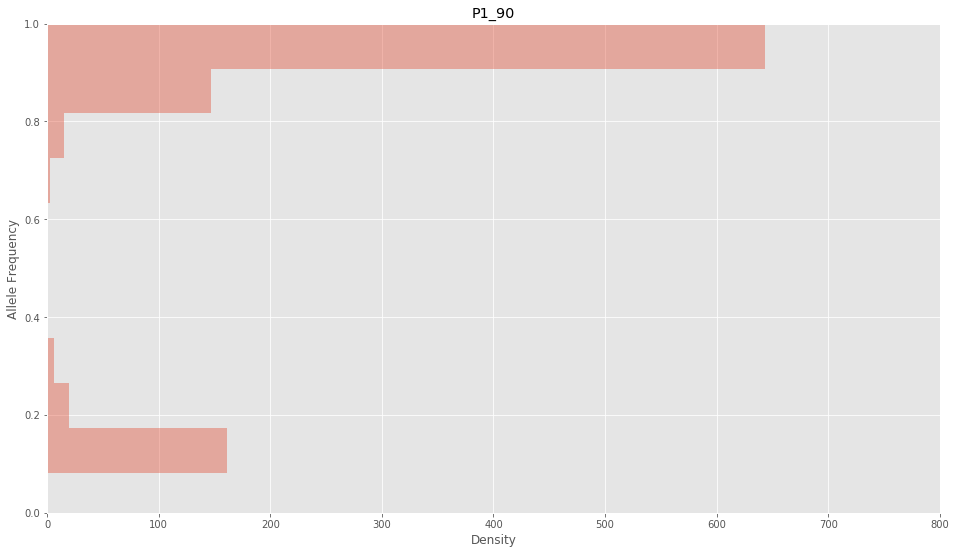

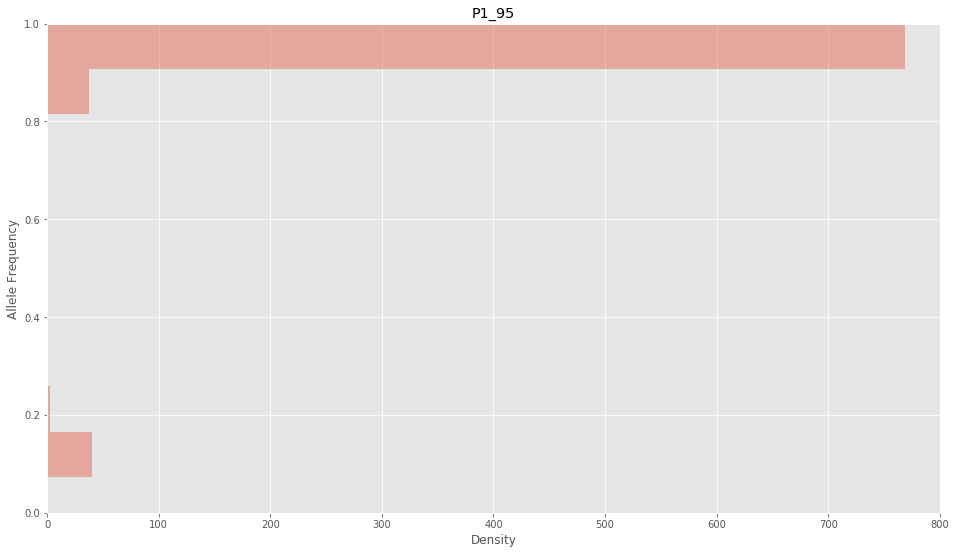

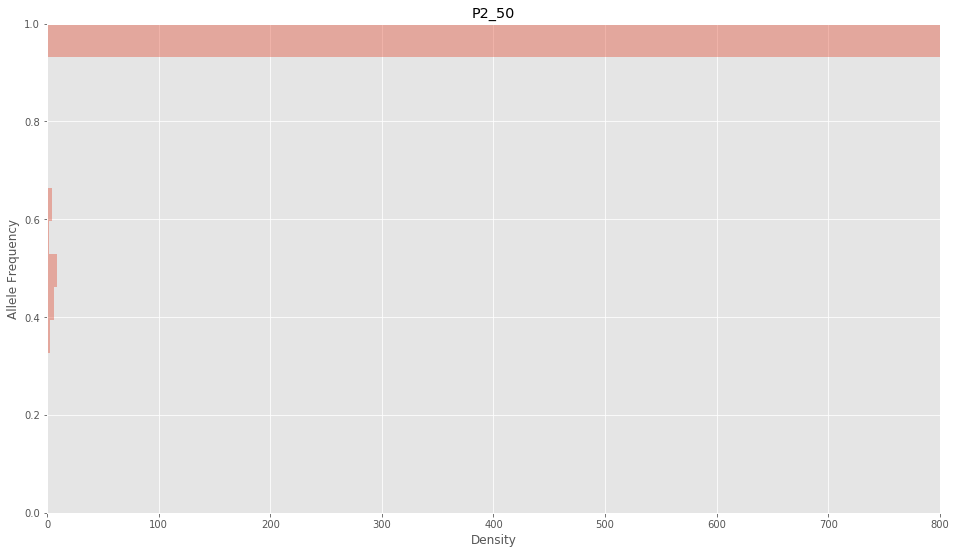

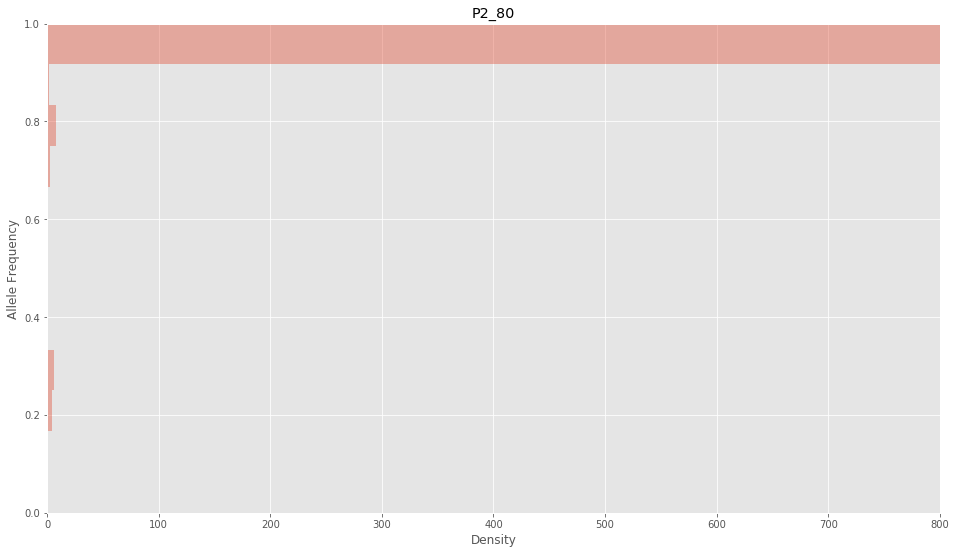

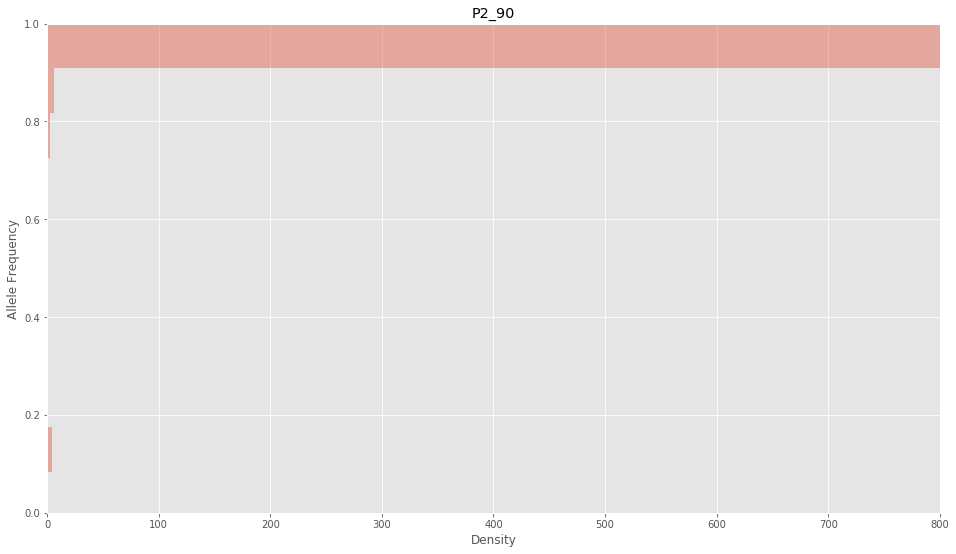

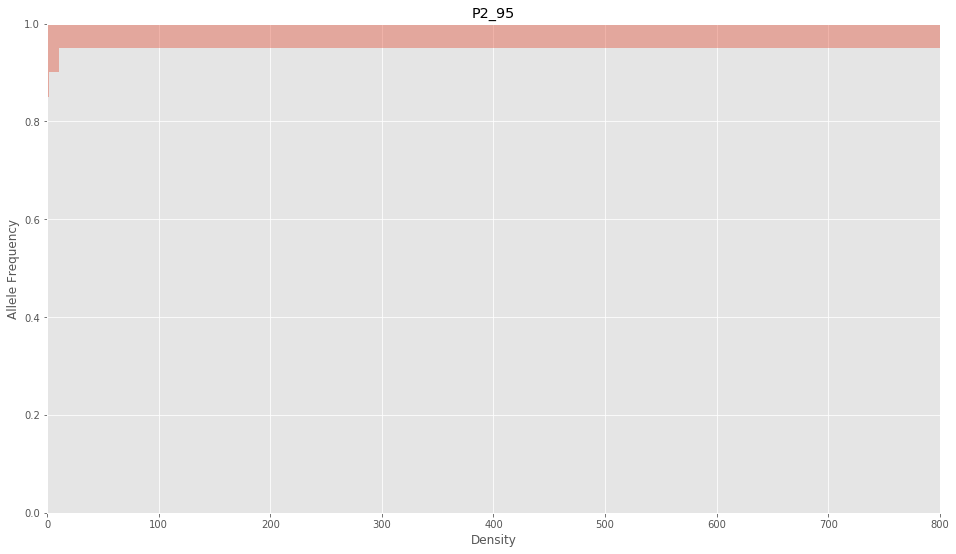

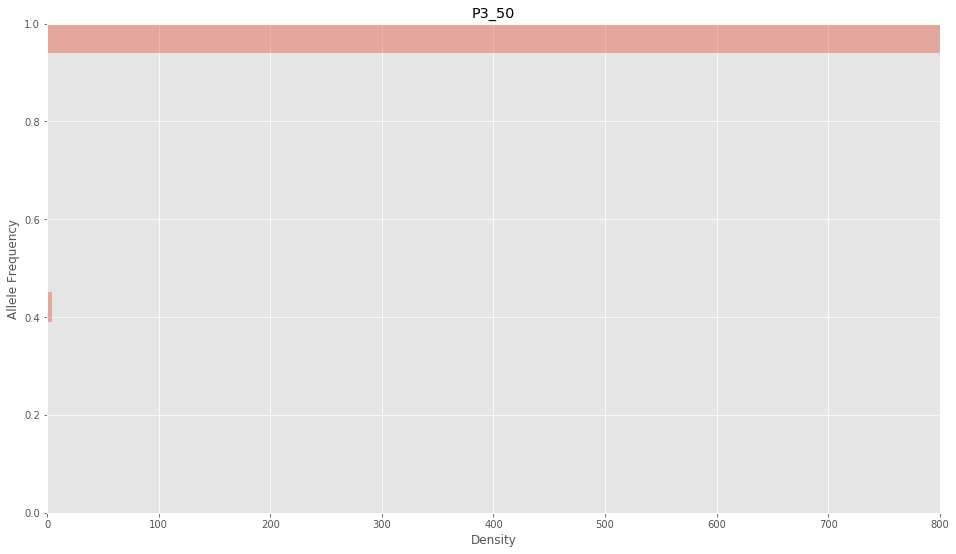

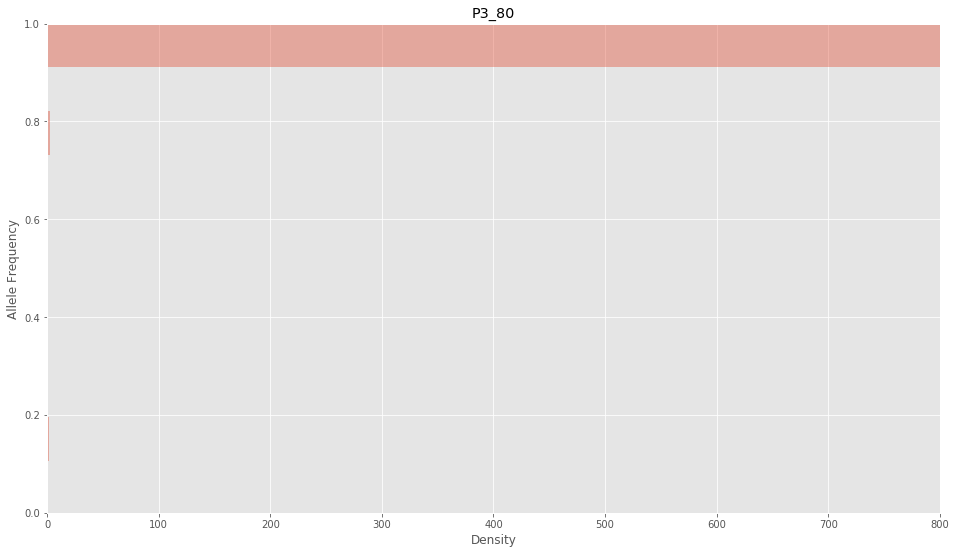

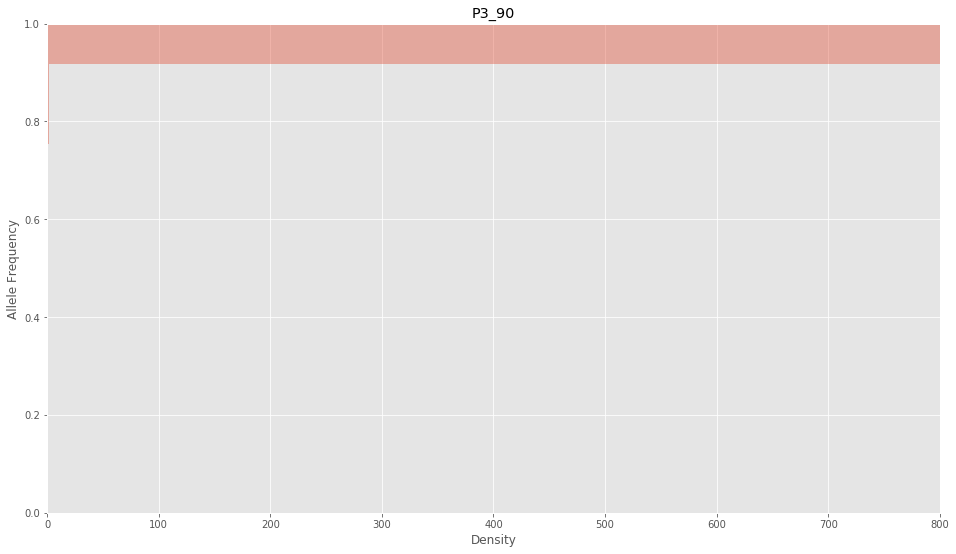

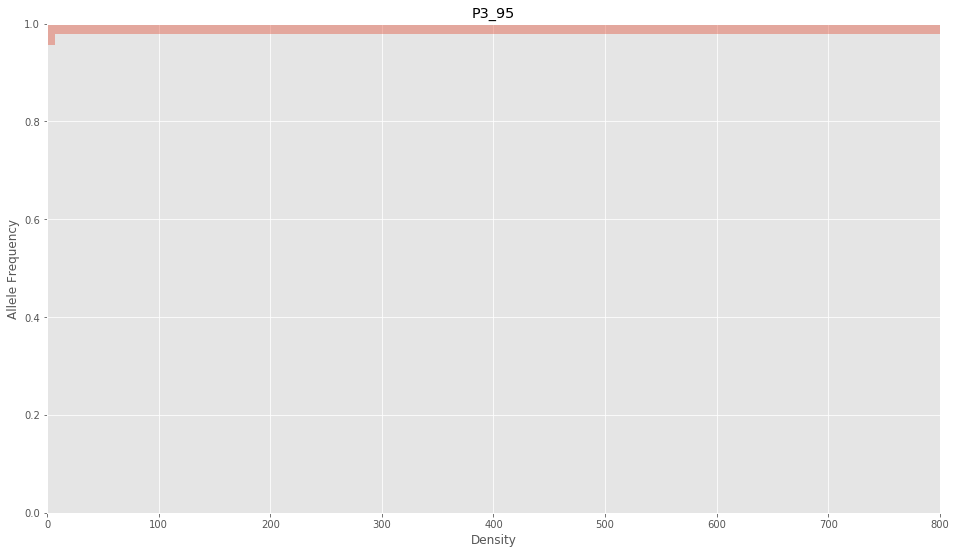

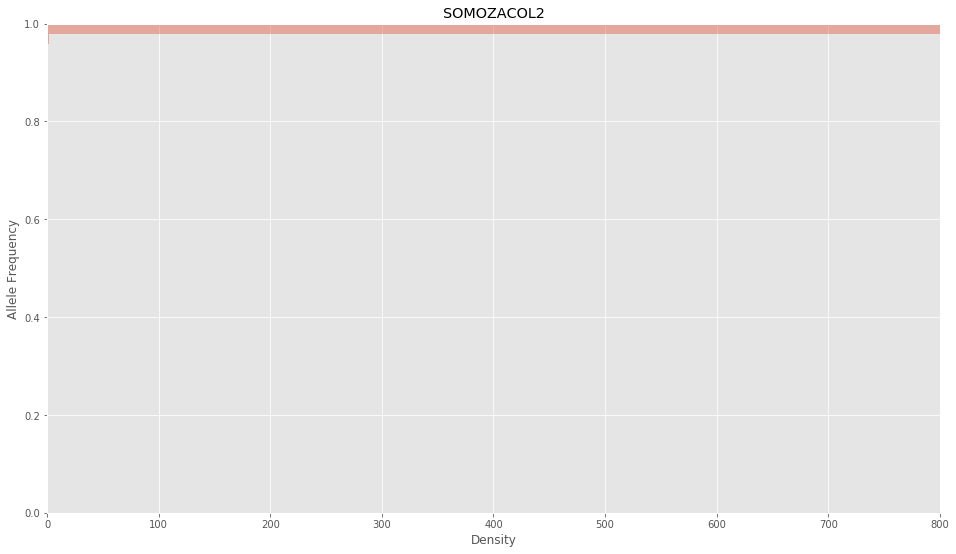

In [380]:
for name_dsf, df in dict_dff.items():
    distplot_sns(df,name_dsf)

In [381]:
def split_df_mean(vcf_df, homoz=0.95):
    filter_homoz_top = homoz
    filter_homoz_bottom = (1 - filter_homoz_top)
    
    mean = vcf_df['AF'][(vcf_df['AF'] <= filter_homoz_top) & (vcf_df['AF'] >= filter_homoz_bottom)].mean(axis = 0)    

    top_positions = vcf_df['POS'][(vcf_df['AF'] >= mean) & (vcf_df['AF'] <= filter_homoz_top)].tolist()
    bottom_positions = vcf_df['POS'][(vcf_df['AF'] <= mean) & (vcf_df['AF'] >= filter_homoz_bottom)].tolist()
    
    return top_positions, bottom_positions

In [382]:
dict_t_b = {}
for name_dff, df_dff in dict_dff.items():
    name_top = name_dff + "_t"
    name_btm = name_dff + "_b"
    name_top , name_btm = split_df_mean(df_dff)
    dict_t_b[name_dff] = name_top , name_btm

In [383]:
for k,v in dict_t_b.items():
    print(k, len(v), len(v[0]), len(v[1]))

16250874FFD 2 1 1
56850173 2 3 1
AL-75607 2 1 1
AL14621 2 0 0
BURGOS89109 2 1 1
P1_50 2 313 316
P1_80 2 297 321
P1_90 2 264 188
P1_95 2 140 43
P2_50 2 9 18
P2_80 2 19 10
P2_90 2 17 6
P2_95 2 12 2
P3_50 2 3 5
P3_80 2 4 4
P3_90 2 4 1
P3_95 2 1 2
SOMOZACOL2 2 1 1


# Create sets for comparing

In [384]:
B = set(dict_dff['BURGOS89109'].POS.values)
P = set(dict_dff['56850173'].POS.values)
A75 = set(dict_dff['AL-75607'].POS.values)
A14 = set(dict_dff['AL14621'].POS.values)
F = set(dict_dff['16250874FFD'].POS.values)
S = set(dict_dff['SOMOZACOL2'].POS.values)

In [385]:
B_exclusive = B - P
P_exclusive = P - B
Shared_B_P = P & B
total_difference_B_P = (len(B_exclusive) + len(P_exclusive))
print("B has %s unique positions\n\
P has %s unique positions\n\
Both share %s positions\n\
Total difference: %s" % (len(B_exclusive) , len(P_exclusive), len(Shared_B_P),total_difference_B_P ))

B has 298 unique positions
P has 334 unique positions
Both share 510 positions
Total difference: 632


In [386]:
A75_exclusive = A75 - A14
A14_exclusive = A14 - A75
Shared_A75_A14 = A14 & A75

print("A75 has %s unique positions\n\
A14 has %s unique positions\n\
Both share %s positions" % (len(A75_exclusive) , len(A14_exclusive), len(Shared_A75_A14)))

A75 has 16 unique positions
A14 has 10 unique positions
Both share 853 positions


In [387]:
F_exclusive = F - S
S_exclusive = S - F
Shared_F_S = S & F

print("F has %s unique Positions\n\
S has %s unique Sositions\n\
Both share %s Positions" % (len(F_exclusive) , len(S_exclusive), len(Shared_F_S)))

F has 2 unique Positions
S has 4 unique Sositions
Both share 838 Positions


# Use venn diagram to check disgregation

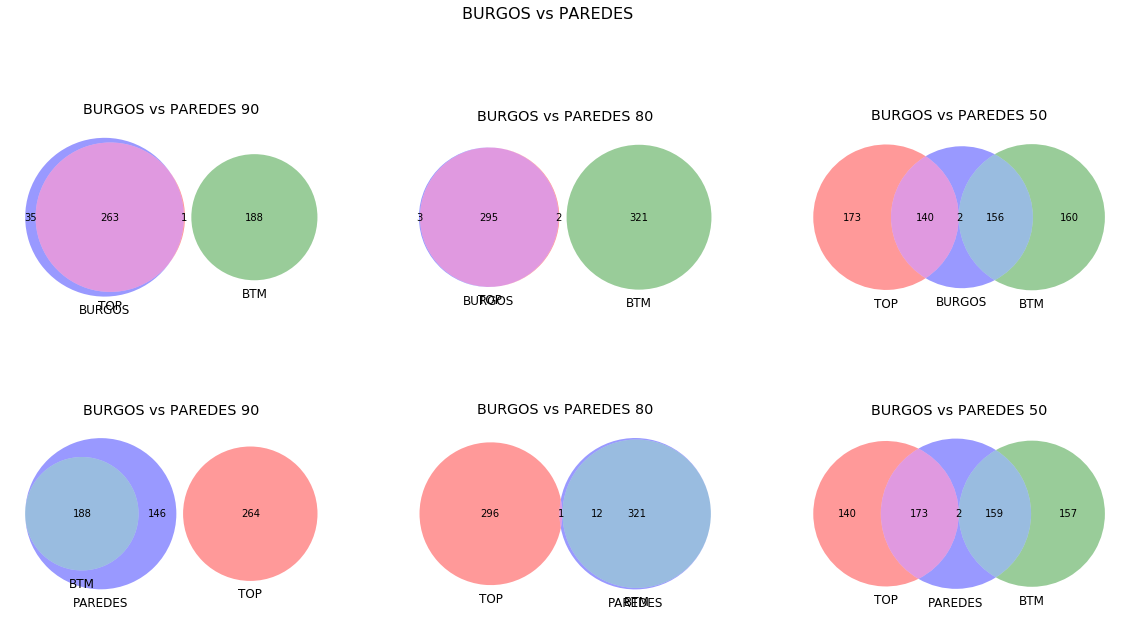

In [388]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("BURGOS vs PAREDES 90")
v3 = venn3([set(dict_t_b['P1_90'][0]), set(dict_t_b['P1_90'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.subplot(2, 3, 2)
plt.title("BURGOS vs PAREDES 80")
v3 = venn3([set(dict_t_b['P1_80'][0]), set(dict_t_b['P1_80'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.subplot(2, 3, 3)
plt.title("BURGOS vs PAREDES 50")
v3 = venn3([set(dict_t_b['P1_50'][0]), set(dict_t_b['P1_50'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.suptitle('BURGOS vs PAREDES', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("BURGOS vs PAREDES 90")
v3 = venn3([set(dict_t_b['P1_90'][0]), set(dict_t_b['P1_90'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(2, 3, 5)
plt.title("BURGOS vs PAREDES 80")
v3 = venn3([set(dict_t_b['P1_80'][0]), set(dict_t_b['P1_80'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(2, 3, 6)
plt.title("BURGOS vs PAREDES 50")
v3 = venn3([set(dict_t_b['P1_50'][0]), set(dict_t_b['P1_50'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

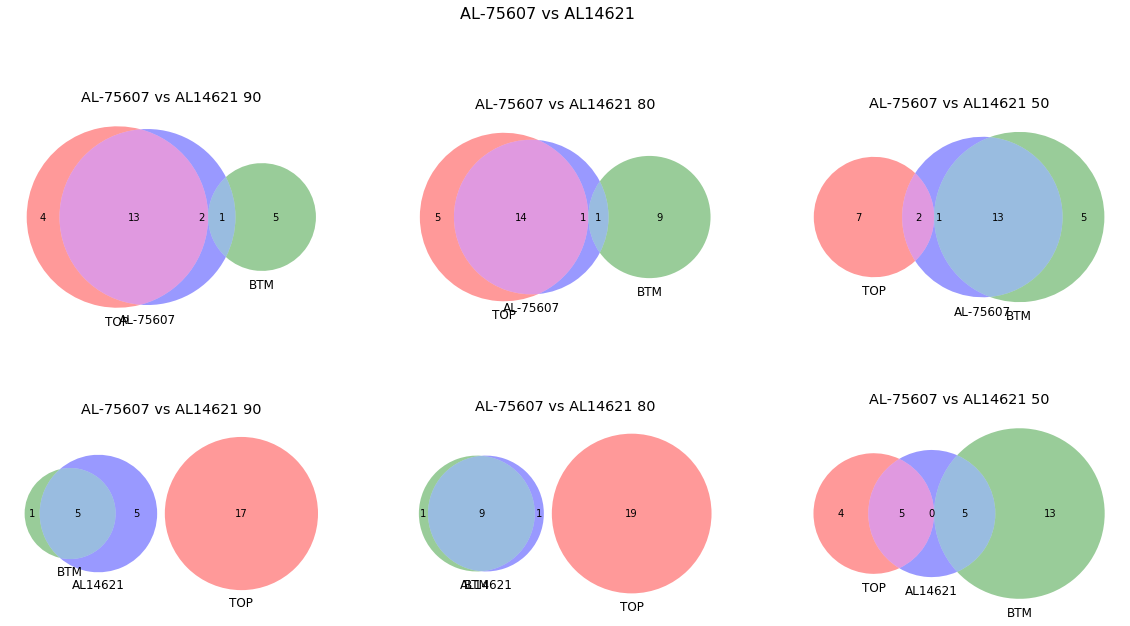

In [389]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("AL-75607 vs AL14621 90")
v3 = venn3([set(dict_t_b['P2_90'][0]), set(dict_t_b['P2_90'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.subplot(2, 3, 2)
plt.title("AL-75607 vs AL14621 80")
v3 = venn3([set(dict_t_b['P2_80'][0]), set(dict_t_b['P2_80'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.subplot(2, 3, 3)
plt.title("AL-75607 vs AL14621 50")
v3 = venn3([set(dict_t_b['P2_50'][0]), set(dict_t_b['P2_50'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.suptitle('AL-75607 vs AL14621', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("AL-75607 vs AL14621 90")
v3 = venn3([set(dict_t_b['P2_90'][0]), set(dict_t_b['P2_90'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

plt.subplot(2, 3, 5)
plt.title("AL-75607 vs AL14621 80")
v3 = venn3([set(dict_t_b['P2_80'][0]), set(dict_t_b['P2_80'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

plt.subplot(2, 3, 6)
plt.title("AL-75607 vs AL14621 50")
v3 = venn3([set(dict_t_b['P2_50'][0]), set(dict_t_b['P2_50'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

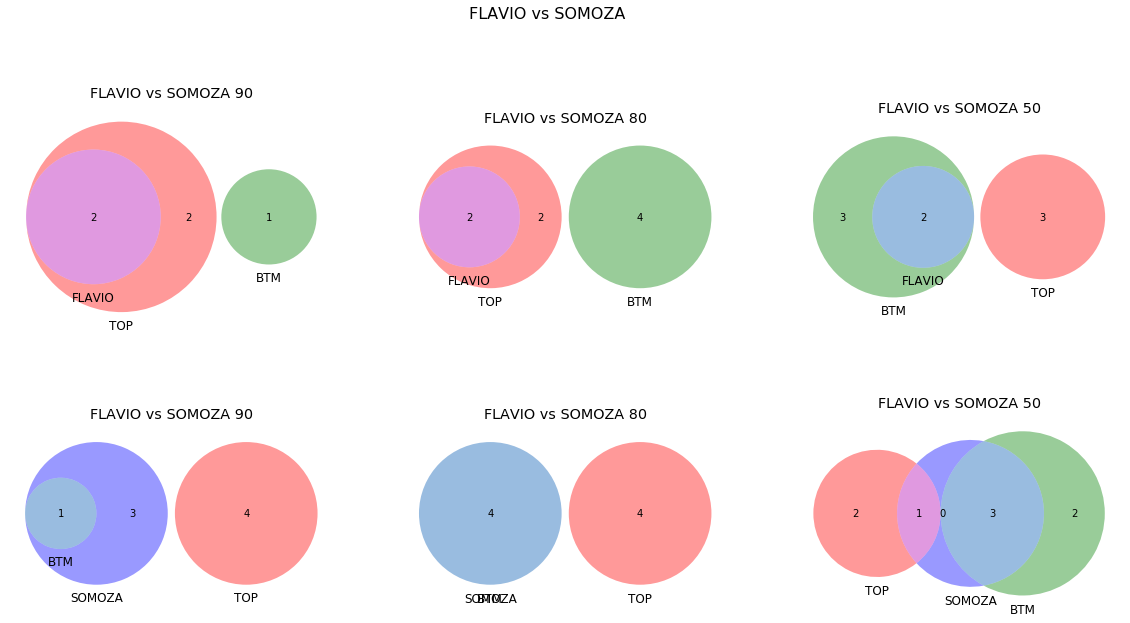

In [390]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("FLAVIO vs SOMOZA 90")
v3 = venn3([set(dict_t_b['P3_90'][0]), set(dict_t_b['P3_90'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.subplot(2, 3, 2)
plt.title("FLAVIO vs SOMOZA 80")
v3 = venn3([set(dict_t_b['P3_80'][0]), set(dict_t_b['P3_80'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.subplot(2, 3, 3)
plt.title("FLAVIO vs SOMOZA 50")
v3 = venn3([set(dict_t_b['P3_50'][0]), set(dict_t_b['P3_50'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.suptitle('FLAVIO vs SOMOZA', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("FLAVIO vs SOMOZA 90")
v3 = venn3([set(dict_t_b['P3_90'][0]), set(dict_t_b['P3_90'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.subplot(2, 3, 5)
plt.title("FLAVIO vs SOMOZA 80")
v3 = venn3([set(dict_t_b['P3_80'][0]), set(dict_t_b['P3_80'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.subplot(2, 3, 6)
plt.title("FLAVIO vs SOMOZA 50")
v3 = venn3([set(dict_t_b['P3_50'][0]), set(dict_t_b['P3_50'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

# Start K-means clustering

### Thanks to: http://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/

In [391]:
dict_dff['P1_50'].describe()

POS          QUAL           AC           af      AN  \
count  1.139000e+03   1139.000000  1139.000000  1139.000000  1139.0   
mean   2.189238e+06  30159.317550     1.447761     0.723881     2.0   
std    1.323607e+06  15763.244953     0.497482     0.248741     0.0   
min    1.977000e+03   2602.880000     1.000000     0.500000     2.0   
25%    1.056418e+06  18054.730000     1.000000     0.500000     2.0   
50%    2.154724e+06  26349.240000     1.000000     0.500000     2.0   
75%    3.313522e+06  43071.770000     2.000000     1.000000     2.0   
max    4.408156e+06  76972.270000     2.000000     1.000000     2.0   

       BaseQRankSum           DP    ExcessHet           FS           MQ  \
count    762.000000  1139.000000  1139.000000  1139.000000  1139.000000   
mean       0.148427    63.762072     1.401389     1.925657    59.905768   
std        1.838868    17.243896     1.493092     3.830927     0.882346   
min       -4.556000     6.000000     0.000300     0.000000    43.050000   
25%       -1.427000    52.000000     0.011100     0.000000    60.000000   
50%        0.244000    62.000000     0.195400     0.000000    60.000000   
75%        1.700000    76.000000     3.010300     2.267000    60.000000   
max        5.300000   130.000000    10.548300    33.993000    60.000000   

        MQRankSum           QD  ReadPosRankSum          SOR           GQ  \
count  762.000000  1139.000000      761.000000  1139.000000  1139.000000   
mean     0.014707    29.949491        0.179979     0.746359    98.611062   
std      0.469552     3.309030        1.001096     0.346654     4.079257   
min     -7.441000    16.820000       -2.697000     0.013000    18.000000   
25%      0.000000    27.575000       -0.567000     0.531500    99.000000   
50%      0.000000    30.280000        0.138000     0.738000    99.000000   
75%      0.000000    32.760000        0.923000     0.917000    99.000000   
max      7.750000    37.710000        2.660000     2.833000    99.000000   

       len_AD       REF_AD       ALT_AD           dp           aF  \
count  1139.0  1139.000000  1139.000000  1139.000000  1139.000000   
mean      2.0    17.502195    46.254609    63.756804     0.275001   
std       0.0    17.545090    21.080942    17.244995     0.257071   
min       2.0     0.000000     3.000000     6.000000     0.000000   
25%       2.0     0.000000    29.000000    52.000000     0.000000   
50%       2.0    19.000000    42.000000    62.000000     0.377049   
75%       2.0    32.000000    61.000000    76.000000     0.509902   
max       2.0    66.000000   130.000000   130.000000     0.812500   

                AF  snp_left_distance  snp_right_distance  
count  1139.000000        1139.000000         1139.000000  
mean      0.724999        3440.582090         3412.167691  
std       0.257071        3594.536789         3447.366151  
min       0.187500          16.000000           16.000000  
25%       0.490098         941.500000          943.500000  
50%       0.622951        2257.000000         2291.000000  
75%       1.000000        4789.500000         4822.000000  
max       1.000000       31347.000000        21698.000000

/home/laura/env36/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


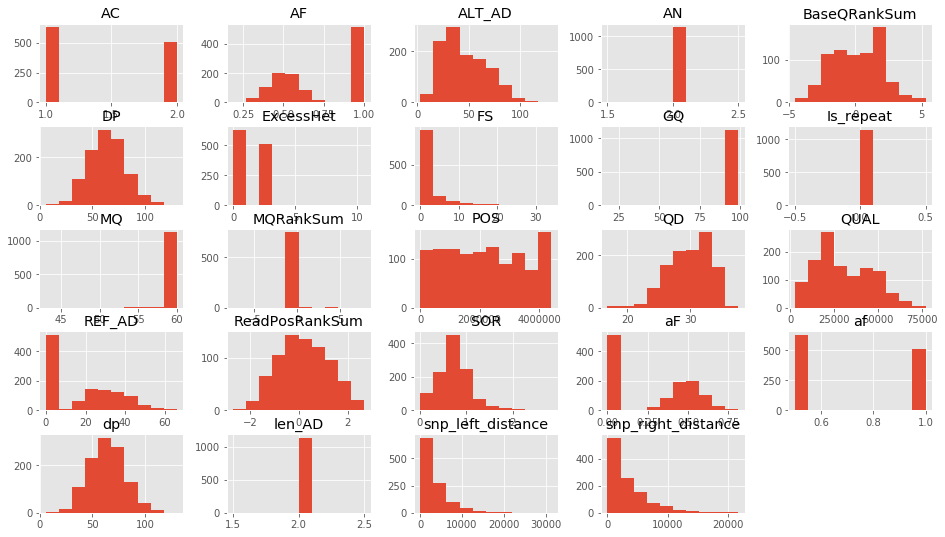

In [392]:
dict_dff['P1_50'].hist()
plt.show()

In [393]:
def assign_group_P1(row):
    if row.POS in B_exclusive:
        return 1
    elif row.POS in P_exclusive:
        return 2
    else:
        return 3


In [394]:
Ktest5 = dict_dff['P1_50']
Ktest8 = dict_dff['P1_80']
Ktest9 = dict_dff['P1_90']

In [395]:
Ktest5['category'] = Ktest5.apply(assign_group_P1, axis=1)
Ktest8['category'] = Ktest8.apply(assign_group_P1, axis=1)
Ktest9['category'] = Ktest9.apply(assign_group_P1, axis=1)

/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [396]:
Ktest8.head()

#CHROM   POS ID REF ALT      QUAL FILTER  \
0  MTB_anc  1977  .   G   A  19963.51   PASS   
1  MTB_anc  2532  .   C   T  16595.27   PASS   
2  MTB_anc  6140  .   G   T  22403.11   PASS   
3  MTB_anc  7585  .   C   G  31938.04   PASS   
4  MTB_anc  9143  .   C   T  56818.27   PASS   

                                                INFO          FORMAT  \
0  AC=1;AF=0.500;AN=2;BaseQRankSum=0.720;DP=42;Ex...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=13;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.500;AN=2;BaseQRankSum=1.43;DP=52;Exc...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.500;AN=2;BaseQRankSum=1.27;DP=72;Exc...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=73;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   

                       sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
0  0/1:10,32:42:99:1042,0,200  1.0  0.5  2.0          0.72  42.0     0.0442   
1     1/1:0,13:13:39:394,39,0  2.0  1.0  2.0           NaN  13.0     3.0103   
2   0/1:43,9:52:99:213,0,1214  1.0  0.5  2.0          1.43  52.0     0.0069   
3  0/1:22,50:72:99:1565,0,484  1.0  0.5  2.0          1.27  72.0     0.0111   
4   1/1:0,73:73:99:2536,218,0  2.0  1.0  2.0           NaN  73.0     3.0103   

      FS InbreedingCoeff    MQ  MQRankSum     QD  ReadPosRankSum    SOR   GT  \
0  1.003          0.5558  60.0        0.0  30.57           0.655  0.434  0/1   
1  0.000         -0.0000  60.0        NaN  31.55             NaN  0.883  1/1   
2  0.919          0.7203  60.0        0.0  29.67          -0.273  0.827  0/1   
3  0.994          0.6656  60.0        0.0  32.33          -0.405  0.573  0/1   
4  0.000          0.0000  60.0        NaN  34.27             NaN  1.010  1/1   

      AD    GQ          PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD    dp  \
0  10,32  99.0  1042,0,200  NaN  NaN  NaN       2    10.0    32.0  42.0   
1   0,13  39.0    394,39,0  NaN  NaN  NaN       2     0.0    13.0  13.0   
2   43,9  99.0  213,0,1214  NaN  NaN  NaN       2    43.0     9.0  52.0   
3  22,50  99.0  1565,0,484  NaN  NaN  NaN       2    22.0    50.0  72.0   
4   0,73  99.0  2536,218,0  NaN  NaN  NaN       2     0.0    73.0  73.0   

         aF        AF  Is_repeat  snp_left_distance  snp_right_distance  \
0  0.238095  0.761905      False             1977.0               555.0   
1  0.000000  1.000000      False              555.0              3608.0   
2  0.826923  0.173077      False             3608.0              1445.0   
3  0.305556  0.694444      False             1445.0              1558.0   
4  0.000000  1.000000      False             1558.0               161.0   

   category  
0         1  
1         3  
2         2  
3         1  
4         3

/home/laura/env36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


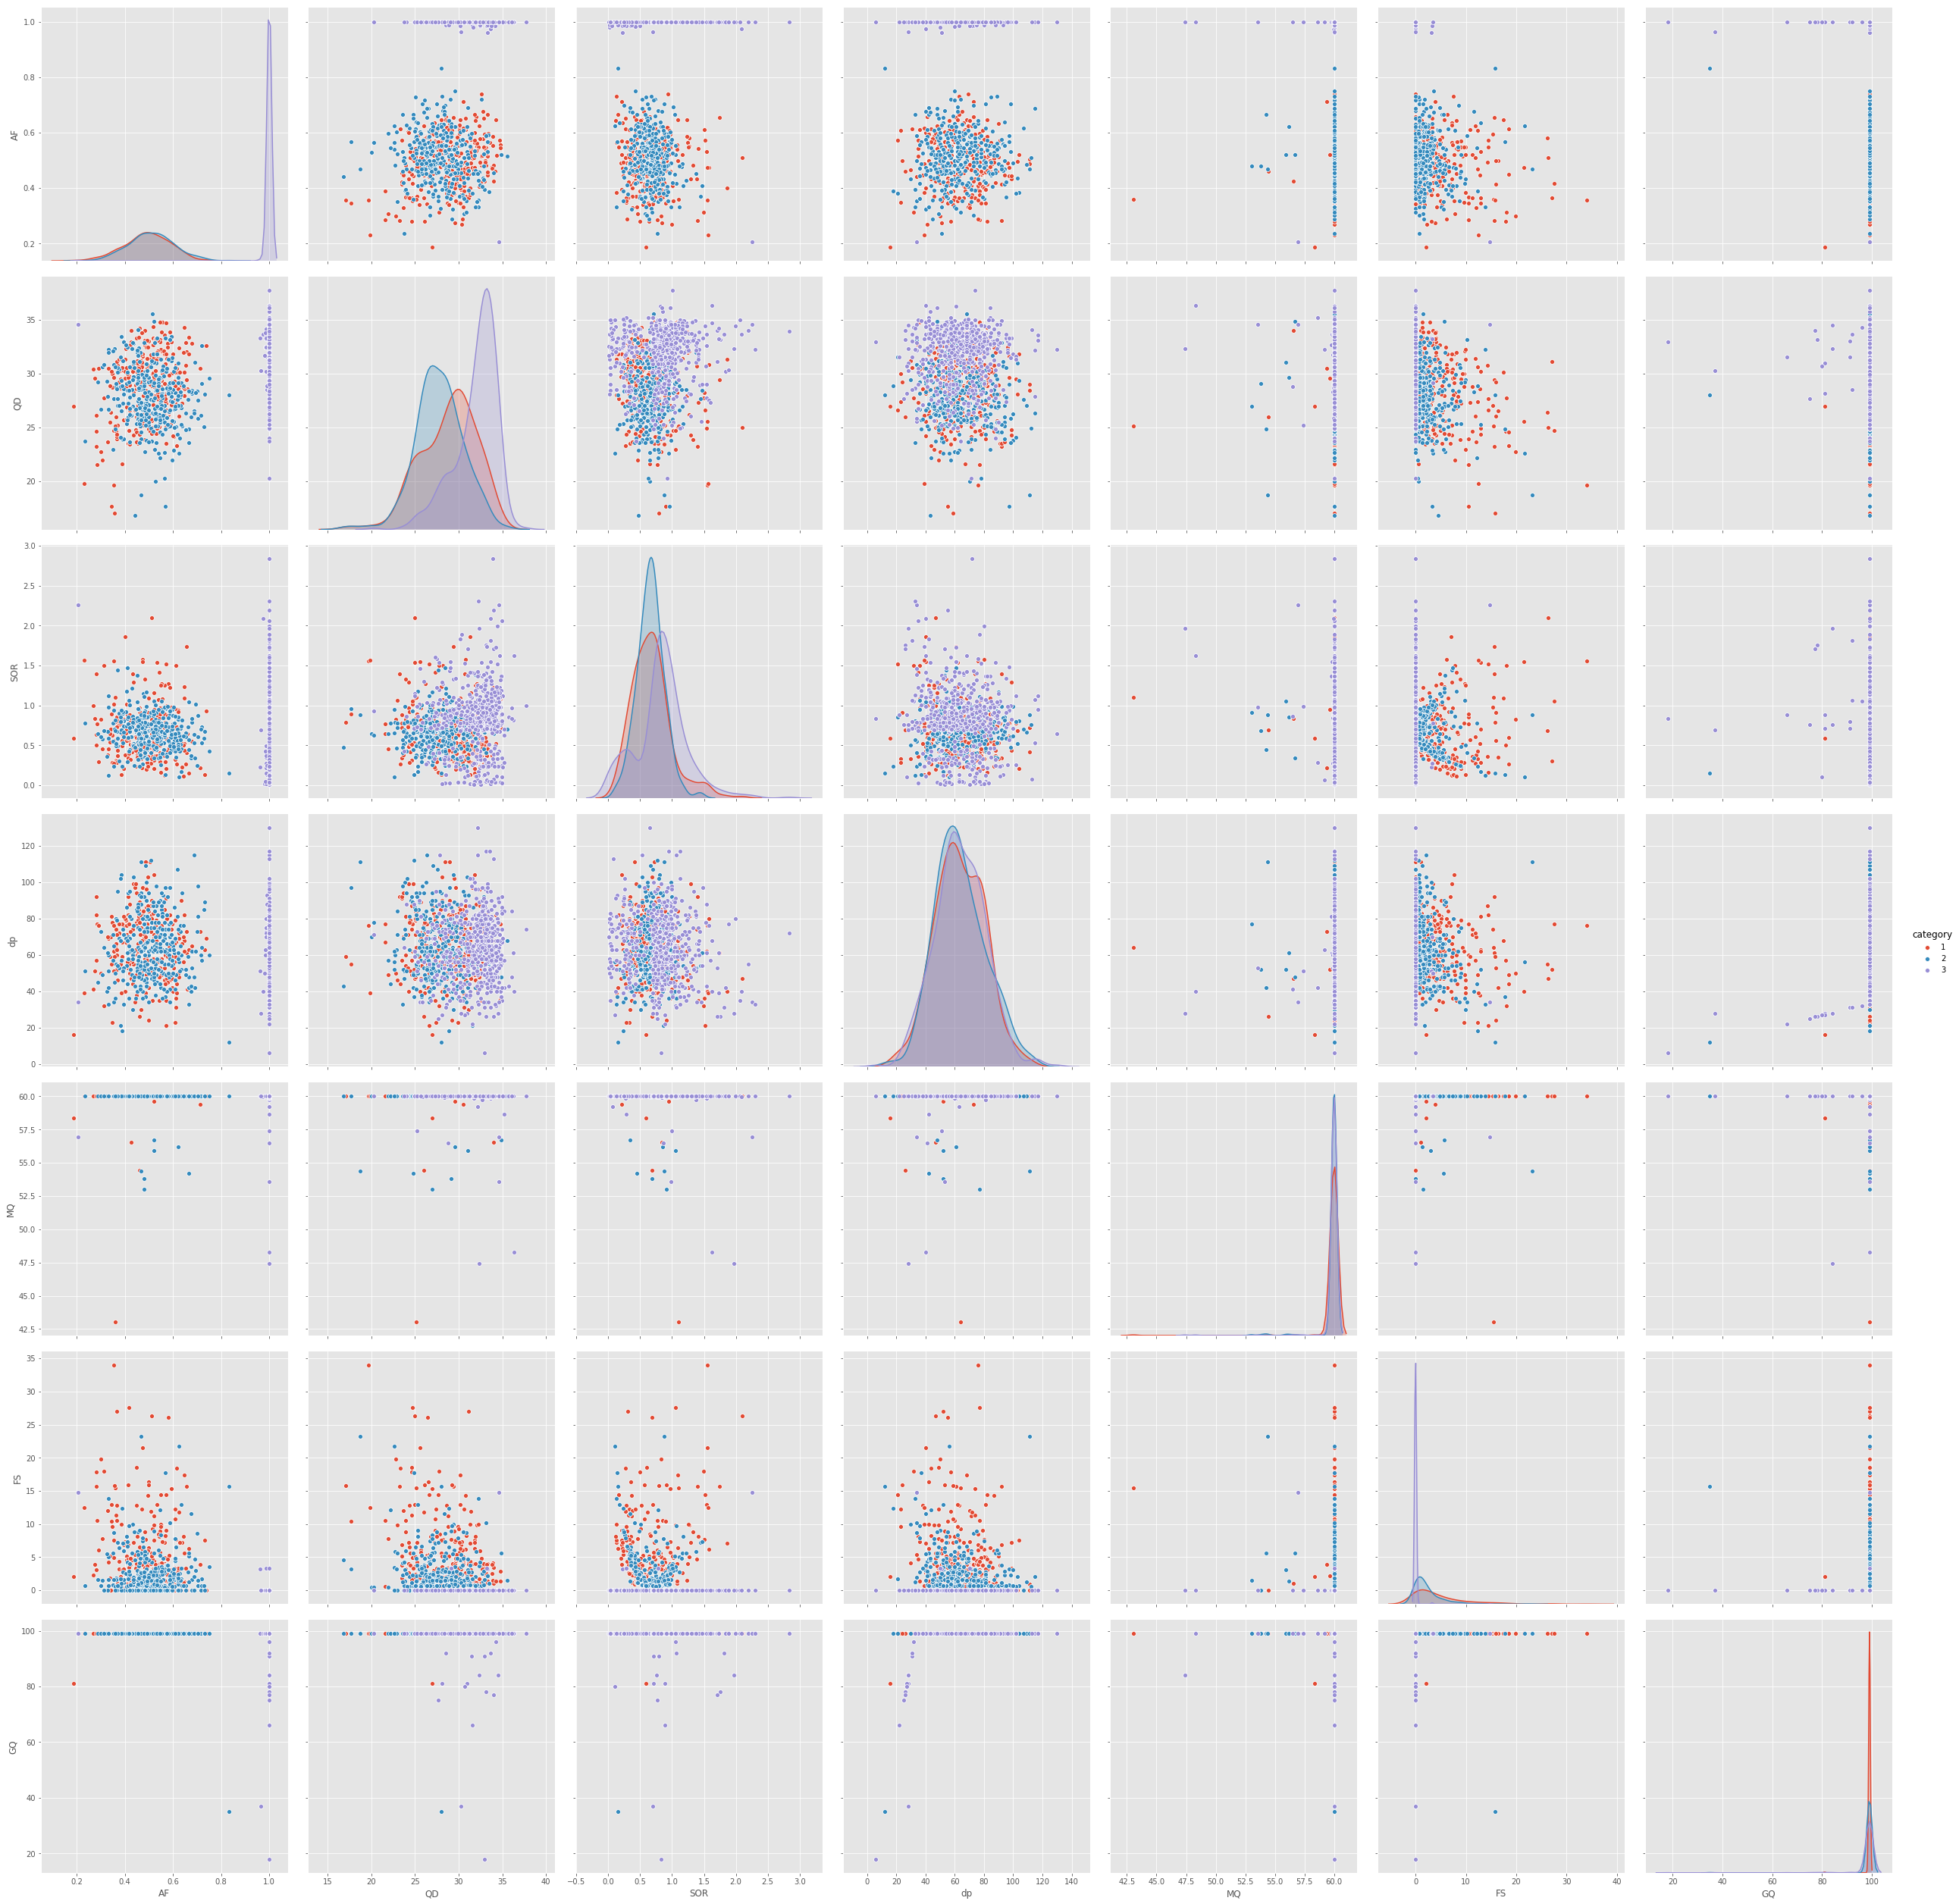

In [397]:
sns.pairplot(Ktest5, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

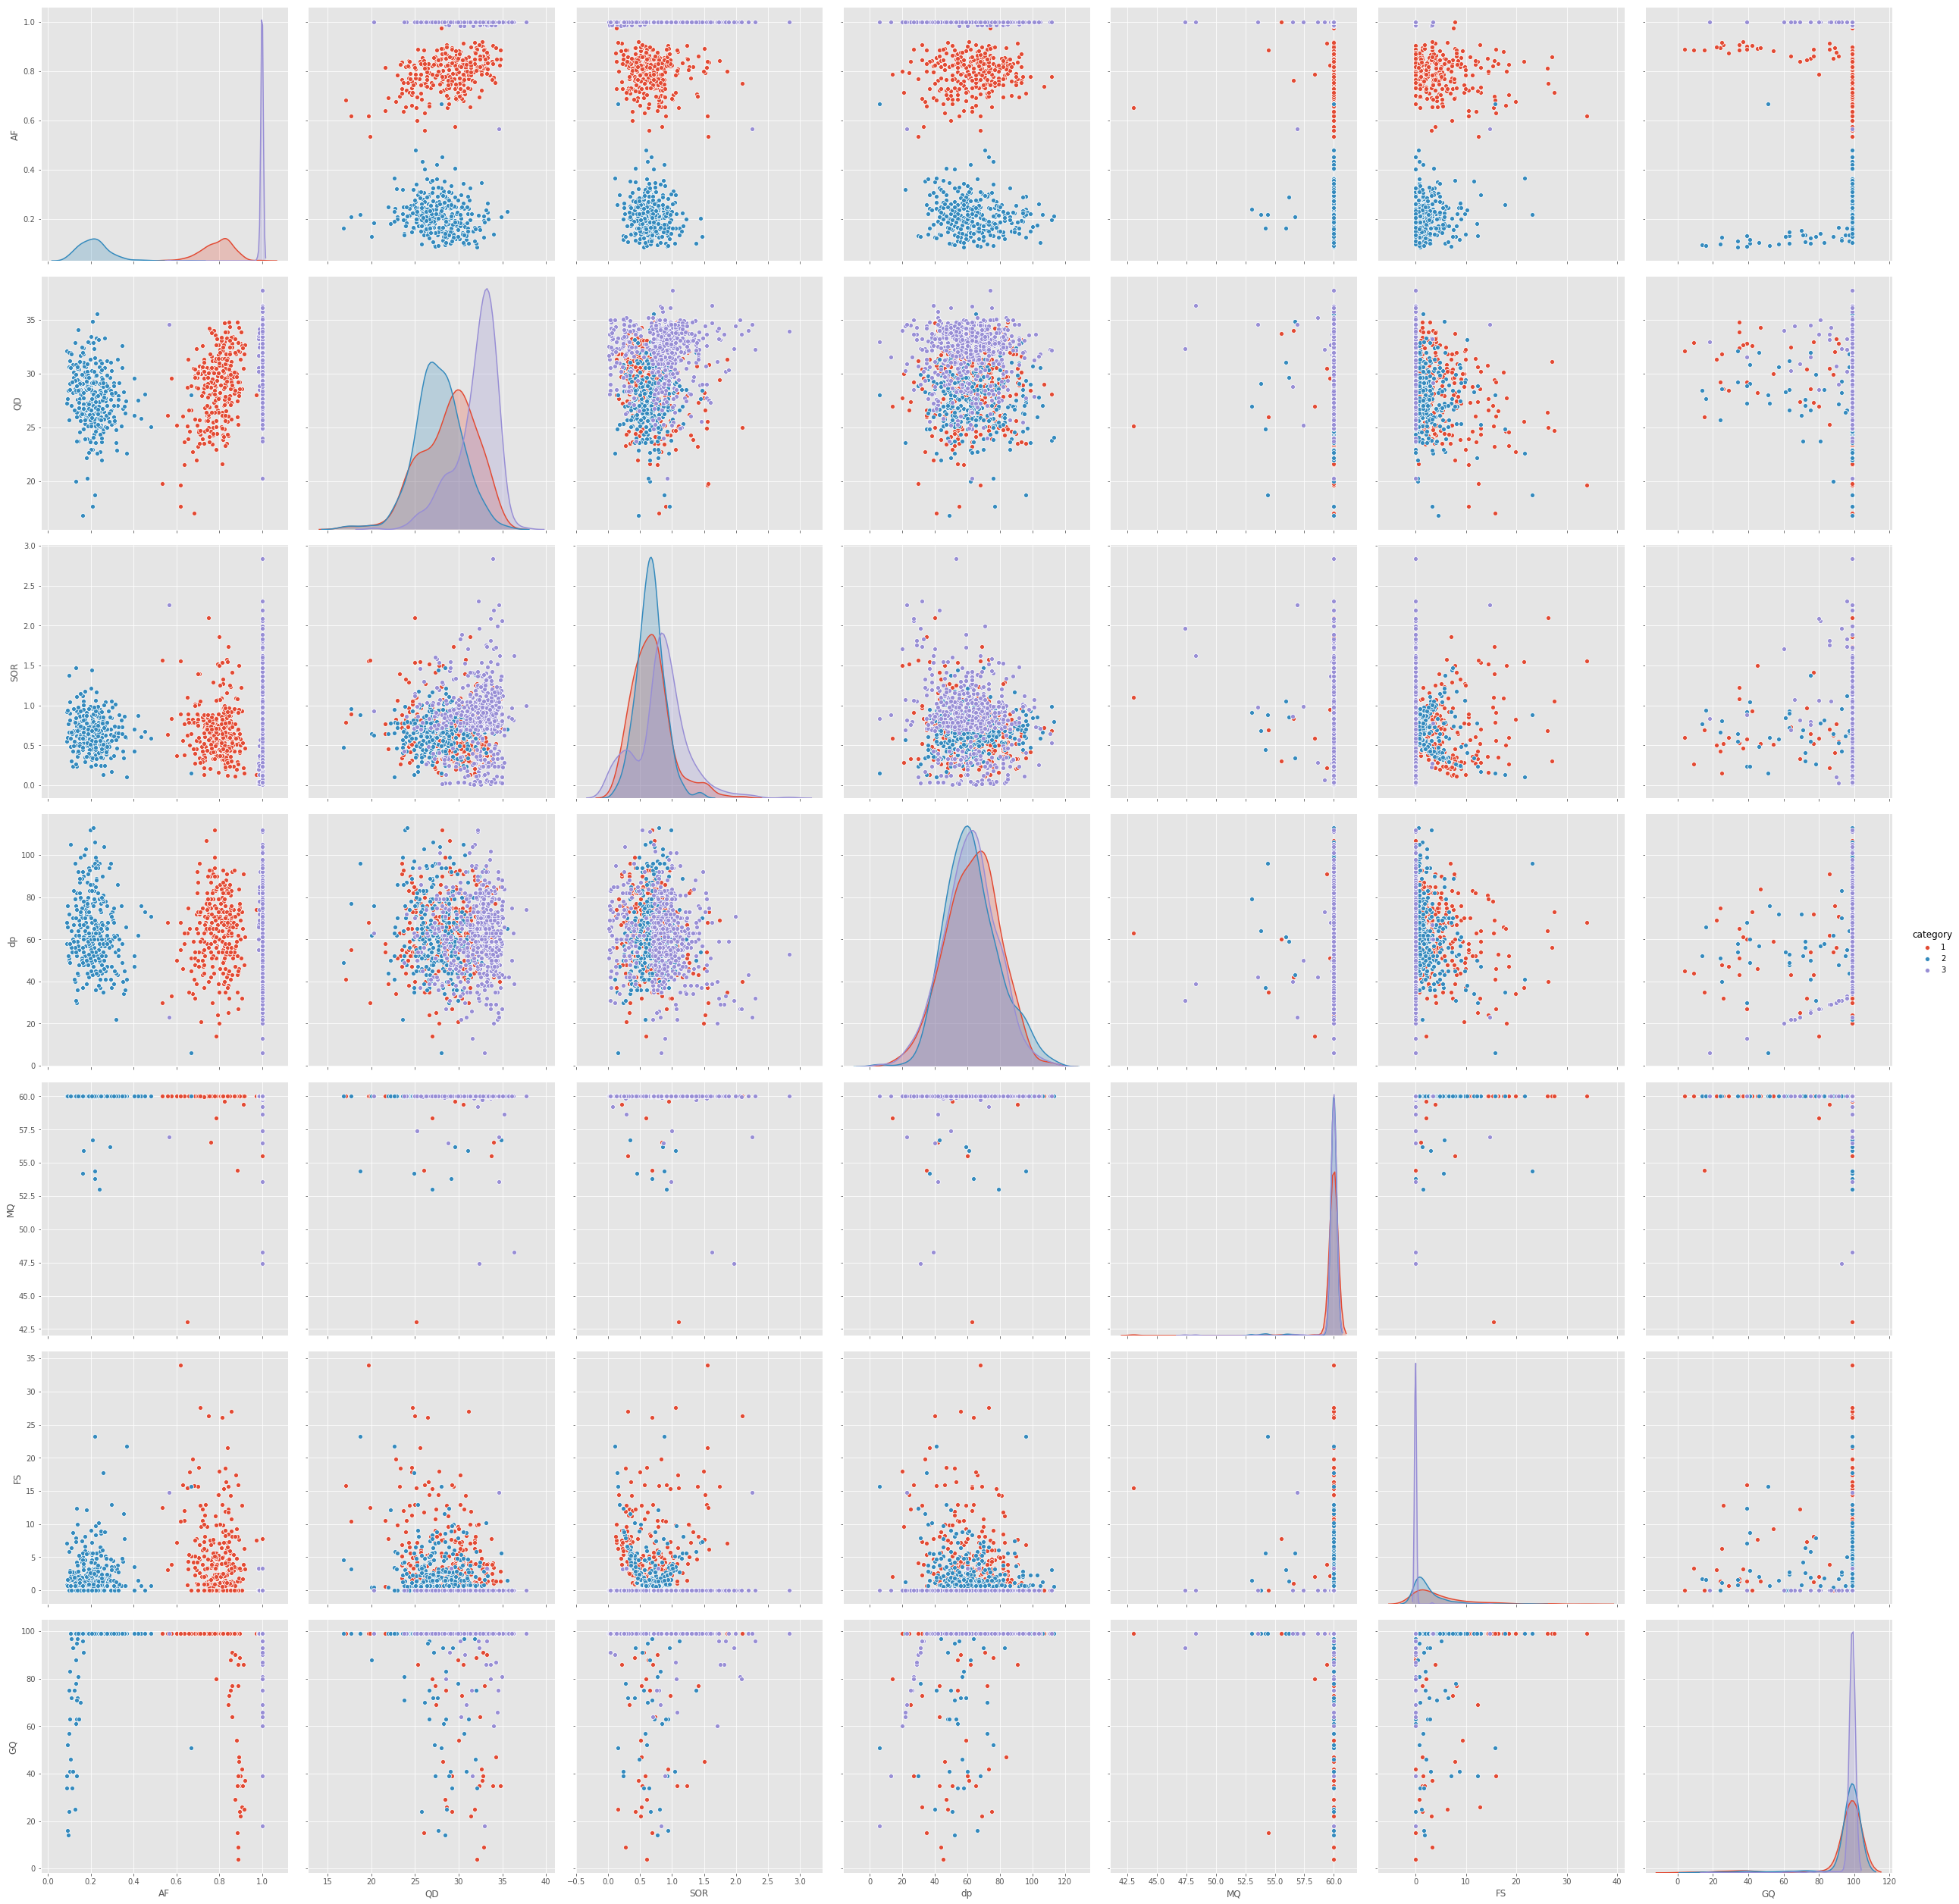

In [398]:
sns.pairplot(Ktest8, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

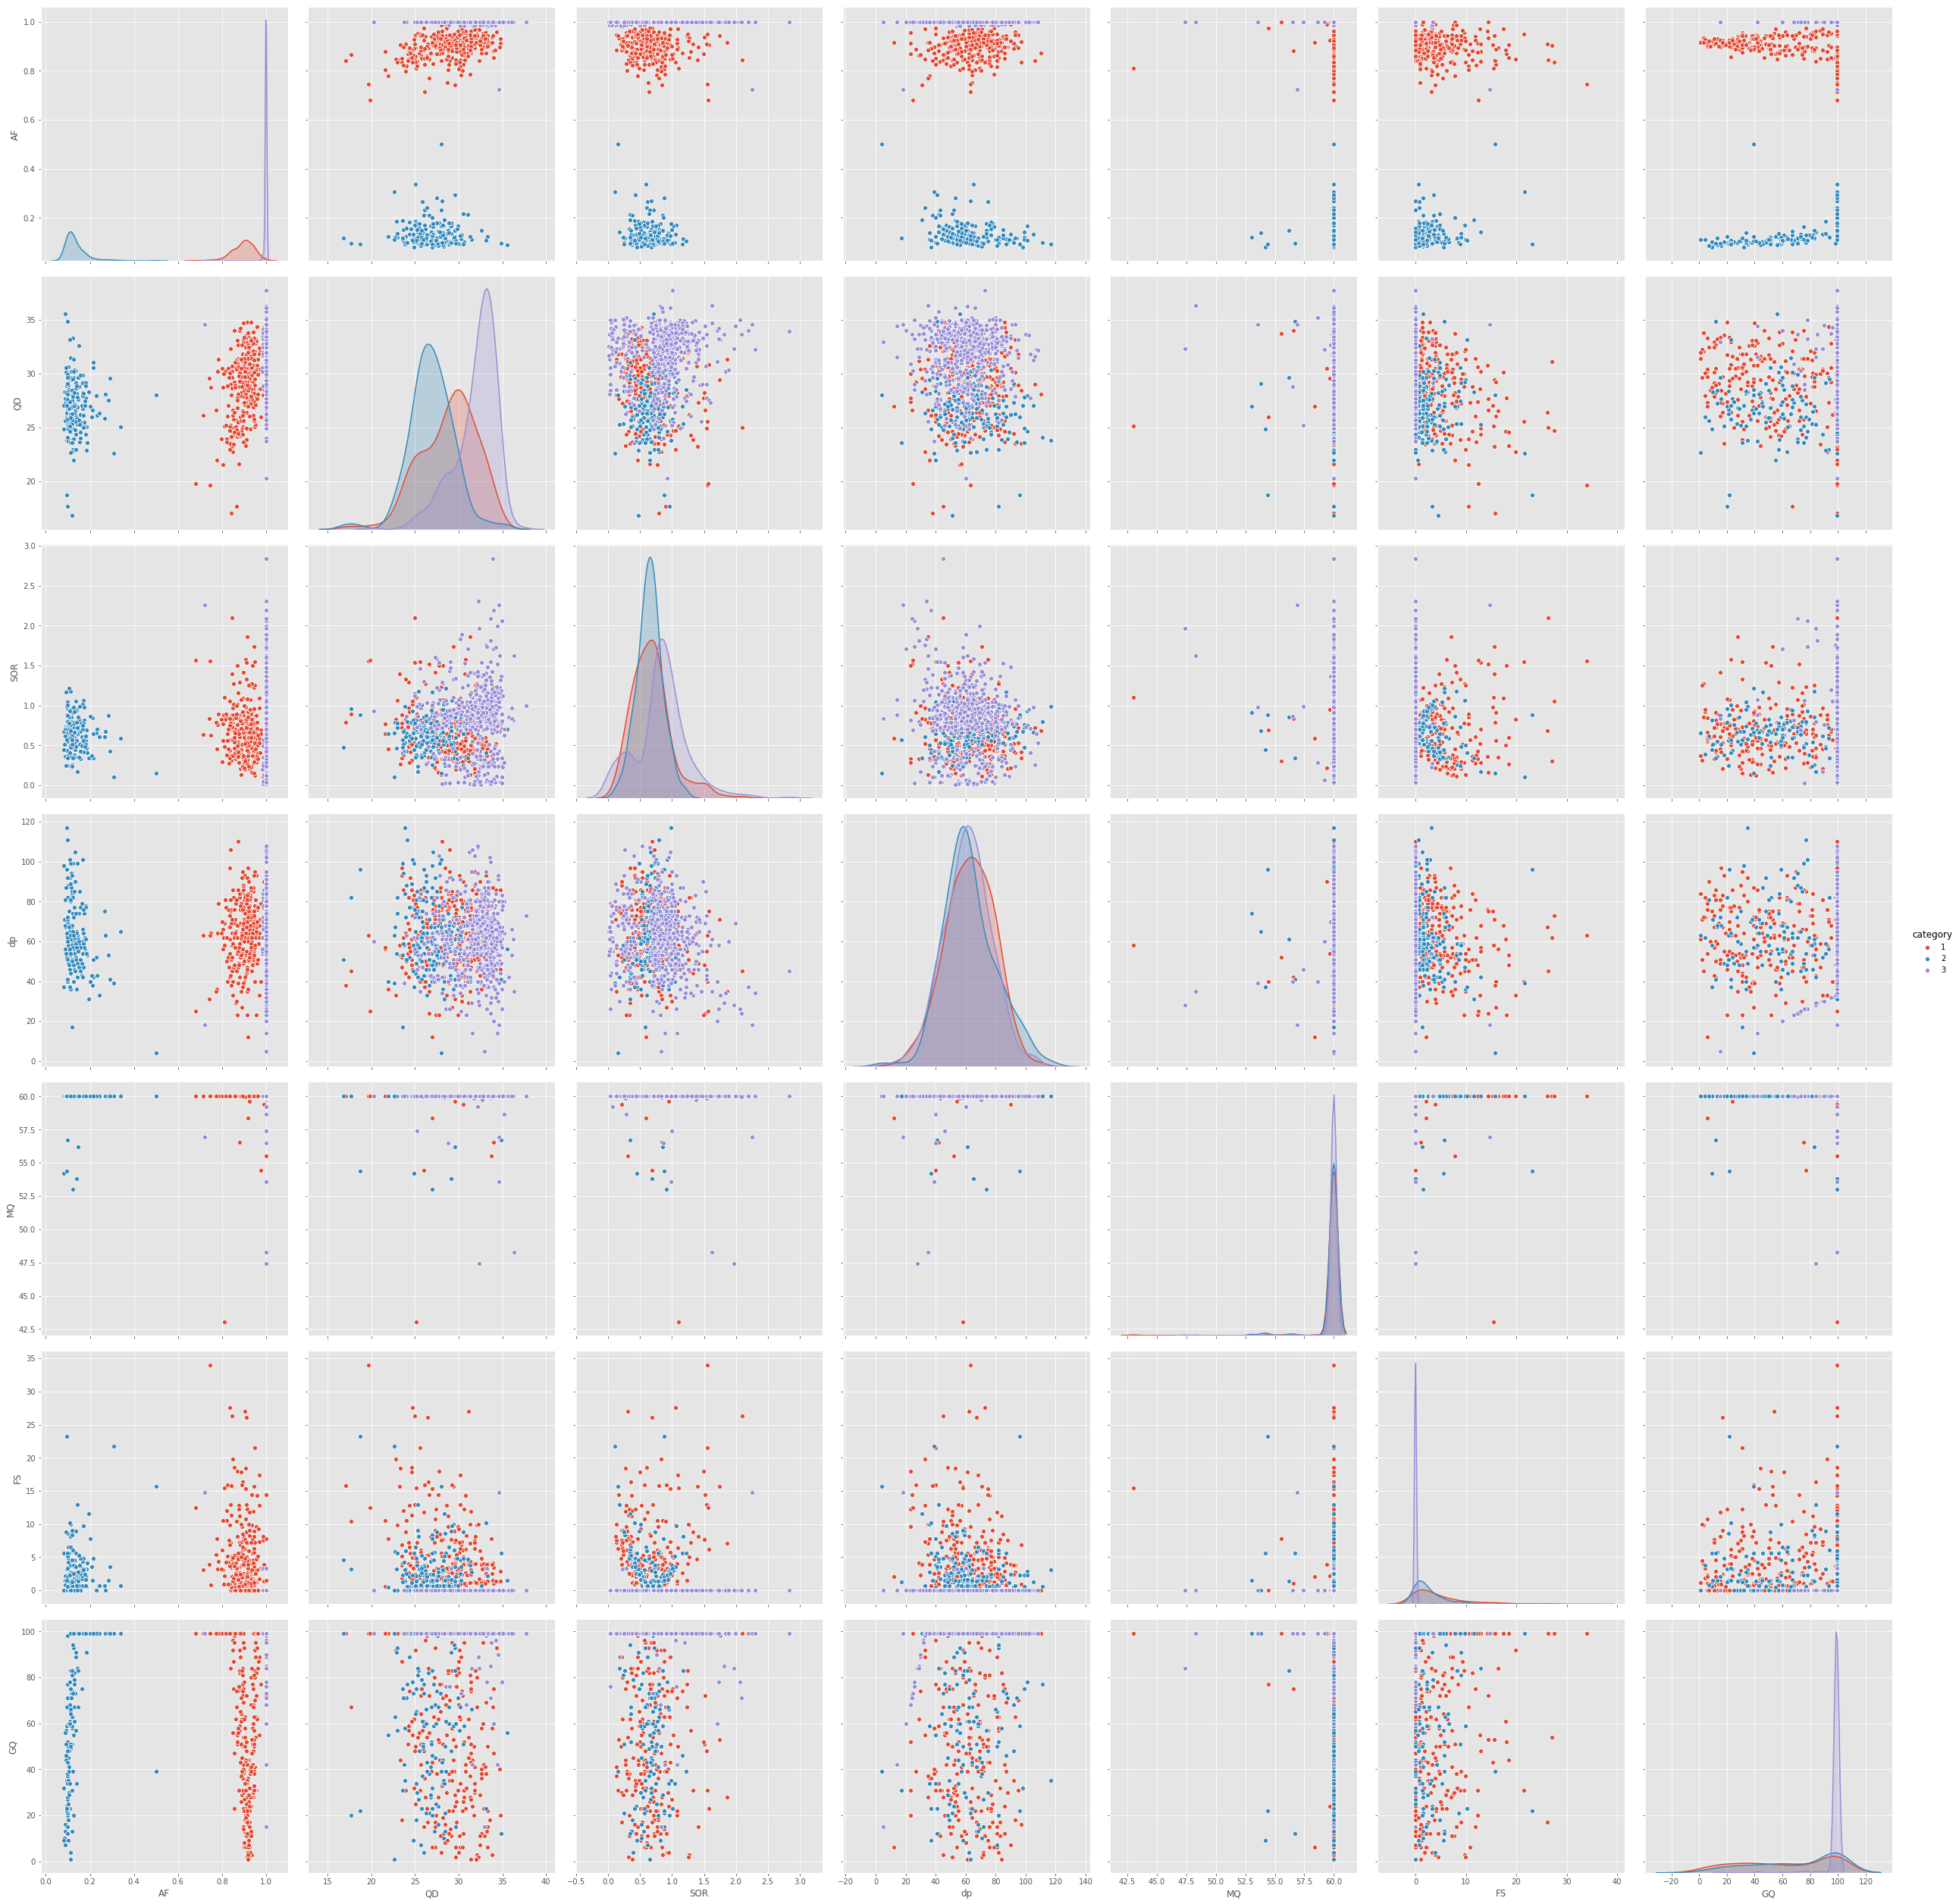

In [399]:
sns.pairplot(Ktest9, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

In [400]:
X = np.array(Ktest5[["AF","QD","FS"]])
y = np.array(Ktest5['category'])
X.shape

(1139, 3)

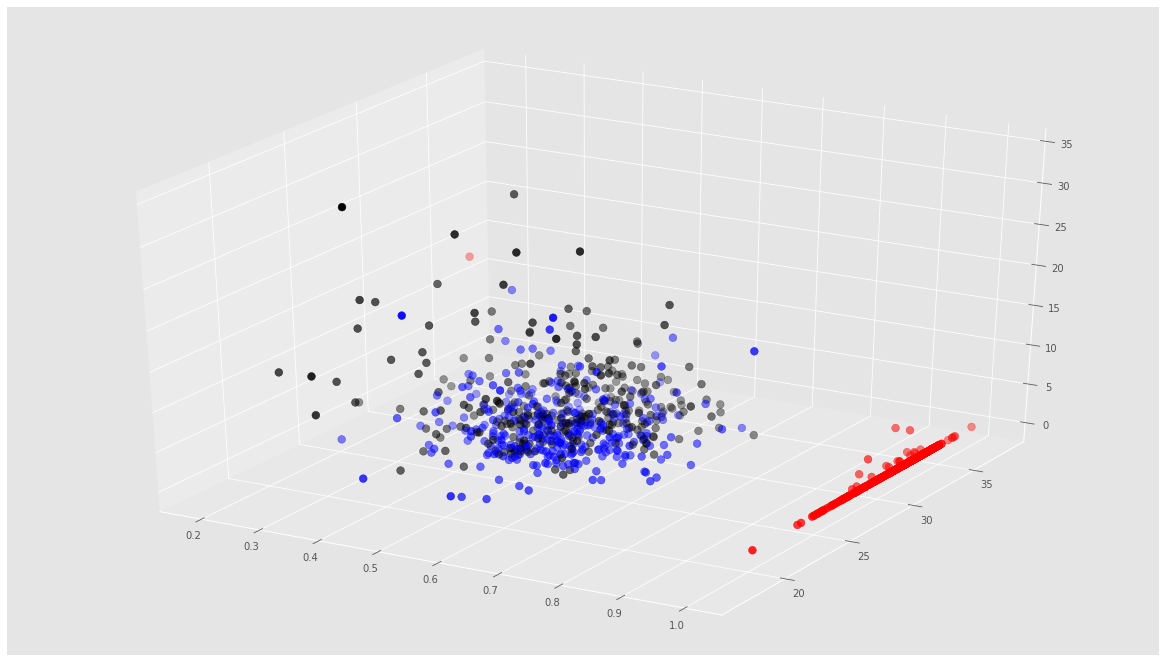

In [401]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y:
    assign.append(colors[row - 1])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)

In [402]:
X8 = np.array(Ktest8[["AF","QD","FS"]])
y8 = np.array(Ktest8['category'])
X8.shape

(1130, 3)

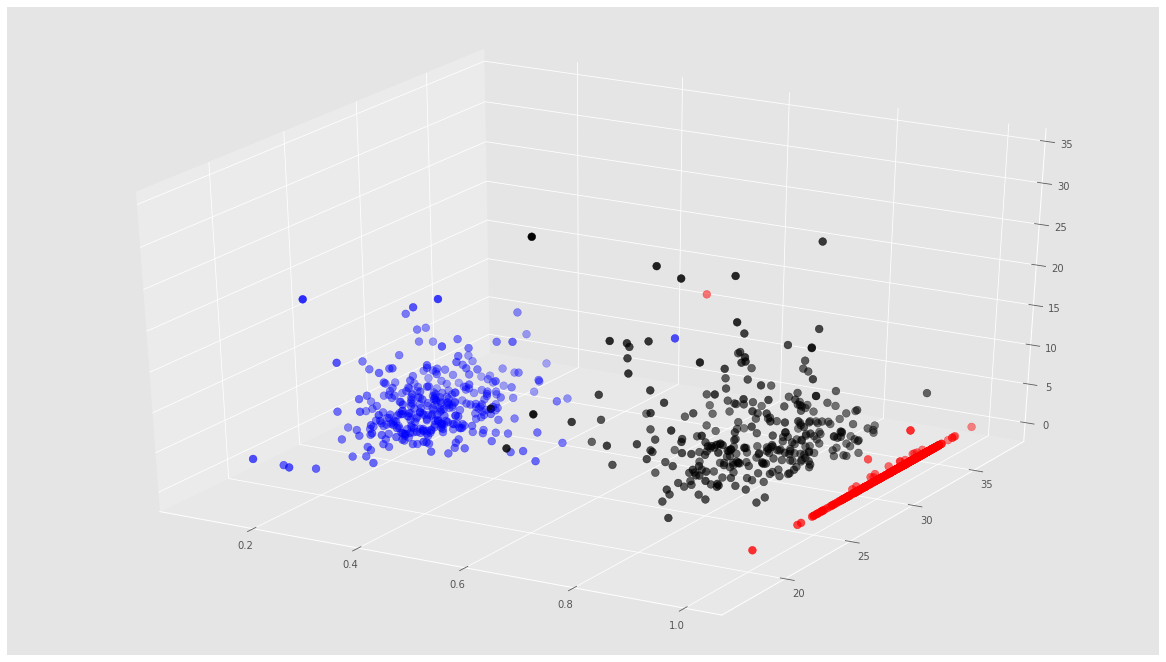

In [403]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y8:
    assign.append(colors[row - 1])
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)

In [404]:
X9 = np.array(Ktest9[["AF","QD","FS"]])
y9 = np.array(Ktest9['category'])
X9.shape

(996, 3)

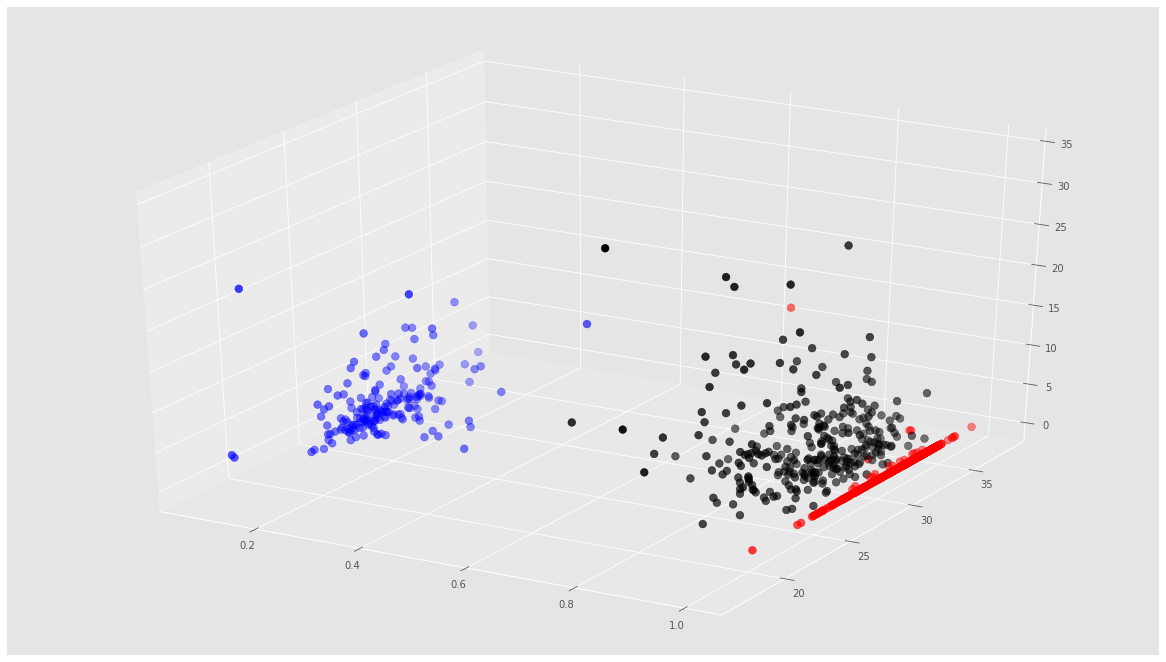

In [405]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y9:
    assign.append(colors[row - 1])
ax.scatter(X9[:, 0], X9[:, 1], X9[:, 2], c=assign,s=60)

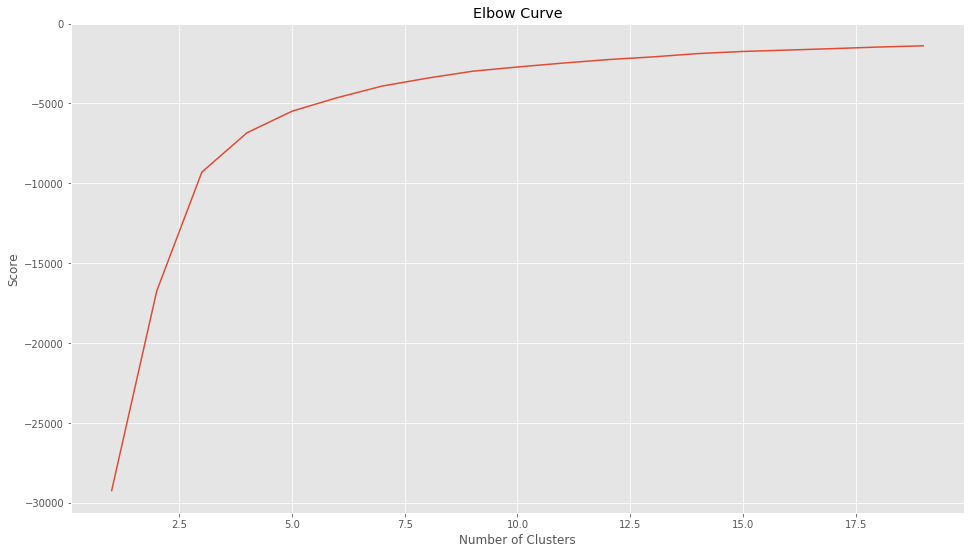

In [406]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [407]:
X = np.array(Ktest5[["AF","QD","FS", "MQ", "SOR"]])
y = np.array(Ktest5['category'])
X

array([[ 0.37037037, 30.57      ,  1.003     , 60.        ,  0.434     ],
       [ 1.        , 31.55      ,  0.        , 60.        ,  0.883     ],
       [ 0.62162162, 29.67      ,  0.919     , 60.        ,  0.827     ],
       ...,
       [ 1.        , 31.95      ,  0.        , 60.        ,  0.707     ],
       [ 0.57317073, 25.89      ,  0.        , 60.        ,  0.686     ],
       [ 0.60869565, 30.52      ,  4.826     , 60.        ,  0.643     ]])

In [408]:
X = StandardScaler().fit_transform(X)
X

array([[-1.38010131,  0.18760234, -0.24095006,  0.10684377, -0.90146442],
       [ 1.07021948,  0.48389173, -0.50288161,  0.10684377,  0.39434397],
       [-0.40231035, -0.08450015, -0.2628865 ,  0.10684377,  0.23272867],
       ...,
       [ 1.07021948,  0.60482617, -0.50288161,  0.10684377, -0.11358983],
       [-0.59086599, -1.22733064, -0.50288161,  0.10684377, -0.17419557],
       [-0.45261416,  0.17248554,  0.75741916,  0.10684377, -0.29829303]])

In [409]:
kmeans = KMeans(n_clusters=3, max_iter=1000, init='k-means++').fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.8700989  -0.53874524  0.41009604  0.07640912 -0.2121501 ]
 [ 1.02146966  0.63713145 -0.49341461  0.08710495  0.2316208 ]
 [-0.31655632 -0.43883807  0.77306193 -9.18384204  0.83128248]]


In [410]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [411]:
X8 = np.array(Ktest8[["AF","QD","FS", "MQ", "SOR"]])
y8 = np.array(Ktest8['category'])
X8 = StandardScaler().fit_transform(X8)

X8.shape

(1130, 5)

In [412]:
kmeans8 = KMeans(n_clusters=3, max_iter=1000, init='k-means++').fit(X8)
centroids8 = kmeans8.cluster_centers_
print(centroids8)

[[ 0.69271277  0.55135845 -0.39207312  0.08770488  0.14508104]
 [-0.45499849 -0.14732233  0.95826506 -7.90863725  0.89798124]
 [-0.99115825 -0.79502795  0.5410151   0.09833193 -0.23590422]]


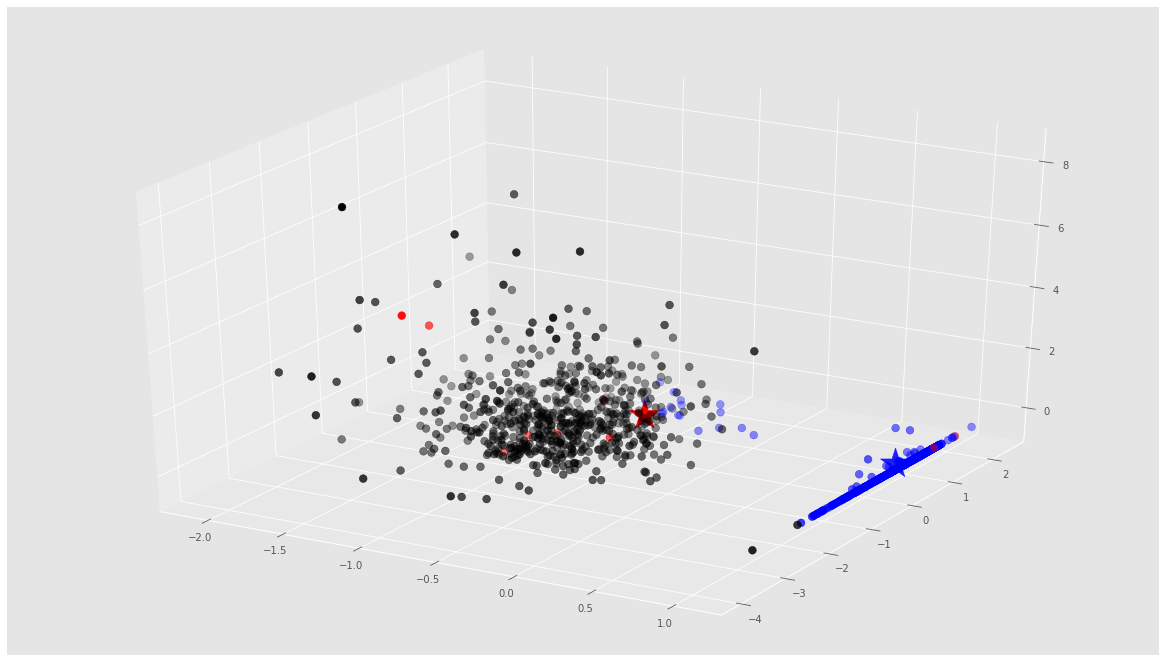

In [413]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colors=['black','blue','red']
assign=[]
for row in labels:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colors, s=1000)

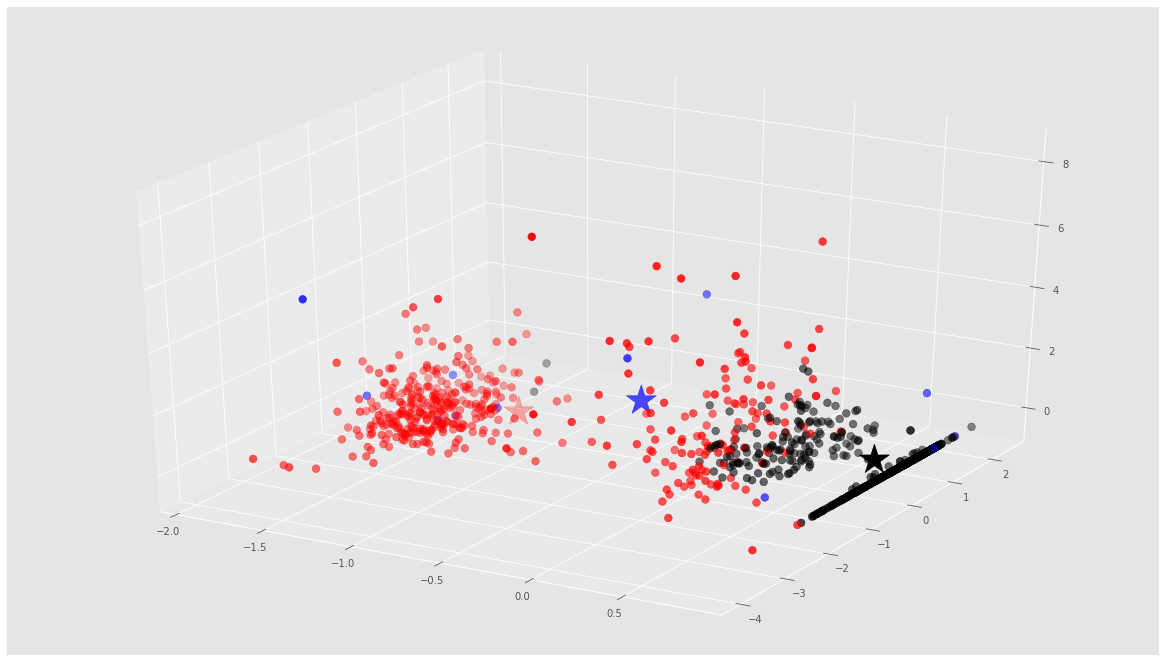

In [414]:
# Predicting the clusters
labels8 = kmeans8.predict(X8)
# Getting the cluster centers
C8 = kmeans8.cluster_centers_
colors=['black','blue','red']
assign=[]
for row in labels8:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)
ax.scatter(C8[:, 0], C8[:, 1], C8[:, 2], marker='*', c=colors, s=1000)

In [415]:
print(labels)

[0 1 0 ... 1 0 0]


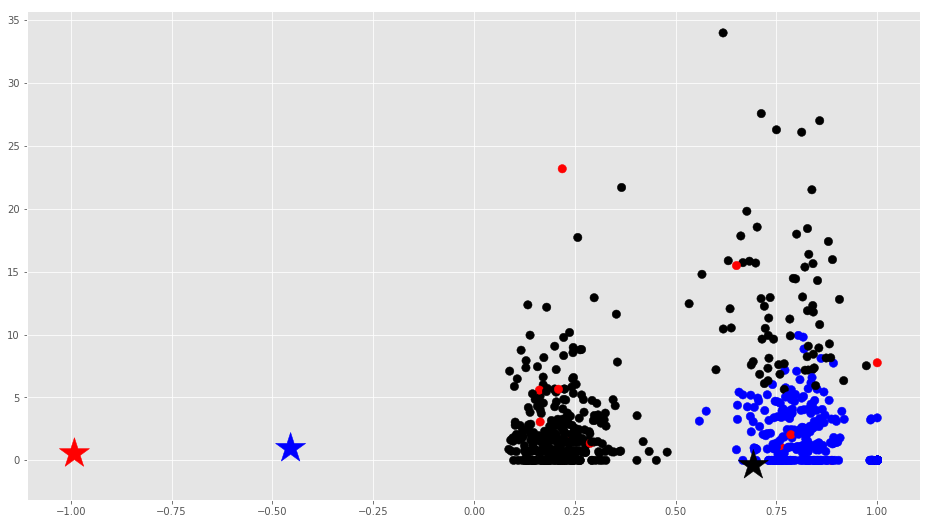

In [439]:
# Getting the values and plotting it
f1 = Ktest8['AF'].values
f2 = Ktest8['FS'].values

plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(C8[:, 0], C8[:, 2], marker='*', c=colors, s=1000)
plt.show()

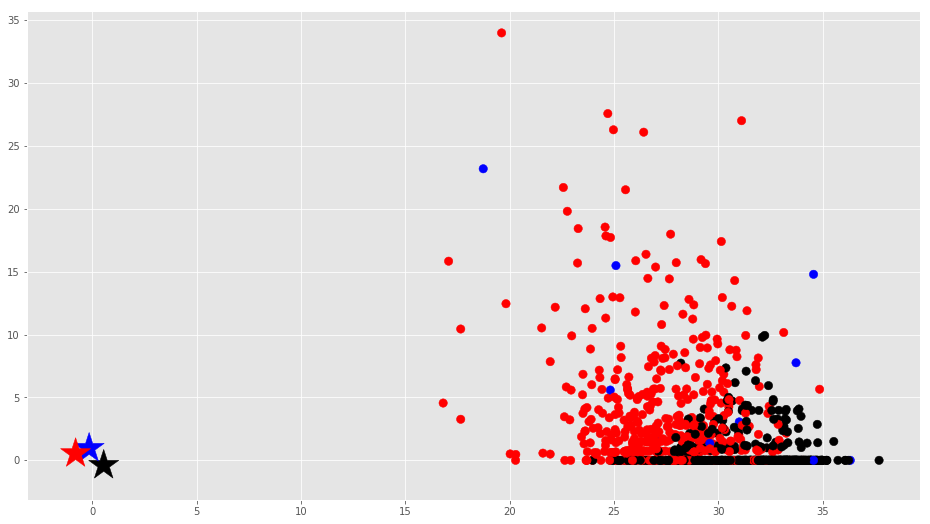

In [418]:
# Getting the values and plotting it
f1 = Ktest8['QD'].values
f2 = Ktest8['FS'].values

plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(C8[:, 1], C8[:, 2], marker='*', c=colors, s=1000)
plt.show()

In [419]:
copy =  pd.DataFrame()
copy['POS']=Ktest8['POS'].values
copy['AF']=Ktest8['AF'].values
copy['category']=Ktest8['category'].values
copy['label'] = labels8;
Ngrouped =  pd.DataFrame()
Ngrouped['colors']=colors
Ngrouped['N']=copy.groupby('label').size()
Ngrouped

colors    N
0  black  660
1   blue   13
2    red  457

In [420]:
copy.head()

POS        AF  category  label
0  1977  0.761905         1      0
1  2532  1.000000         3      0
2  6140  0.173077         2      2
3  7585  0.694444         1      0
4  9143  1.000000         3      0

# Use more labels

In [421]:
W = np.array(Ktest8[["AF","QD","FS","MQ","SOR", "DP", "dp"]])
W

array([[ 0.76190476, 30.57      ,  1.003     , ...,  0.434     ,
        42.        , 42.        ],
       [ 1.        , 31.55      ,  0.        , ...,  0.883     ,
        13.        , 13.        ],
       [ 0.17307692, 29.67      ,  0.919     , ...,  0.827     ,
        52.        , 52.        ],
       ...,
       [ 1.        , 31.95      ,  0.        , ...,  0.707     ,
        59.        , 59.        ],
       [ 0.20481928, 25.89      ,  0.        , ...,  0.686     ,
        83.        , 83.        ],
       [ 0.34482759, 30.52      ,  4.826     , ...,  0.643     ,
        58.        , 58.        ]])

In [422]:
kmeansw = KMeans(n_clusters=3, max_iter=1000, verbose=0, init='k-means++').fit(W)
centroidsw = kmeansw.cluster_centers_
print(kmeansw)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [423]:
print(centroidsw)

[[ 0.714286   29.64307432  1.52205405 59.95243243  0.70502703 83.13175676
  83.11486486]
 [ 0.71557084 29.77181518  2.692      59.79607261  0.79863696 42.70627063
  42.69306931]
 [ 0.72802816 30.20306968  1.71556497 59.93231638  0.74025612 62.41054614
  62.40301318]]


In [424]:
labelsw = kmeansw.predict(W)


In [425]:
w =  pd.DataFrame()
w['POS']=Ktest8['POS'].values
w['AF']=Ktest8['AF'].values
w['category']=Ktest8['category'].values
w['label'] = labelsw;

In [426]:
labelsw

array([1, 1, 1, ..., 2, 0, 2], dtype=int32)

In [427]:
w.describe()

POS           AF     category        label
count  1.130000e+03  1130.000000  1130.000000  1130.000000
mean   2.184658e+06     0.721088     2.189381     1.207965
std    1.321683e+06     0.334922     0.824488     0.830192
min    1.977000e+03     0.086207     1.000000     0.000000
25%    1.055535e+06     0.292683     1.000000     0.000000
50%    2.152588e+06     0.851852     2.000000     1.000000
75%    3.309010e+06     1.000000     3.000000     2.000000
max    4.408156e+06     1.000000     3.000000     2.000000

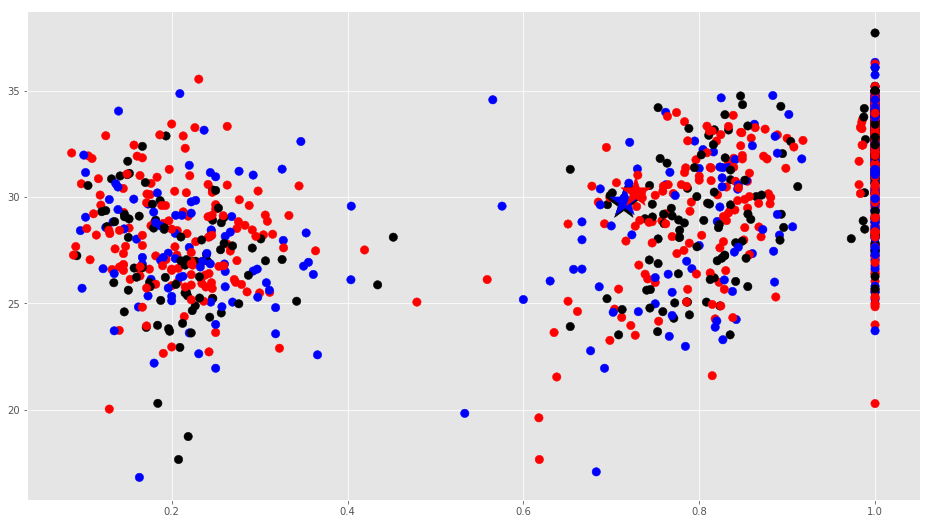

In [428]:
# Getting the values and plotting it
f1 = Ktest8['AF'].values
f2 = Ktest8['QD'].values


colors=['black','blue','red']
assign=[]
for row in labelsw:
    assign.append(colors[row])


plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(centroidsw[:, 0], centroidsw[:, 1], marker='*', c=colors, s=1000)
plt.show()

In [429]:
 #metrics.adjusted_rand_score(labels_true, labels_pred)

# Compute Affinity Propagation

In [430]:
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))


Estimated number of clusters: 183
Silhouette Coefficient: 0.239


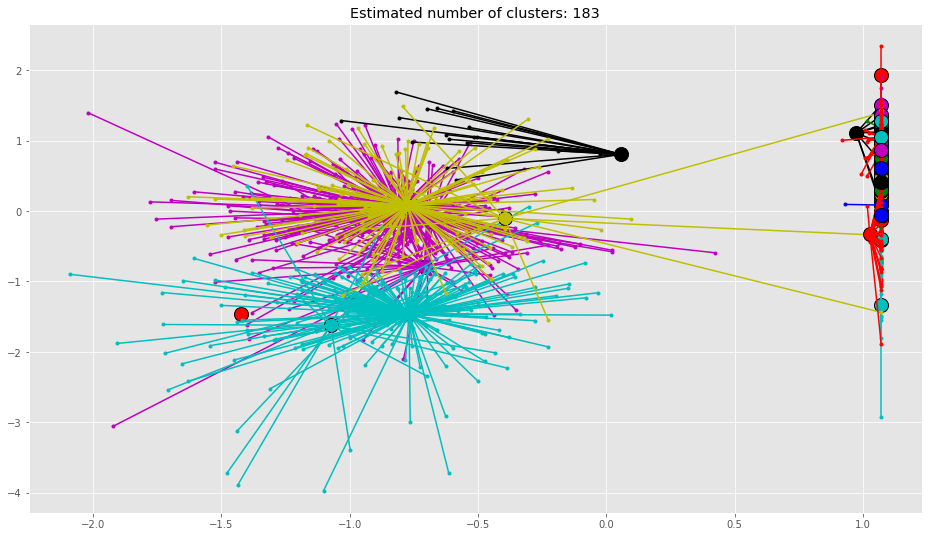

In [431]:

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Compute Agglomerative Clustering

In [432]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward') #connectivity=connectivity
ward.fit(X8)
#label = np.reshape(ward.labels_, rescaled_coins.shape)
labels = ward.labels_


In [433]:
Ktest8['Label'] = labels

/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [441]:
#Ktest8[Ktest8.Label == 2]

#CHROM      POS ID REF ALT      QUAL FILTER  \
40    MTB_anc    80351  .   A   G  17194.04   PASS   
54    MTB_anc   104712  .   T   C  18739.38   PASS   
329   MTB_anc   832201  .   T   C  21493.27   PASS   
330   MTB_anc   832246  .   G   A  21185.27   PASS   
346   MTB_anc   909280  .   A   C  18293.35   PASS   
412   MTB_anc  1096633  .   T   G  32527.19   PASS   
499   MTB_anc  1341023  .   A   G  19612.65   PASS   
631   MTB_anc  1638364  .   T   C  30443.27   PASS   
737   MTB_anc  2030472  .   T   C   7957.61   PASS   
860   MTB_anc  2302033  .   G   A  15543.63   PASS   
957   MTB_anc  2626108  .   G   C  45602.18   PASS   
1029  MTB_anc  2945167  .   G   T  20674.46   PASS   
1106  MTB_anc  3135896  .   G   A  34065.27   PASS   
1107  MTB_anc  3135912  .   G   C  24053.53   PASS   
1214  MTB_anc  3484012  .   T   G  20213.59   PASS   
1362  MTB_anc  4053050  .   A   G   4883.94   PASS   
1454  MTB_anc  4318425  .   G   C  31503.27   PASS   

                                                   INFO  \
40    AC=1;AF=0.500;AN=2;BaseQRankSum=1.32;DP=42;Exc...   
54    AC=1;AF=0.500;AN=2;BaseQRankSum=2.18;DP=35;Exc...   
329   AC=2;AF=1.00;AN=2;DP=39;ExcessHet=3.0103;FS=0....   
330   AC=2;AF=1.00;AN=2;DP=31;ExcessHet=3.0103;FS=0....   
346   AC=1;AF=0.500;AN=2;BaseQRankSum=3.54;DP=61;Exc...   
412   AC=1;AF=0.500;AN=2;BaseQRankSum=3.11;DP=79;Exc...   
499   AC=1;AF=0.500;AN=2;BaseQRankSum=-2.270e-01;DP=...   
631   AC=2;AF=1.00;AN=2;DP=50;ExcessHet=3.0103;FS=0....   
737   AC=1;AF=0.500;AN=2;BaseQRankSum=2.12;DP=63;Exc...   
860   AC=1;AF=0.500;AN=2;BaseQRankSum=-1.309e+00;DP=...   
957   AC=2;AF=1.00;AN=2;BaseQRankSum=-4.590e-01;DP=6...   
1029  AC=1;AF=0.500;AN=2;BaseQRankSum=-7.110e-01;DP=...   
1106  AC=2;AF=1.00;AN=2;DP=40;ExcessHet=3.0103;FS=0....   
1107  AC=1;AF=0.500;AN=2;BaseQRankSum=-2.074e+00;DP=...   
1214  AC=1;AF=0.500;AN=2;BaseQRankSum=1.40;DP=59;Exc...   
1362  AC=1;AF=0.500;AN=2;BaseQRankSum=-8.860e-01;DP=...   
1454  AC=2;AF=1.00;AN=2;DP=42;ExcessHet=3.0103;FS=0....   

                         FORMAT  \
40               GT:AD:DP:GQ:PL   
54               GT:AD:DP:GQ:PL   
329              GT:AD:DP:GQ:PL   
330              GT:AD:DP:GQ:PL   
346              GT:AD:DP:GQ:PL   
412              GT:AD:DP:GQ:PL   
499              GT:AD:DP:GQ:PL   
631              GT:AD:DP:GQ:PL   
737              GT:AD:DP:GQ:PL   
860              GT:AD:DP:GQ:PL   
957              GT:AD:DP:GQ:PL   
1029             GT:AD:DP:GQ:PL   
1106  GT:AD:DP:GQ:PGT:PID:PL:PS   
1107  GT:AD:DP:GQ:PGT:PID:PL:PS   
1214             GT:AD:DP:GQ:PL   
1362             GT:AD:DP:GQ:PL   
1454             GT:AD:DP:GQ:PL   

                                                 sample   AC   af   AN  \
40                           0/1:10,32:42:99:1098,0,214  1.0  0.5  2.0   
54                             0/1:4,31:35:15:1125,0,15  1.0  0.5  2.0   
329                           1/1:0,39:39:99:1417,117,0  2.0  1.0  2.0   
330                            1/1:0,31:31:93:1187,93,0  2.0  1.0  2.0   
346                          0/1:51,10:61:99:217,0,1544  1.0  0.5  2.0   
412                          0/1:60,19:79:99:404,0,1712  1.0  0.5  2.0   
499                          0/1:50,14:64:99:392,0,1955  1.0  0.5  2.0   
631                           1/1:0,50:50:99:1843,150,0  2.0  1.0  2.0   
737                          0/1:22,41:63:99:1338,0,577  1.0  0.5  2.0   
860                             0/1:31,6:37:99:99,0,942  1.0  0.5  2.0   
957                           1/1:0,60:60:99:2269,180,0  2.0  1.0  2.0   
1029                         0/1:75,21:96:99:467,0,2266  1.0  0.5  2.0   
1106  1|1:0,40:40:99:1|1:3135896_G_A:1400,124,0:3135896  2.0  1.0  2.0   
1107  0|1:34,9:43:99:0|1:3135896_G_A:179,0,1258:3135896  1.0  0.5  2.0   
1214                         0/1:42,17:59:99:397,0,1132  1.0  0.5  2.0   
1362                            0/1:3,11:14:80:304,0,80  1.0  0.5  2.0   
1454                          1/1:0,42:42:99:1518,126,0  2.0  1.0  2.0   

      B

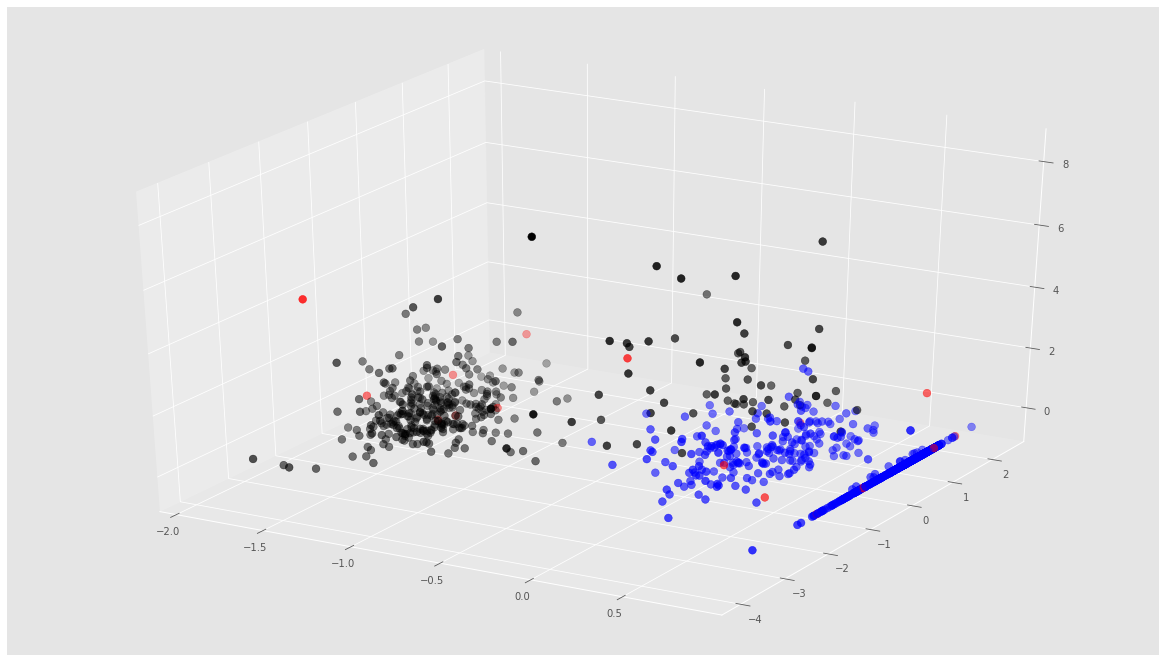

In [435]:
# Predicting the clusters

# Getting the cluster centers
colors=['black','blue','red']
assign=[]
for row in labels:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)


In [436]:
# #############################################################################
# Plot the results on an image
plt.figure(figsize=(5, 5))
#plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

NameError: name 'n_clusters' is not defined

<Figure size 360x360 with 0 Axes>